In [1]:
import sympy
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree

import SCRBenchmark.SRSDFeynman as srsdf
import SCRBenchmark.Constants.StringKeys as sk
from SCRBenchmark import create_dataset_from_sampling_objectives
from SCRBenchmark import Benchmark

import SCRBenchmark.SRSDFeynman as srsdf
import SCRBenchmark.Constants.StringKeys as sk
from SCRBenchmark import create_dataset_from_sampling_objectives, get_constraint_descriptor
from SCRBenchmark import Benchmark

# CONSTRAINT_SAMPLING_SIZE = 10_000_000
CONSTRAINT_SAMPLING_SIZE = 100_000

# This code determines the constraints for each equation. To this end, a large
# set of uniform input data is sampled for the defined input space of the
# equation. This data is then:
# 1) plugged into the equation to calculate the image of the function. If all
#    values are e.g. positive, they all have a sign of '+' thus the function.
# 2) plugged into the symbolic first-order derivatives of the function (derived
#    over all available inputs). This time we get the gradients of the original
#    function. If all values of df/dx_1 are zero or positive we know that the
#    function is monotonic non-decreasing over x_1.
# 3) the same is repeated for second-order derivatives to determine convexity
#    and concavity.
#   
# The above simple approach would only recognize constraints that are valid for
# the whole input space. However, for e.g. Feynman2 (I.6.20a), the probabilistic density
# function of the normal distribution with $\mu=0$ and $\sigma=1$, the function
# is monotonic non-decreasing for values of $theta \leq 0$ and monotonic
# non-increasing for values of $theta \geq 0$. See
# examples/data/checking_constraints.ipynb for a visual explanation.
#
# To advance this simple approach, instead, all gradients are calculated for the
# whole input data and a decision tree classifier is employed to find suitable
# cutting points for the input space. We restrict the tree size to prevent large
# numbers of found constraints (especially with cyclic changes of
# gradients in trigonometric functions and multiples of pi).

def tree_to_constraints(clf, node, bounds):
    # Recursively traverse the decision tree to extract constraints
    
    if clf.tree_.children_left[node] == -1:
        # leaf node is reached, stop traverse
        if clf.tree_.value[node][0][0] == 1: 
            # internal array representation of trees. If class [0] is certain ==1, it is negative
            return [(bounds, sk.EQUATION_CONSTRAINTS_DESCRIPTOR_NEGATIVE)]
        if clf.tree_.value[node][0][1] == 1:
            # internal array representation of trees. If class [1] is certain ==1, it is positive
            return [(bounds, sk.EQUATION_CONSTRAINTS_DESCRIPTOR_POSITIVE)]
        raise 'ERROR Class not considered' 
        # return None
    
    # not a leaf node: split bounds on current threshold 
    # to recursively traverse to leafs
    bleft = bounds.copy() #copy existing bounds for left
    bright = bounds.copy() # and right tree

    #extract selected feature and threshold of the feature
    f = clf.tree_.feature[node]
    s = clf.tree_.threshold[node]

    # split bounds on the feature used for distinction
    # replace the resulting bounds for the feature with the threshold
    bleft[f] = (bounds[f][0], s)
    bright[f] = (s, bounds[f][1])

    # traverse left and right subtree and combine results
    return [x for x in tree_to_constraints(clf, clf.tree_.children_left[node], bleft)] + \
           [x for x in tree_to_constraints(clf, clf.tree_.children_right[node], bright)]

def evaluate_equation(eq, local_dict, xs):
    # Evaluate the equation for each row in the dataset
    f = sympy.lambdify(local_dict, eq, "numpy")
    #calculate gradient per data point
    # old: 
    #   gradients = np.array([ f(*row) for row in xs ])
    # speedup of 5:
    def l(x):
        return f(*x)
    return xs.apply(l, axis=1, raw=True)

def range_to_space(range, names):
    # Convert range to a sampling space dictionary
    return [{'name': str(names[i]),
             'low': float(range[i][0]),
             'high': float(range[i][1])} 
            for i in range]

constraints_textual = []
res = dict()

for equation_dictionary_entry in srsdf.AllEquations:
    res[equation_dictionary_entry] = dict()

    bench = Benchmark(srsdf.AllEquations[equation_dictionary_entry], initialize_constraint_checking_datasets=False)
    
    print(bench.equation.get_eq_name())

    # generate large set of data for the full input space
    variable_display_names = bench.equation.get_var_names()
    data = pd.DataFrame(create_dataset_from_sampling_objectives(
                            # replace the actual standard sampling targets with their respective uniform variant
                            [samp.to_uniform_sampling() for samp in bench.equation.sampling_objs], 
                            bench.equation.sympy_eq, 
                            bench.equation.eq_func, 
                            bench.equation.check_if_valid, 
                            CONSTRAINT_SAMPLING_SIZE,
                            patience=CONSTRAINT_SAMPLING_SIZE), 
                        columns=variable_display_names + ["target"])

    # function itself to calculate image
    f = [(bench.equation.sympy_eq, "", "", 0)] 

    # first-order derivatives    
    f_primes = [(sympy.Derivative(bench.equation.sympy_eq, var, 1).doit(), var.name, var_display_name, 1) 
                for (var, var_display_name) 
                in list(zip(bench.equation.x, bench.equation.get_var_names()))]
    
    # second-order derivatives
    f_seconds = [(sympy.Derivative(bench.equation.sympy_eq, var, 2).doit(), var.name, var_display_name, 2) 
                 for (var, var_display_name) 
                 in list(zip(bench.equation.x, bench.equation.get_var_names()))]
    
    # combine all for subsequent checks
    f_all = f + f_primes + f_seconds 

    constraints = []

    vars = [(x, y.get_value_range()) for (x, y) in zip(variable_display_names, bench.equation.sampling_objs)]
    ranges = {i: (x[1][0], x[1][1]) for i, x in enumerate(vars)}

    for derivative, variable, variable_name, degree in f_all:
        derivative_name_id = f'{variable_name}_{degree}'
        gradient_sign_id = f'{variable_name} {degree} sign'

        data[derivative_name_id] = evaluate_equation(derivative, bench.equation.x, data[variable_display_names])
        data[gradient_sign_id] = np.sign(data[derivative_name_id])

        d1 = data[data[gradient_sign_id] != 0] # remove all gradients of 0 as we do not care for strong monotonicity
        classes = np.unique(d1[gradient_sign_id])

        if len(classes) <= 1:
            # Gradients are either all zero, all negative valued, or all positive valued.
            if len(classes) == 0: # no gradients remain -> all were zero
                constraint_descriptor = sk.EQUATION_CONSTRAINTS_DESCRIPTOR_ZERO

            elif len(classes) == 1:  # only one type of gradient in the data
                if classes[0] == 1: # 1 is sign positive
                    constraint_descriptor = sk.EQUATION_CONSTRAINTS_DESCRIPTOR_POSITIVE    
                else:  # -1 is sign negative
                    constraint_descriptor = sk.EQUATION_CONSTRAINTS_DESCRIPTOR_NEGATIVE  
            
            res[equation_dictionary_entry][gradient_sign_id] = constraint_descriptor
            constraints.append({
                sk.EQUATION_CONSTRAINTS_VAR_NAME_KEY: variable,
                sk.EQUATION_CONSTRAINTS_VAR_DISPLAY_NAME_KEY: variable_name,
                sk.EQUATION_CONSTRAINTS_ORDER_DERIVATIVE_KEY: degree,
                sk.EQUATION_CONSTRAINTS_DESCRIPTOR_KEY: constraint_descriptor,
                sk.EQUATION_CONSTRAINTS_DERIVATIVE_KEY: str(derivative),
                # use original space of the full input domain as specified by the
                # benchmark as constraint is valid for the full domain 
                sk.EQUATION_CONSTRAINTS_SAMPLE_SPACE_KEY: [{'name': str(var),
                                                            'low': float(range[0]),
                                                            'high': float(range[1])} 
                                                           for (var, range) in vars],
                sk.EQUATION_CONSTRAINTS_ID_KEY: len(constraints)  
            })
        else: 
            # Gradient switches at unknown domain subspaces. We use a decision
            # tree to find suitable cutting points for subspaces but restrict
            # the decision tree to depth of 2 as we desire only meaningful cuts.
            # e.g. most often, the sign changes at 0 or at multiples of pi for
            # equations with trigonometric functions.
            
            clf = tree.DecisionTreeClassifier(max_depth=2)
            clf = clf.fit(d1[variable_display_names], d1[gradient_sign_id]) 

            if clf.score(d1[variable_display_names], d1[gradient_sign_id]) >= (1 - (1 / CONSTRAINT_SAMPLING_SIZE)):
                
                res[equation_dictionary_entry][gradient_sign_id] = (clf,variable_display_names)

                # continue only if gradients could be easily separated along the
                # input domain
                for (range, constraint_descriptor) in tree_to_constraints(clf, 0, ranges):
                    # traversing tree and returning constraints
                    s = range_to_space(range, bench.equation.x)
                    constraints.append({
                        sk.EQUATION_CONSTRAINTS_VAR_NAME_KEY: variable,
                        sk.EQUATION_CONSTRAINTS_VAR_DISPLAY_NAME_KEY: variable_name,
                        sk.EQUATION_CONSTRAINTS_ORDER_DERIVATIVE_KEY: degree,
                        sk.EQUATION_CONSTRAINTS_DESCRIPTOR_KEY: constraint_descriptor,
                        sk.EQUATION_CONSTRAINTS_DERIVATIVE_KEY: str(derivative),
                        # use the divided subspace for the constraint as
                        # gradients changed for certain cutting points
                        sk.EQUATION_CONSTRAINTS_SAMPLE_SPACE_KEY: s,
                        sk.EQUATION_CONSTRAINTS_ID_KEY: len(constraints)  
                    })
            else:
                res[equation_dictionary_entry][gradient_sign_id] = None


    constraints_textual.append(str({sk.EQUATION_EQUATION_NAME_KEY: bench.equation.get_eq_name(),
                                    sk.EQUATION_CONSTRAINTS_CONSTRAINTS_KEY: constraints}).replace('\'', '\"'))


FeynmanICh6Eq20
FeynmanICh6Eq20a
FeynmanICh6Eq20b
FeynmanICh8Eq14
FeynmanICh9Eq18
FeynmanICh10Eq7
FeynmanICh11Eq19
FeynmanICh12Eq1
FeynmanICh12Eq2
FeynmanICh12Eq4
FeynmanICh12Eq5
FeynmanICh12Eq11
FeynmanICh13Eq4
FeynmanICh13Eq12
FeynmanICh14Eq3
FeynmanICh14Eq4
FeynmanICh15Eq10
FeynmanICh15Eq3t
FeynmanICh15Eq3x
FeynmanICh16Eq6
FeynmanICh18Eq4
FeynmanICh18Eq12
FeynmanICh18Eq16
FeynmanICh24Eq6
FeynmanICh25Eq13
FeynmanICh26Eq2
FeynmanICh27Eq6
FeynmanICh29Eq4
FeynmanICh29Eq16
FeynmanICh30Eq3
FeynmanICh30Eq5
FeynmanICh32Eq5
FeynmanICh32Eq17
FeynmanICh34Eq10
FeynmanICh34Eq8
FeynmanICh34Eq14
FeynmanICh34Eq27
FeynmanICh37Eq4
FeynmanICh38Eq12
FeynmanICh39Eq10
FeynmanICh39Eq11
FeynmanICh39Eq22
FeynmanICh40Eq1
FeynmanICh41Eq16
FeynmanICh43Eq16
FeynmanICh43Eq31
FeynmanICh43Eq43
FeynmanICh44Eq4
FeynmanICh47Eq23
FeynmanICh48Eq2
FeynmanICh50Eq26
FeynmanIICh2Eq42
FeynmanIICh3Eq24
FeynmanIICh4Eq23
FeynmanIICh6Eq11
FeynmanIICh6Eq15a
FeynmanIICh6Eq15b
FeynmanIICh8Eq7
FeynmanIICh8Eq31
FeynmanIICh10Eq9
Feyn

120 17


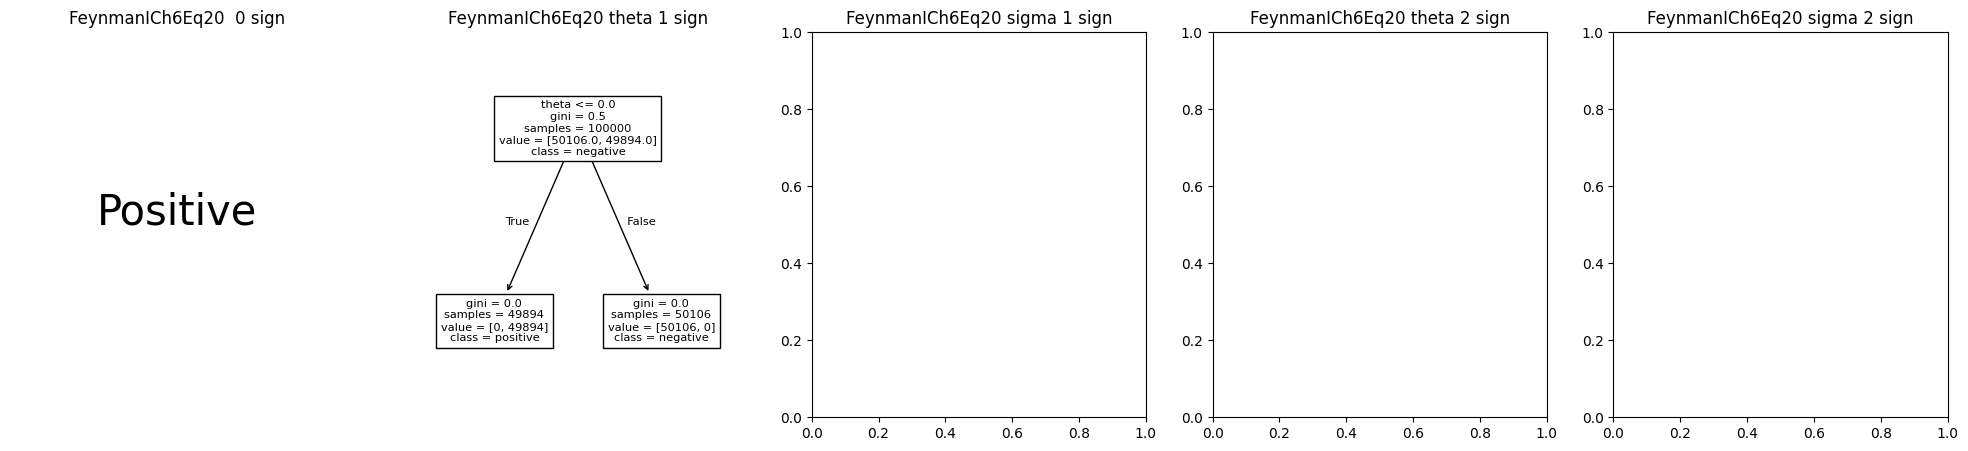

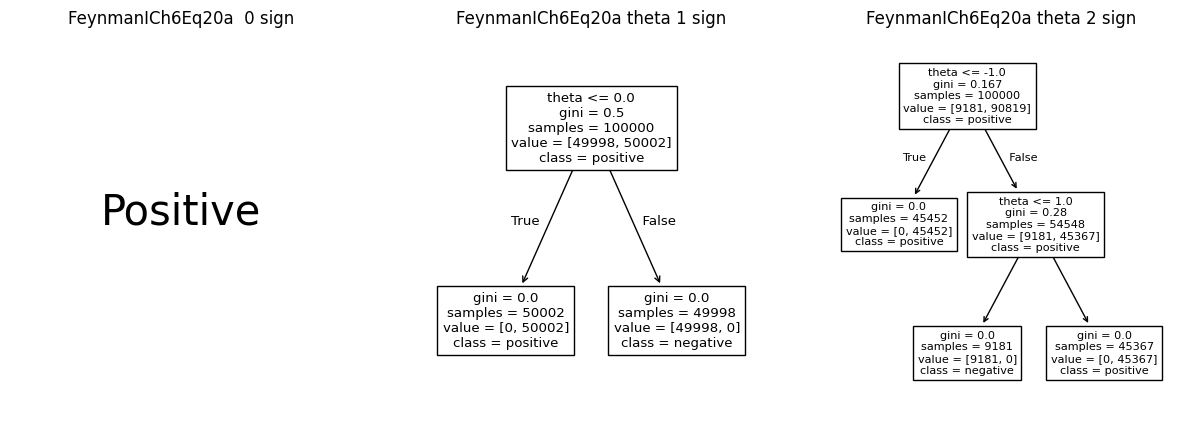

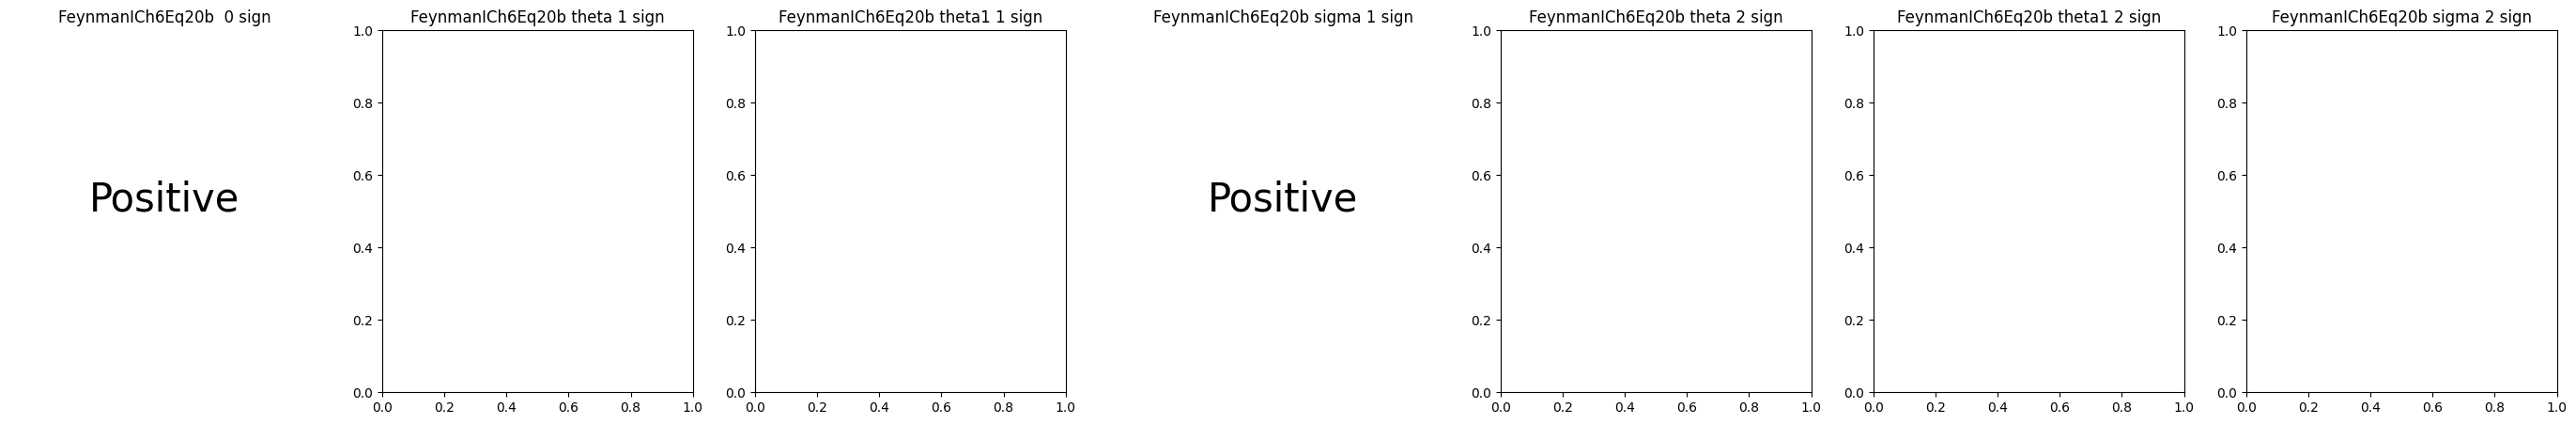

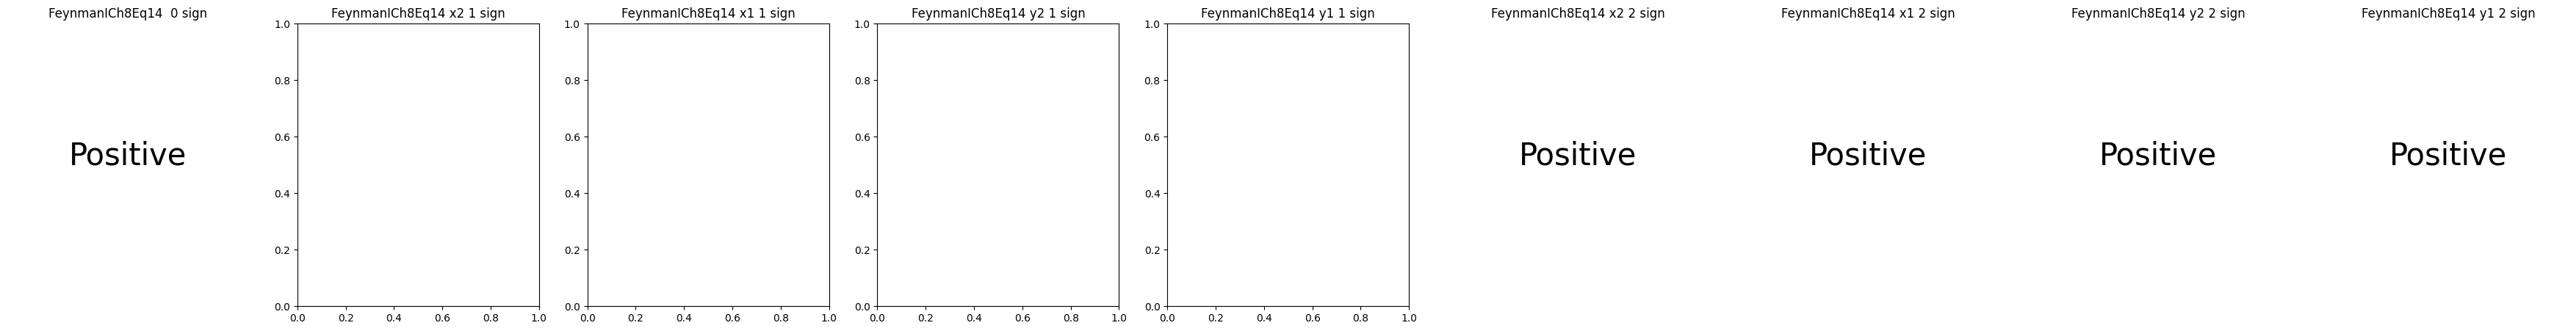

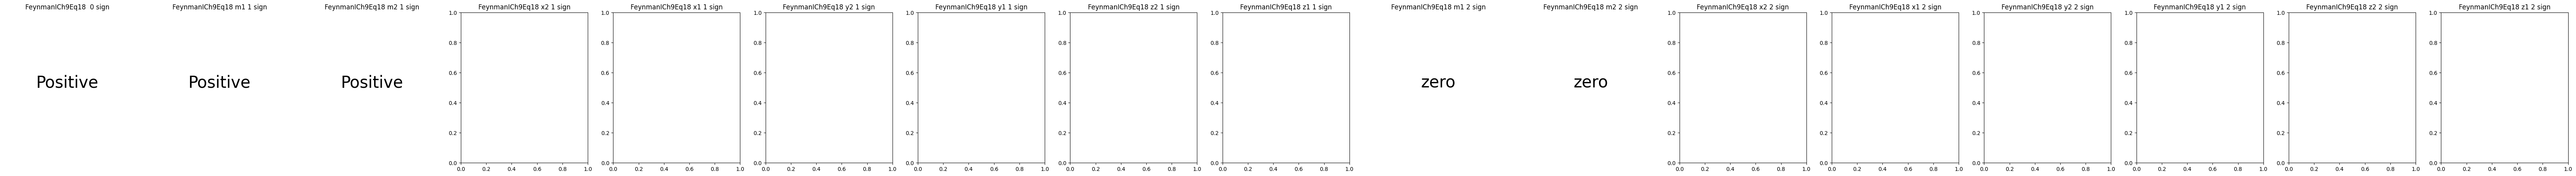

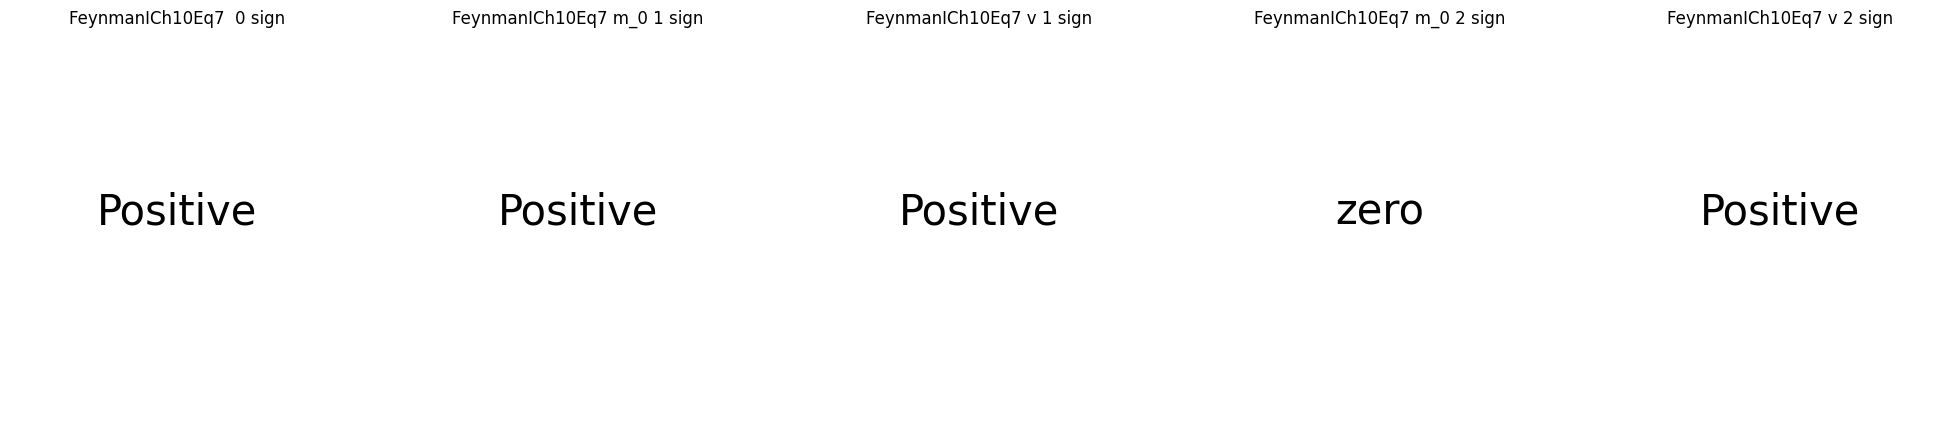

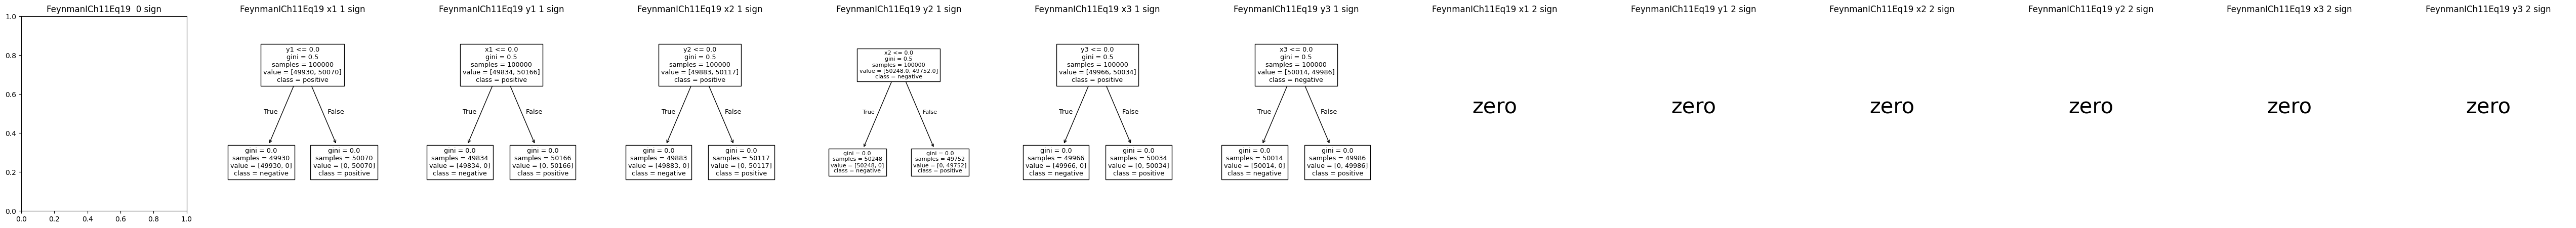

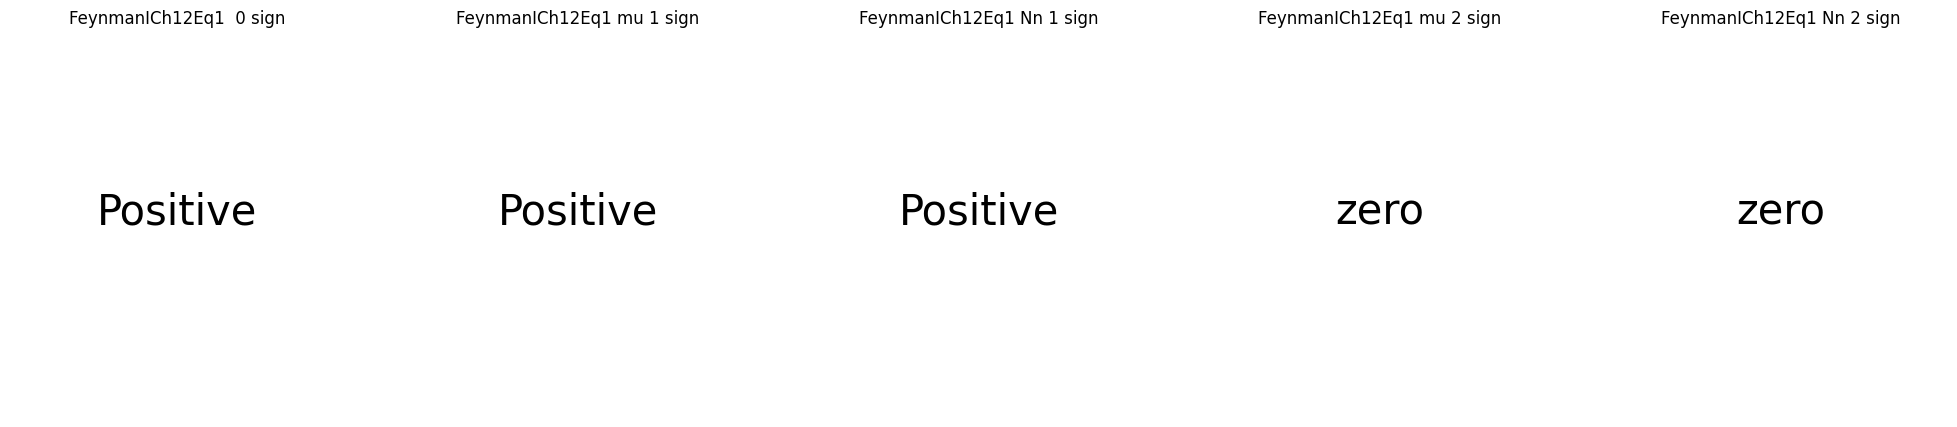

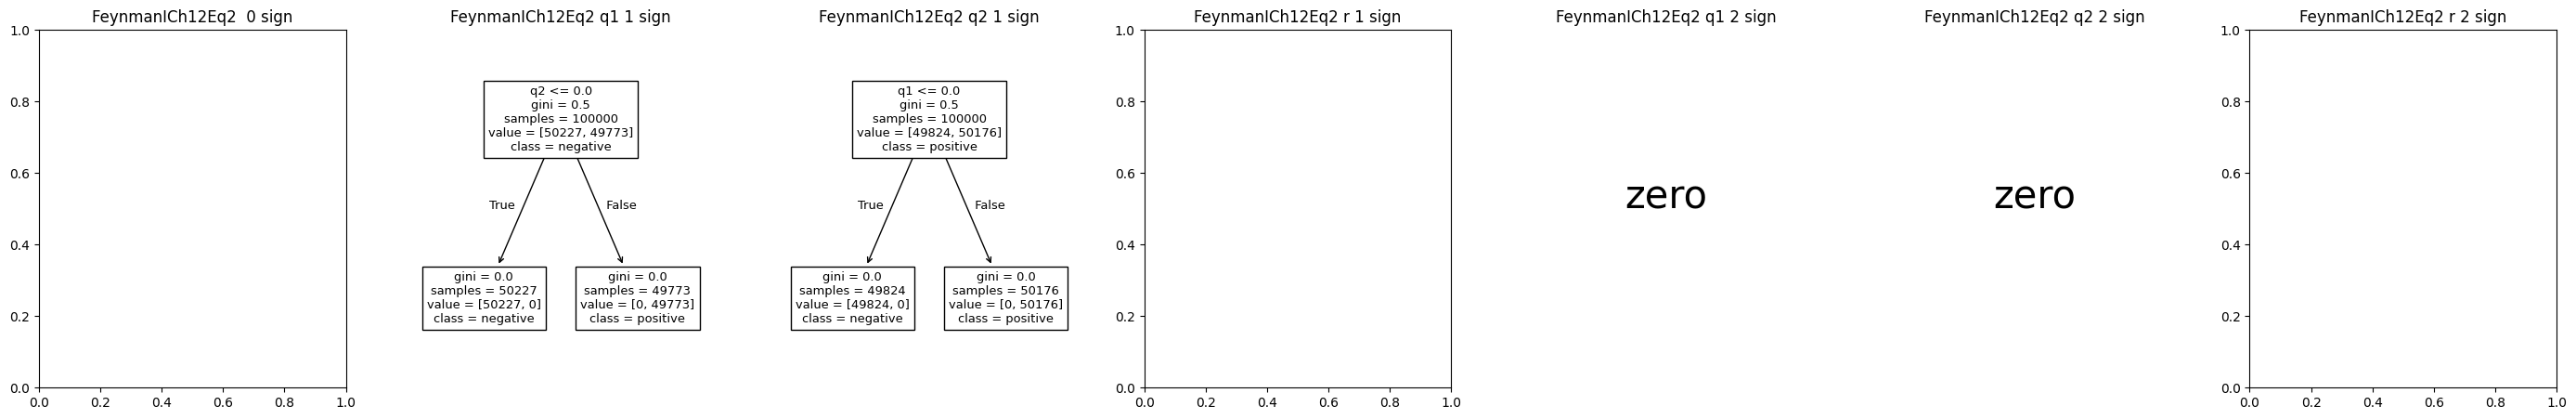

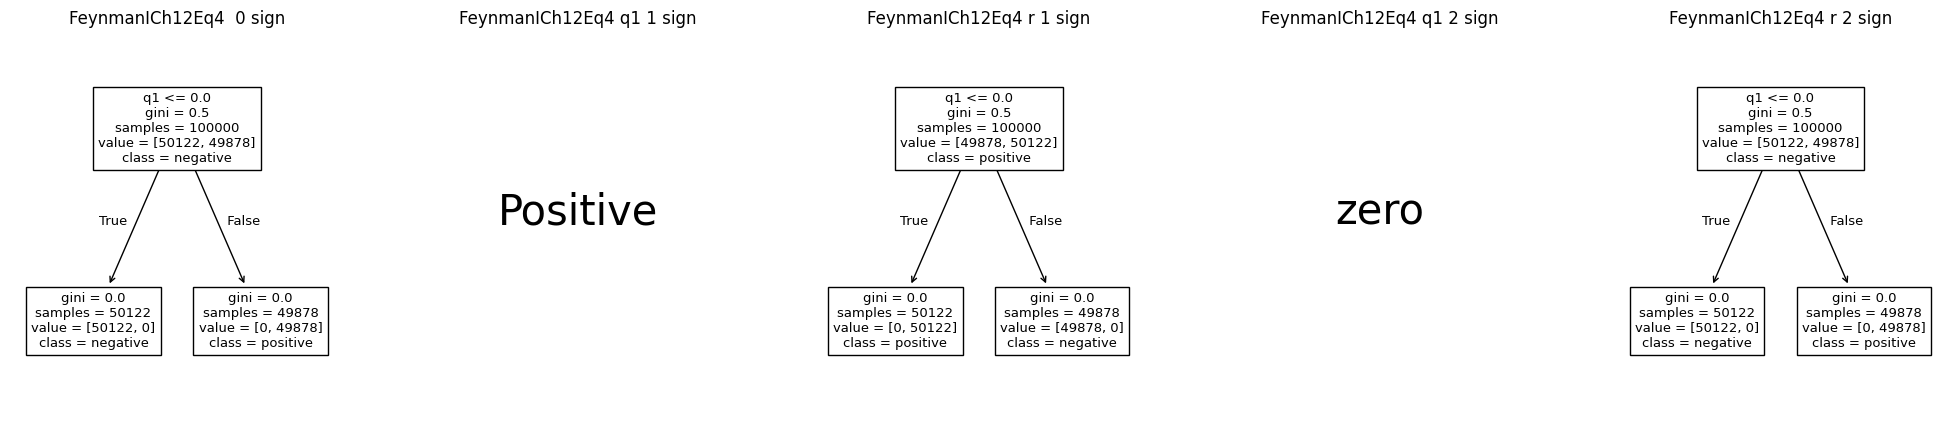

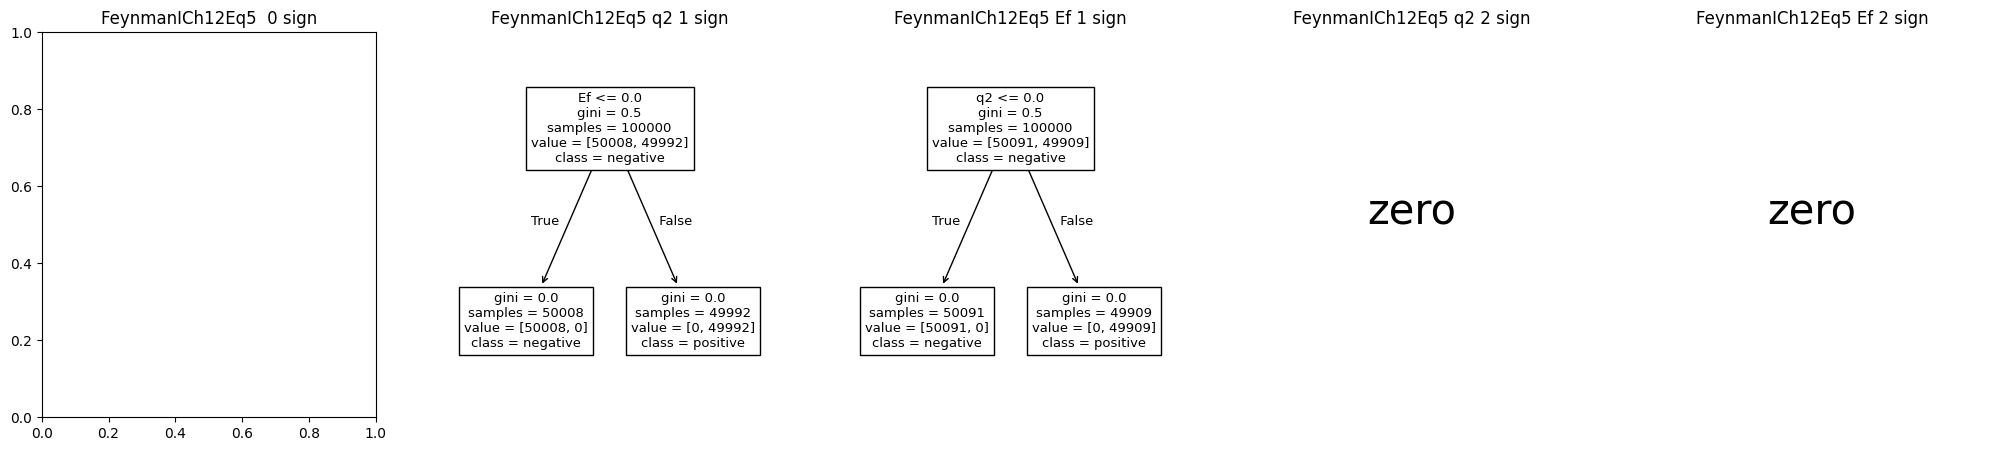

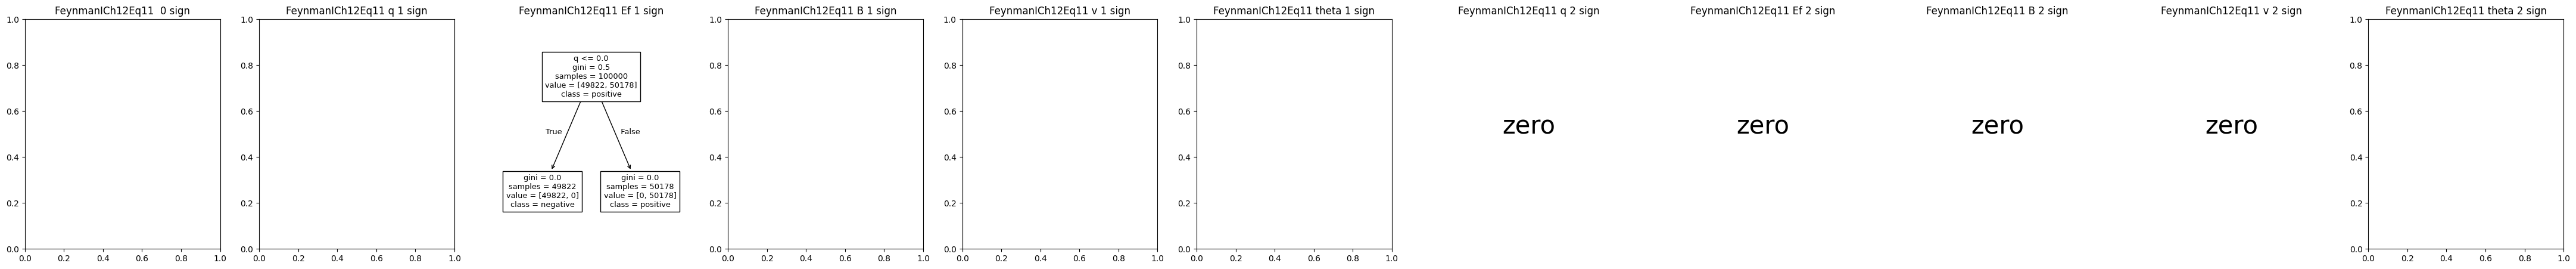

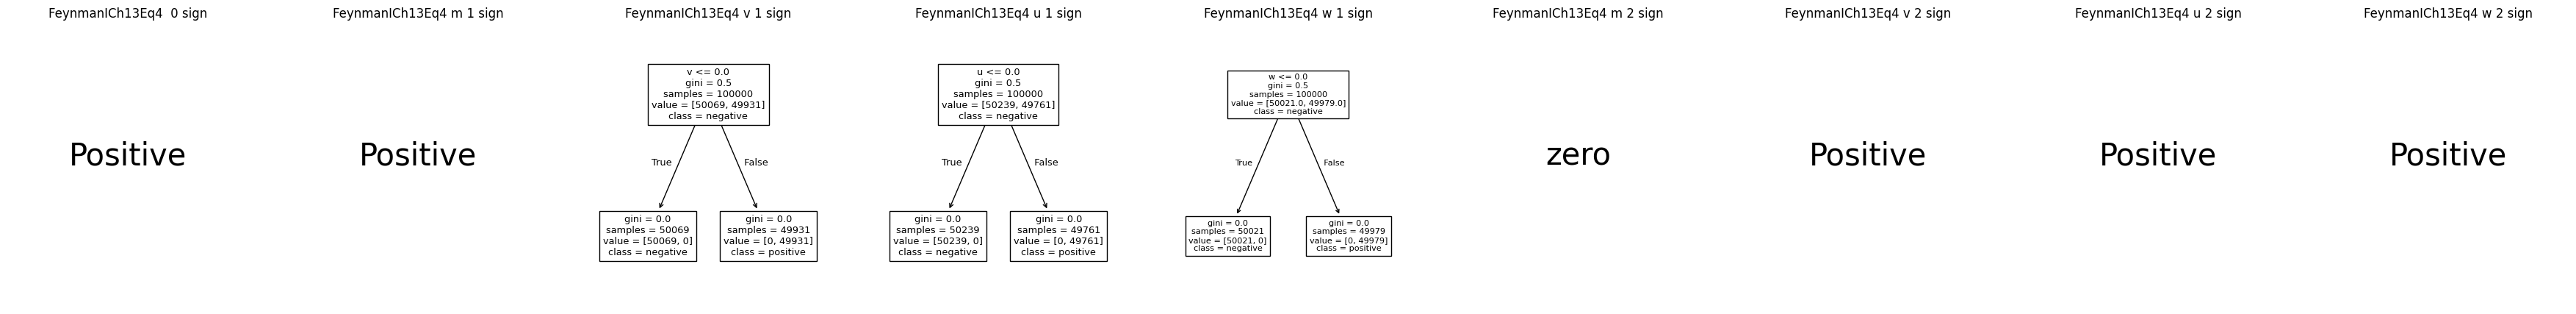

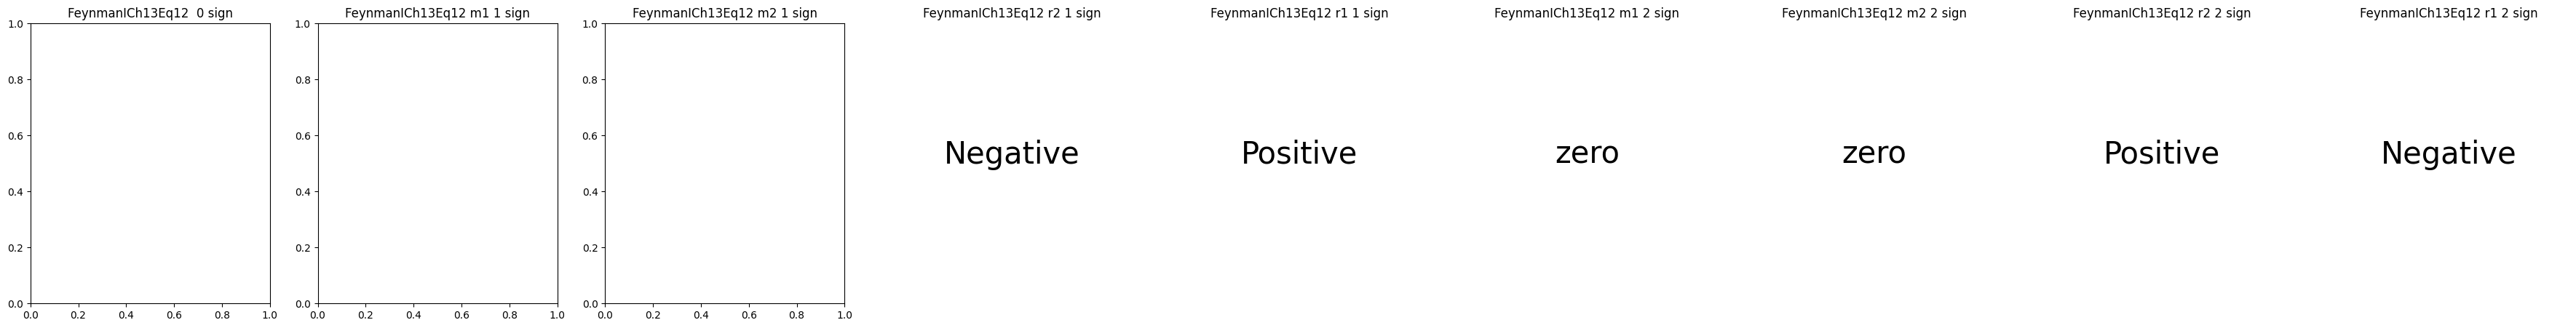

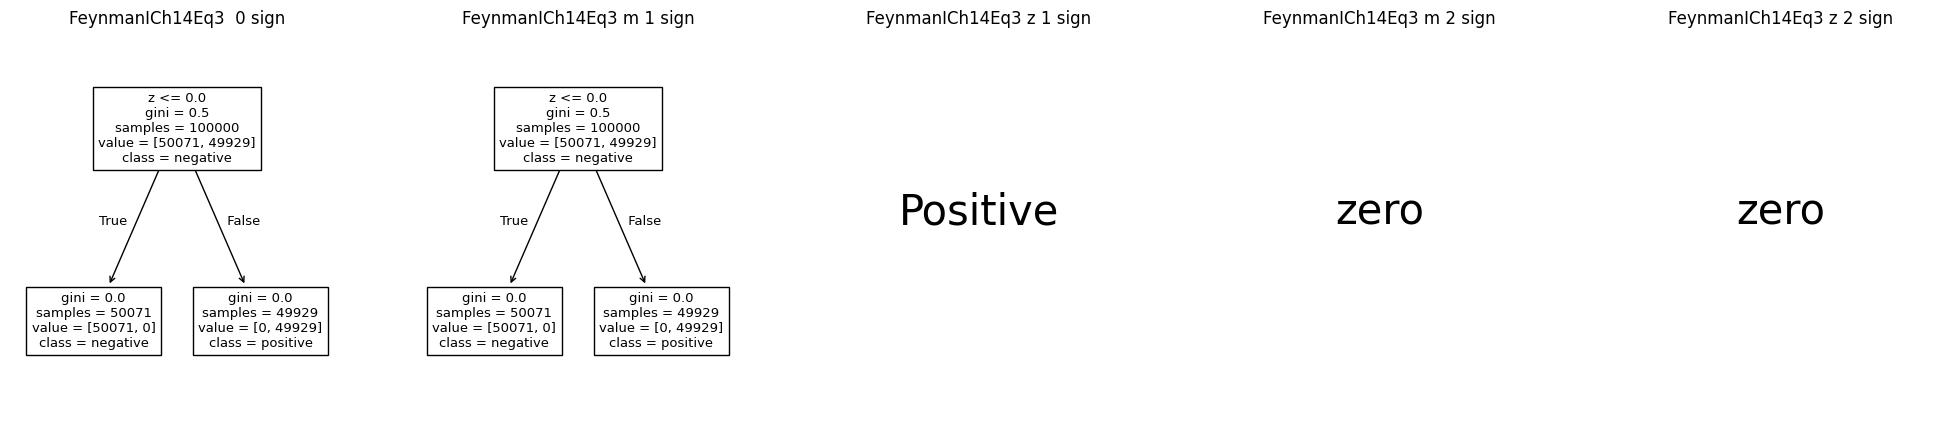

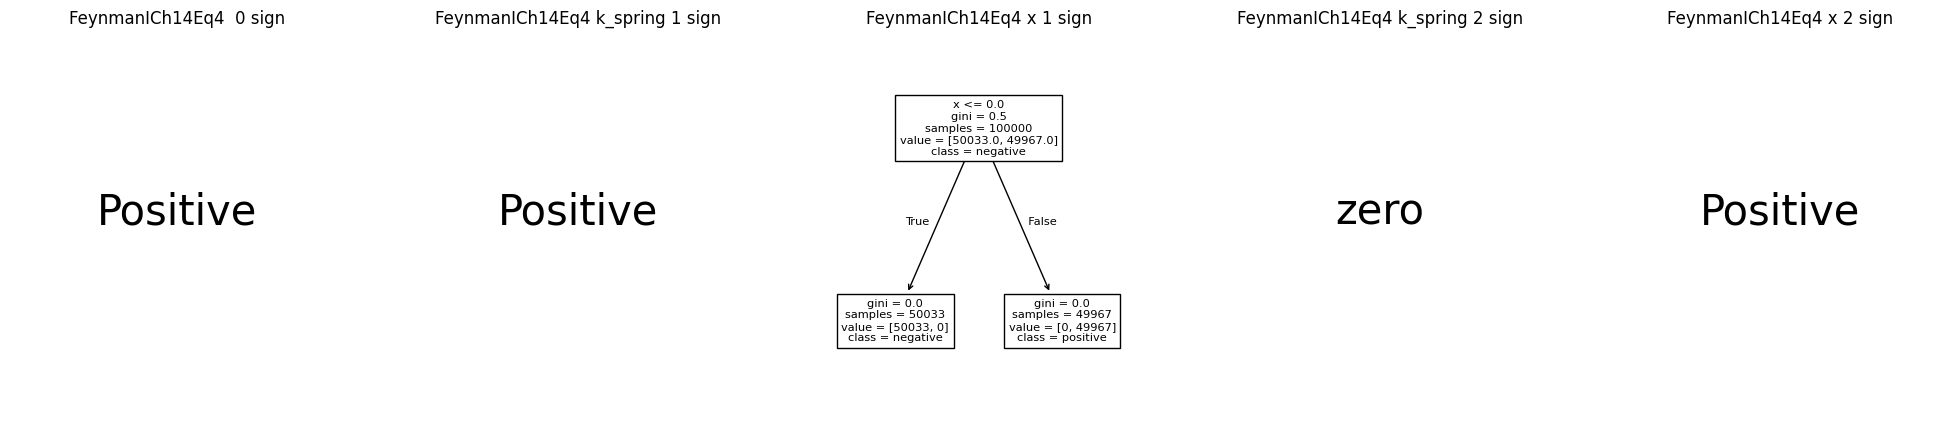

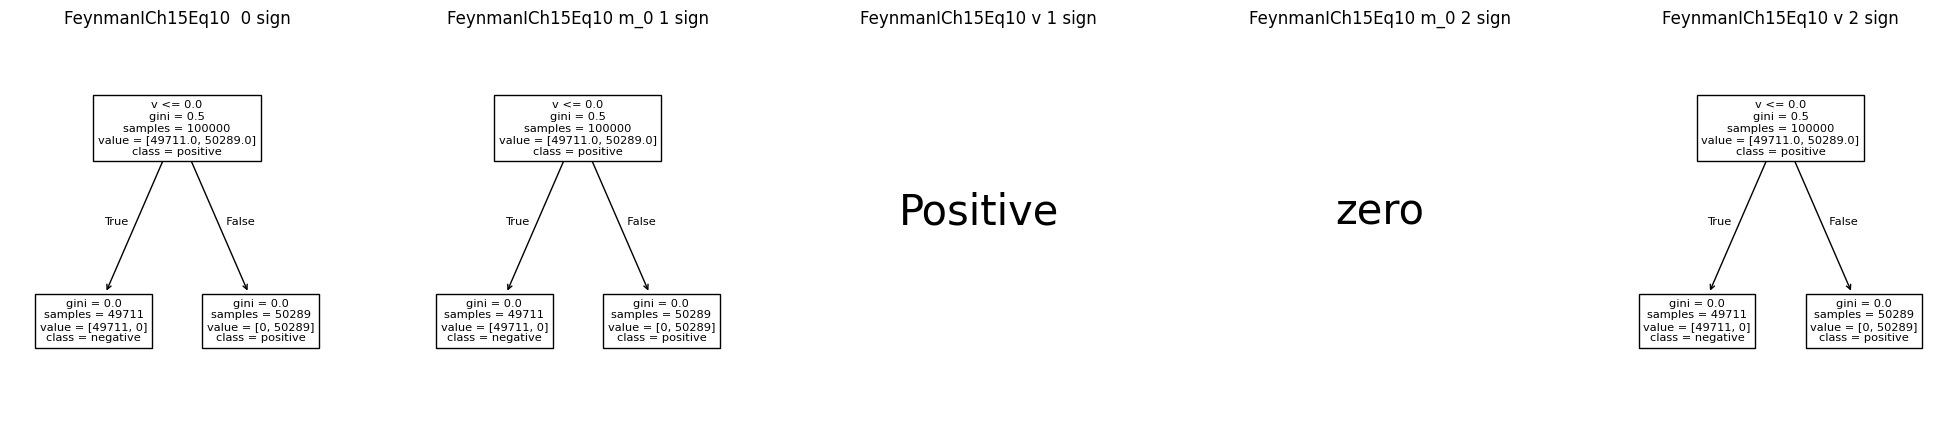

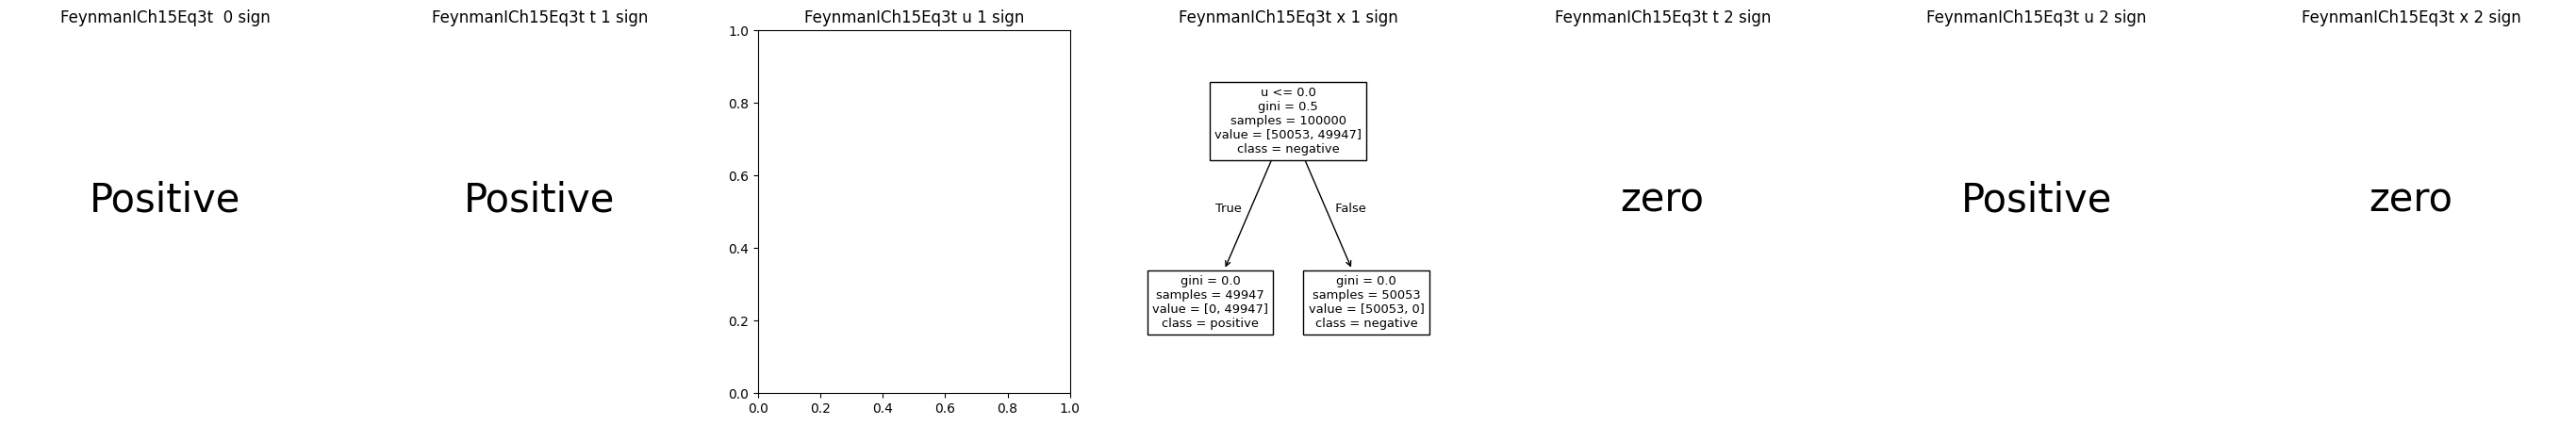

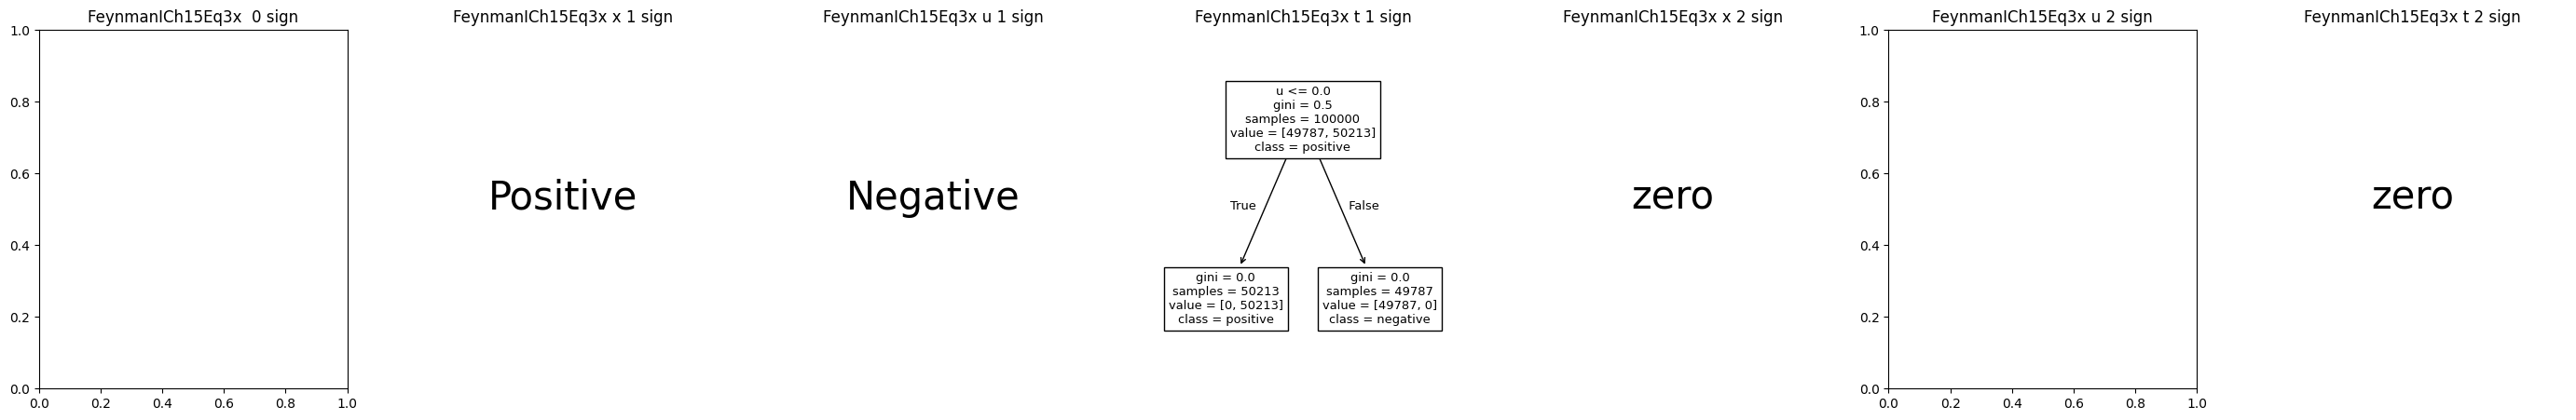

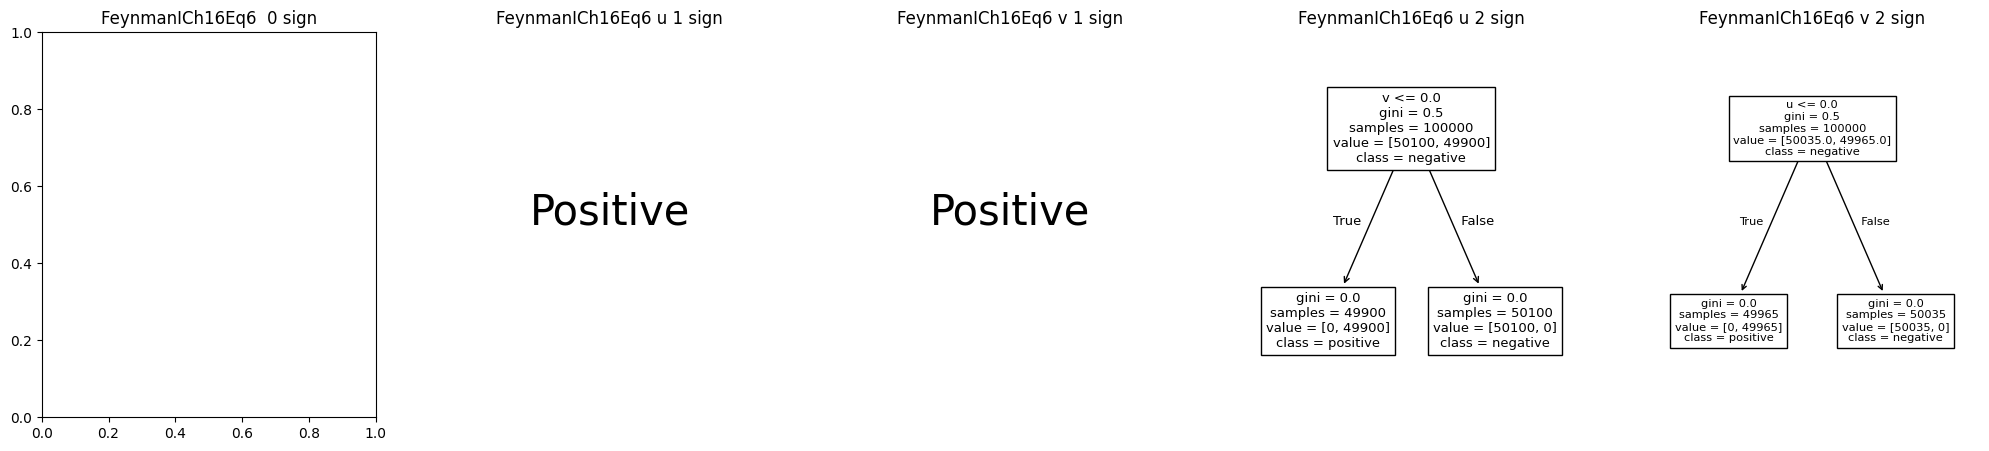

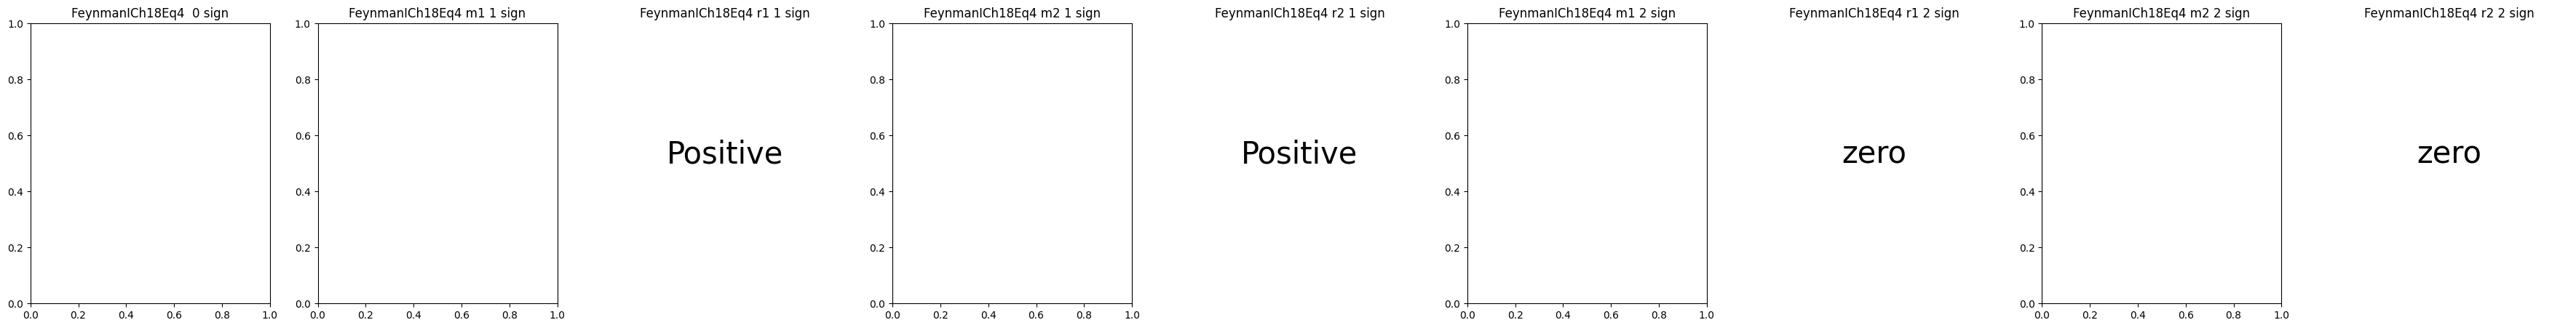

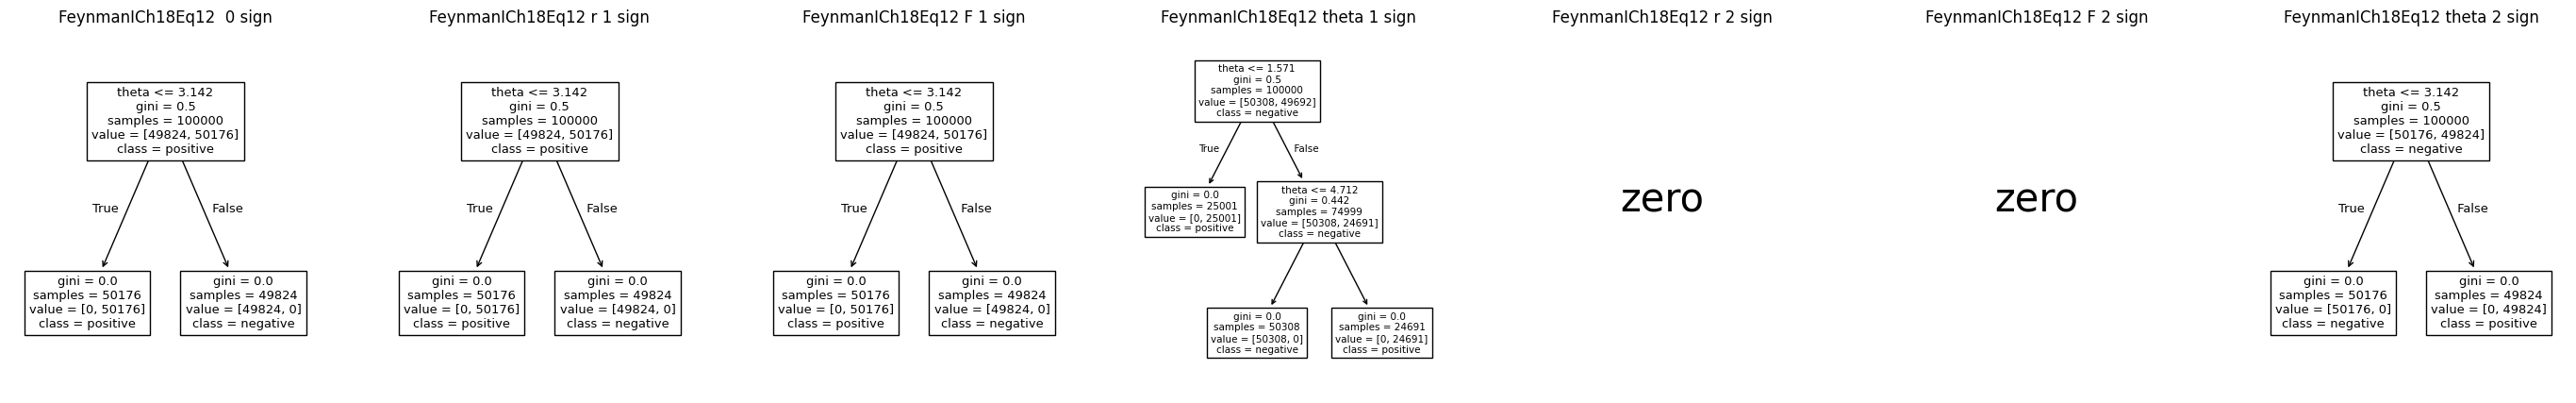

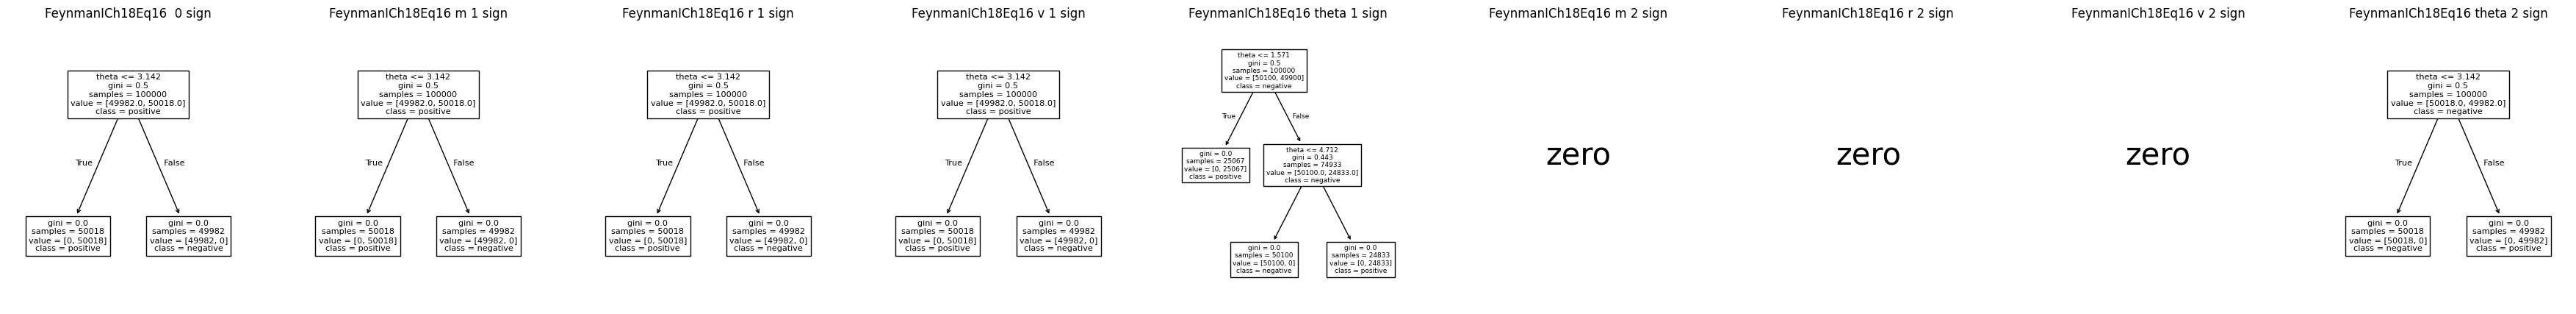

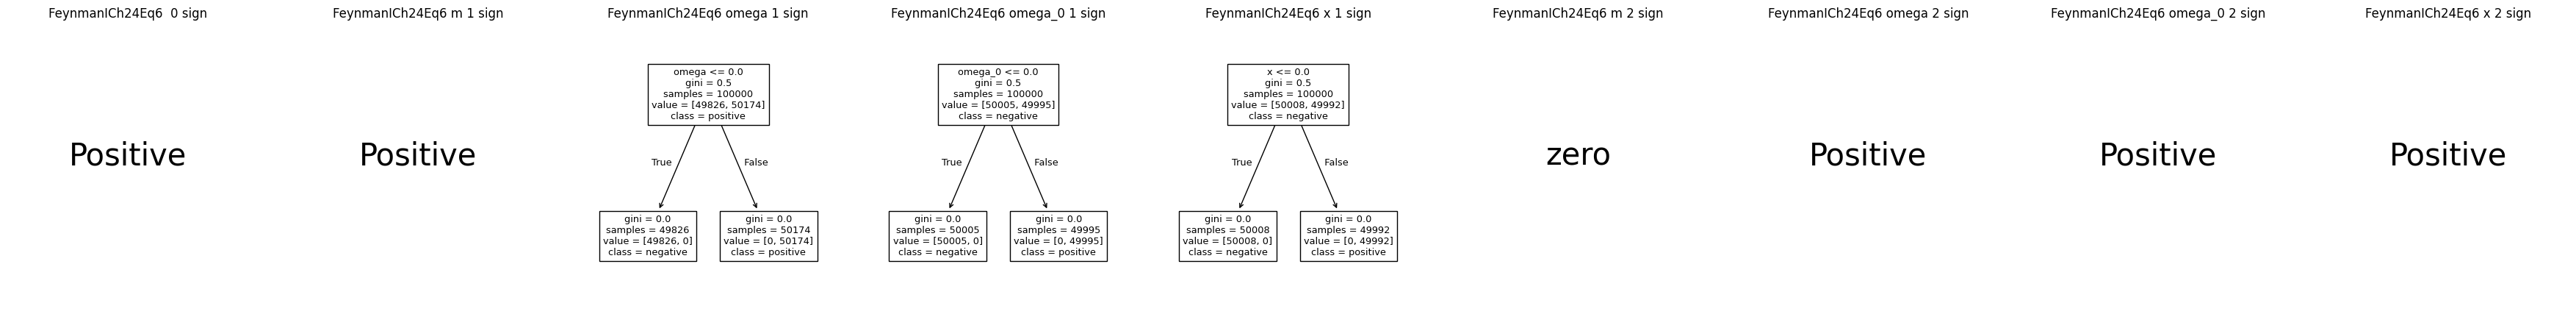

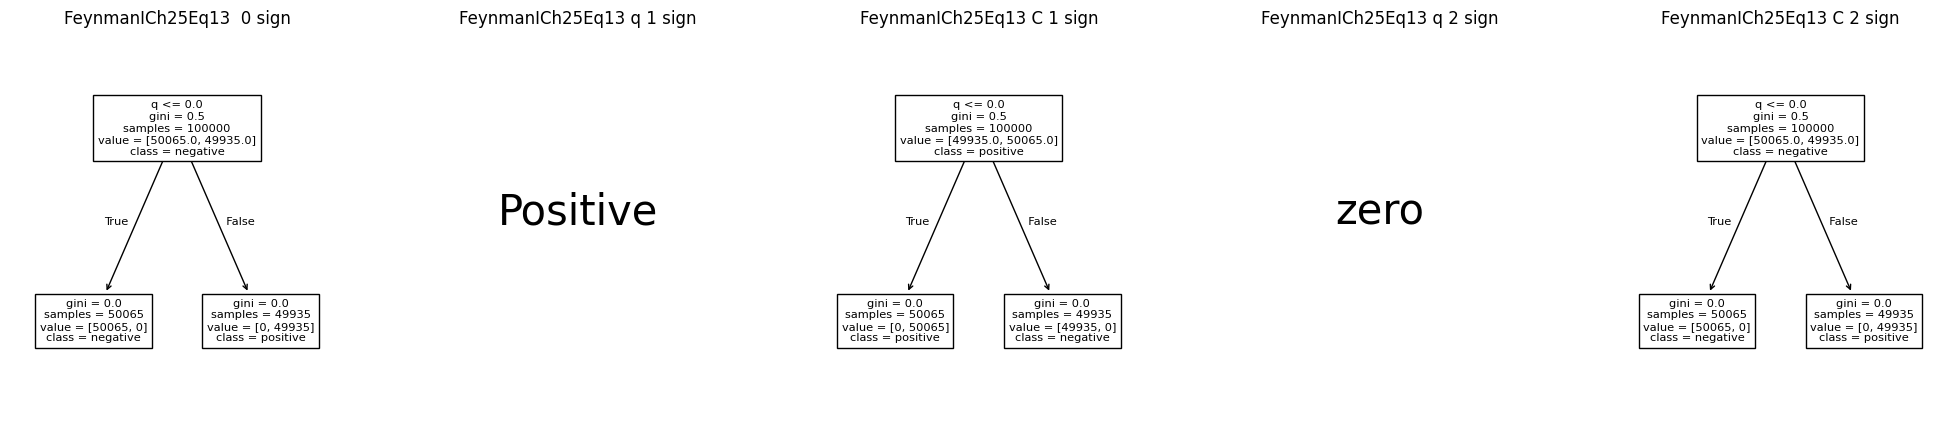

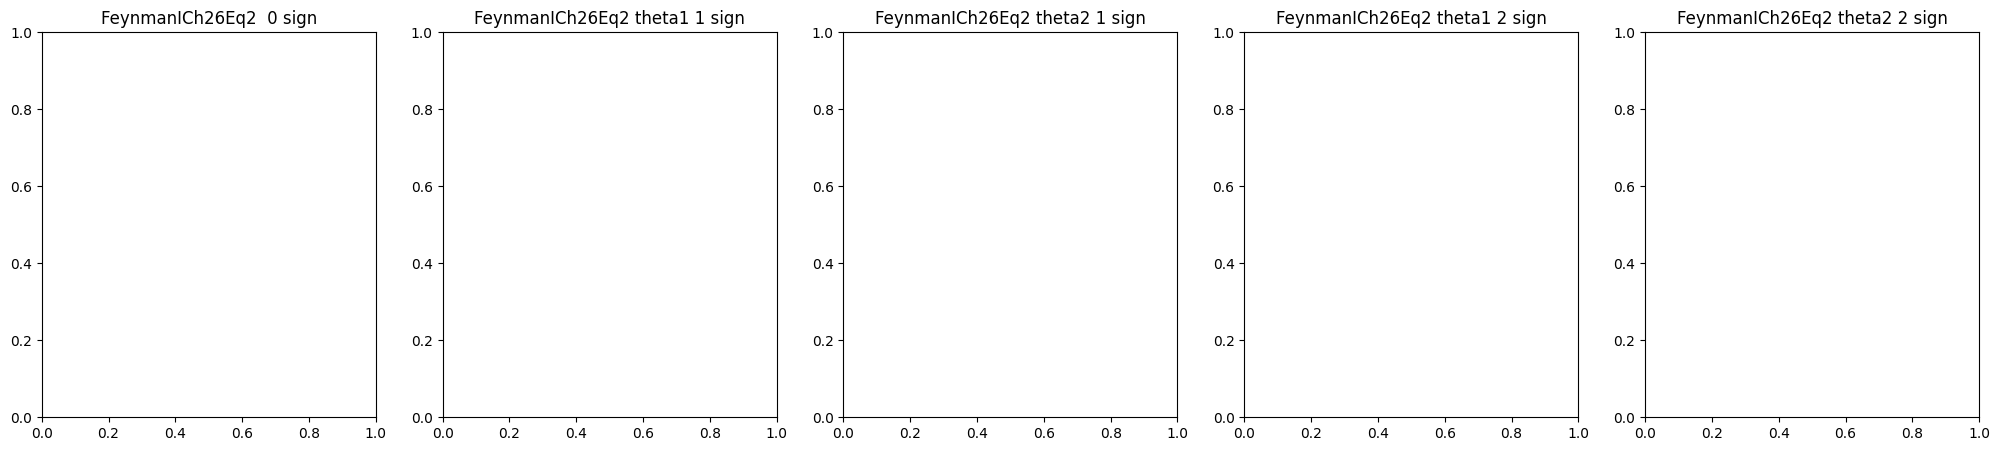

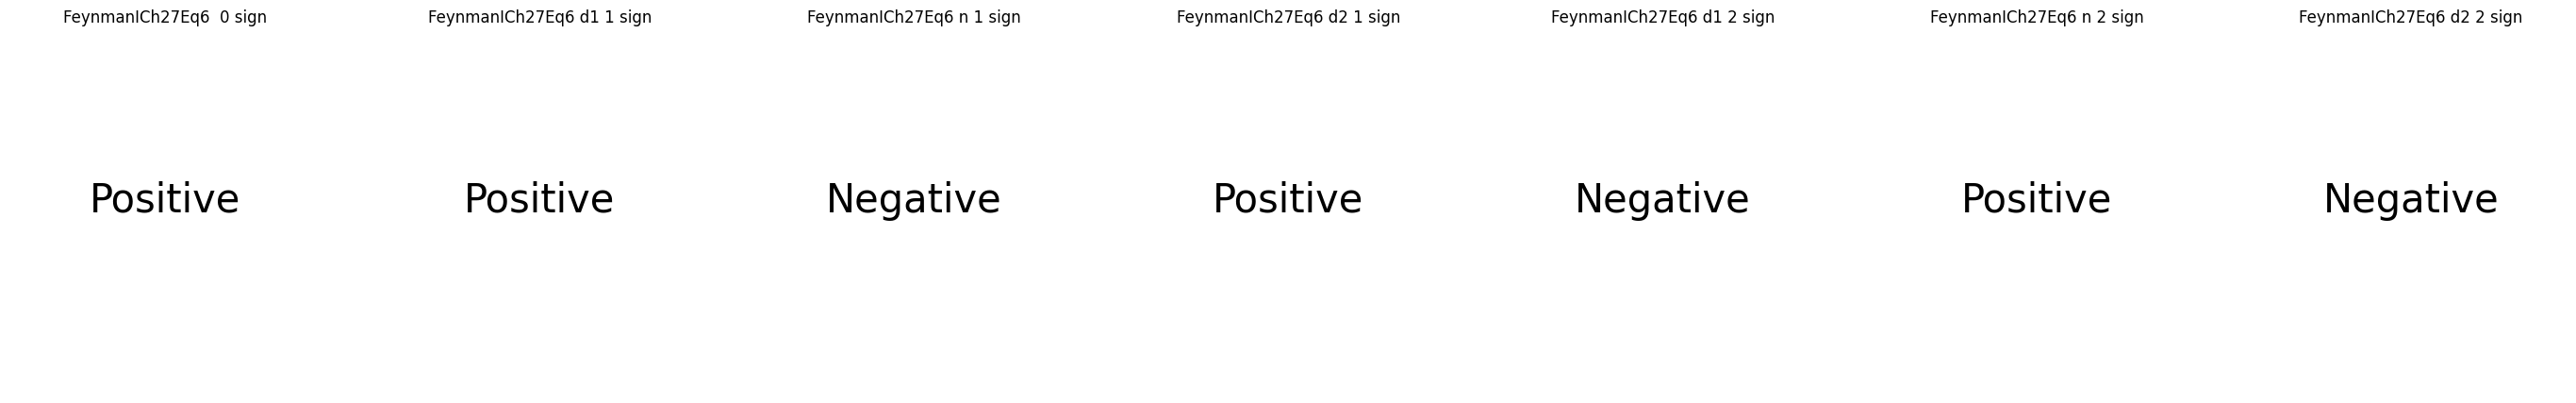

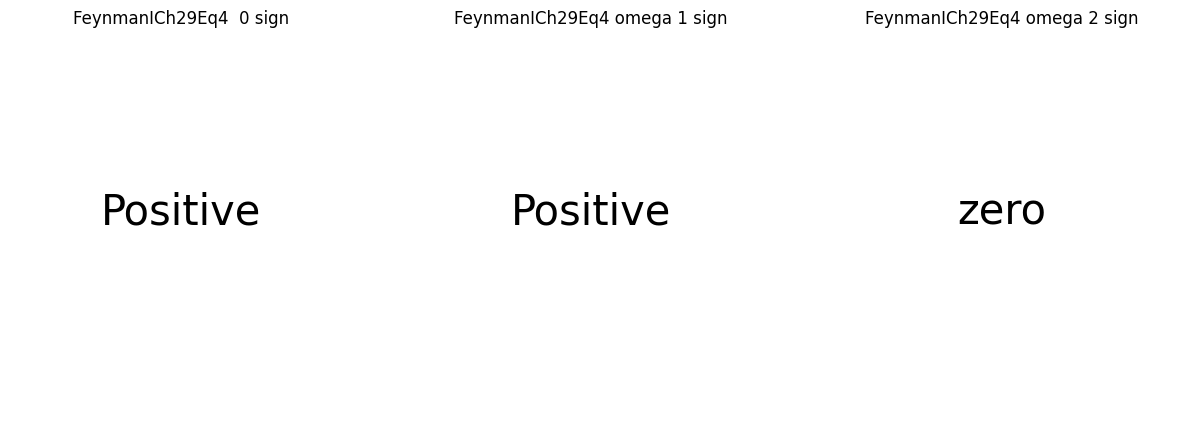

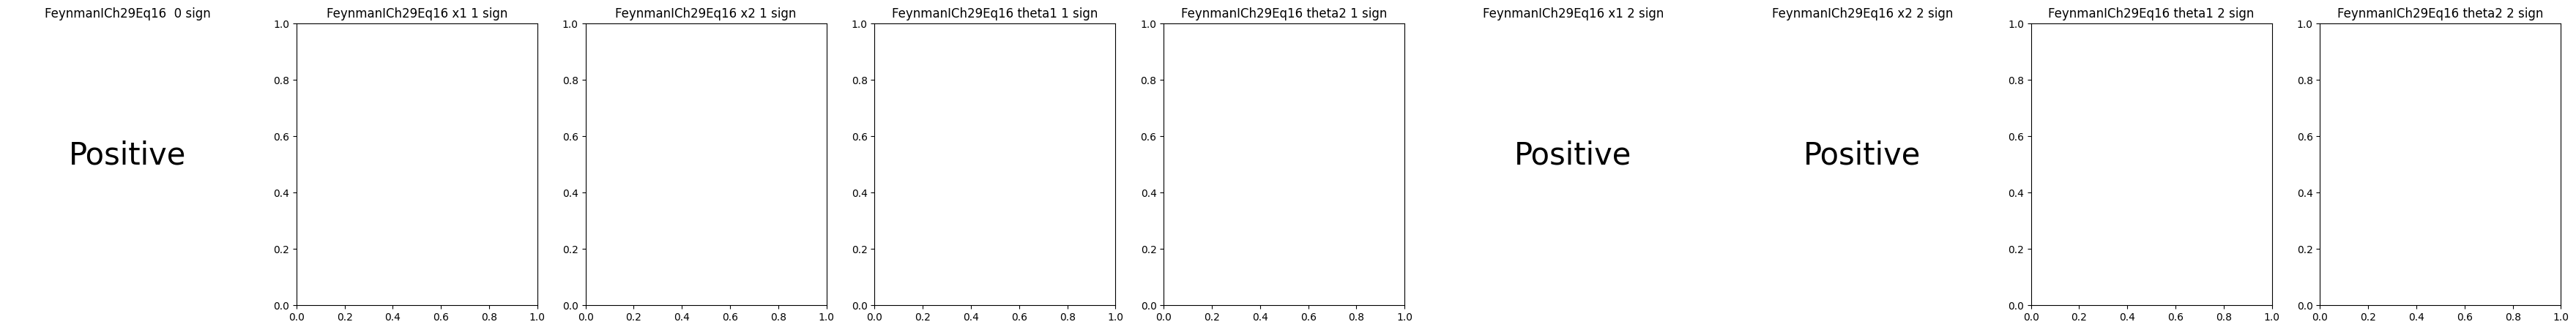

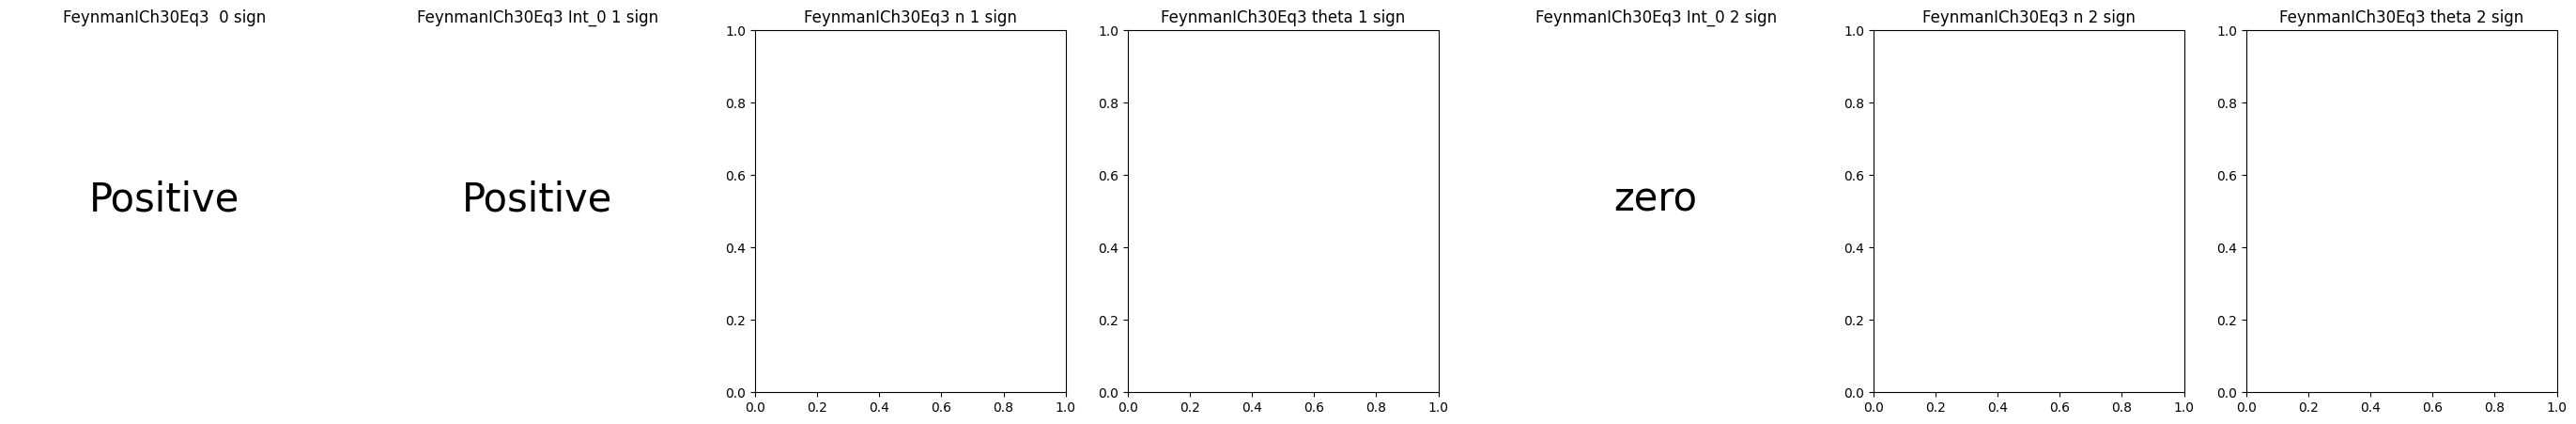

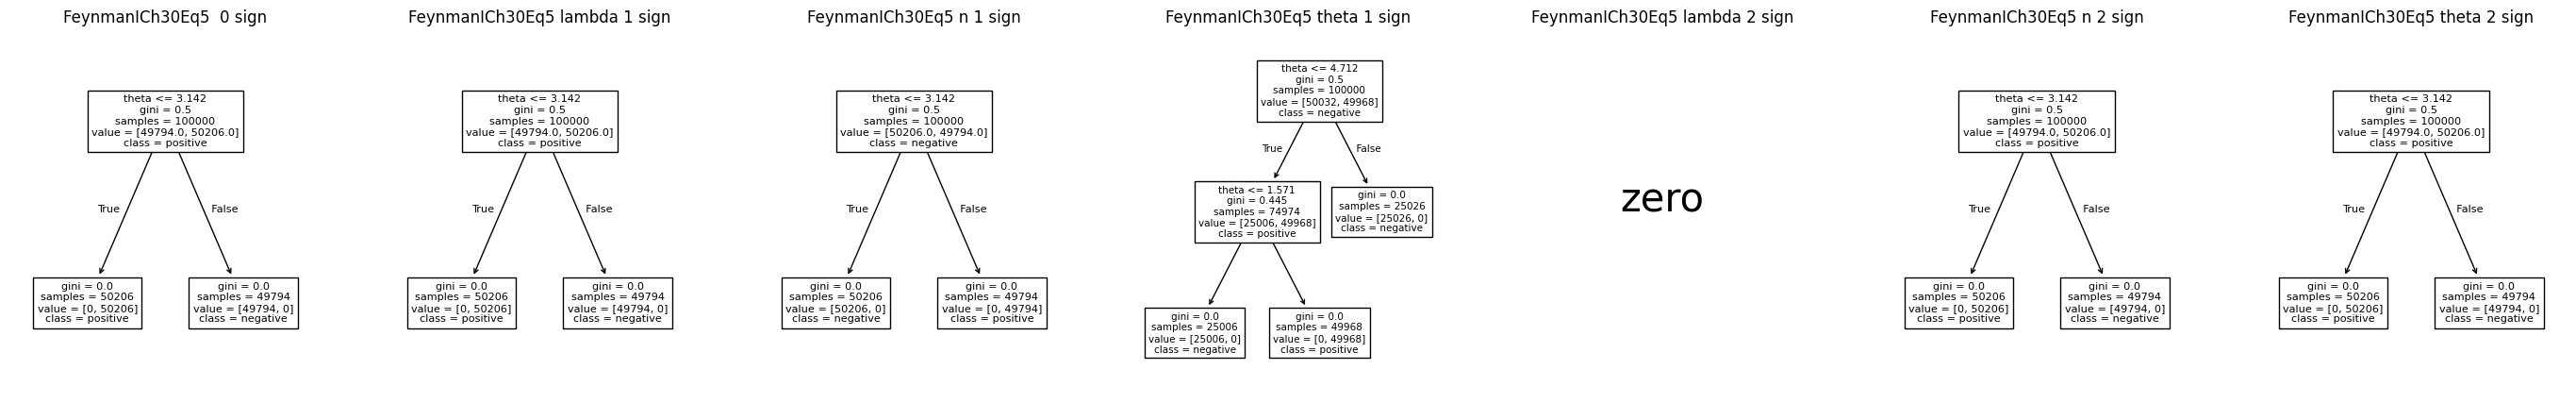

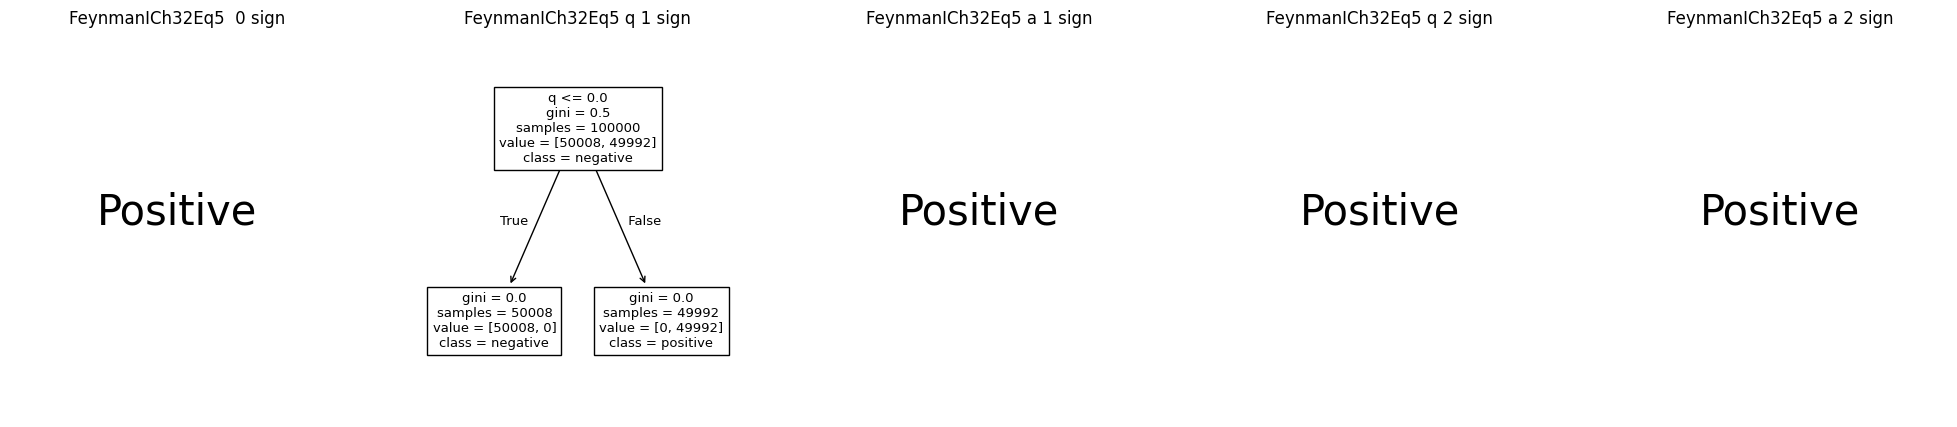

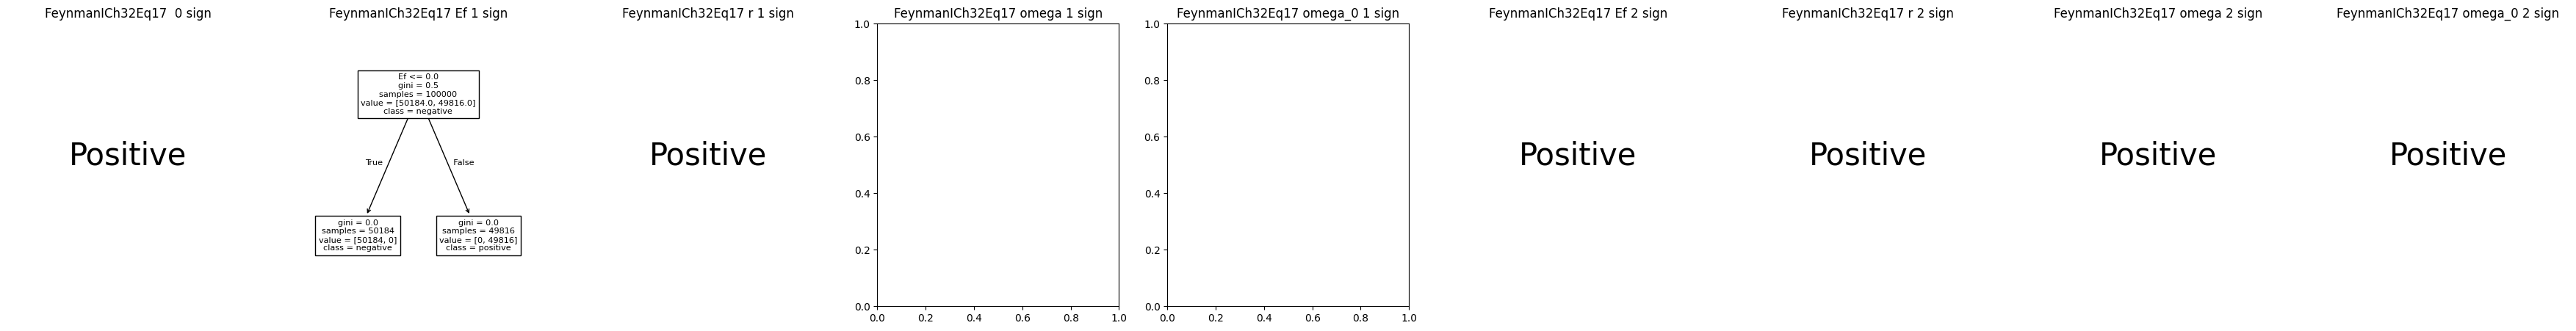

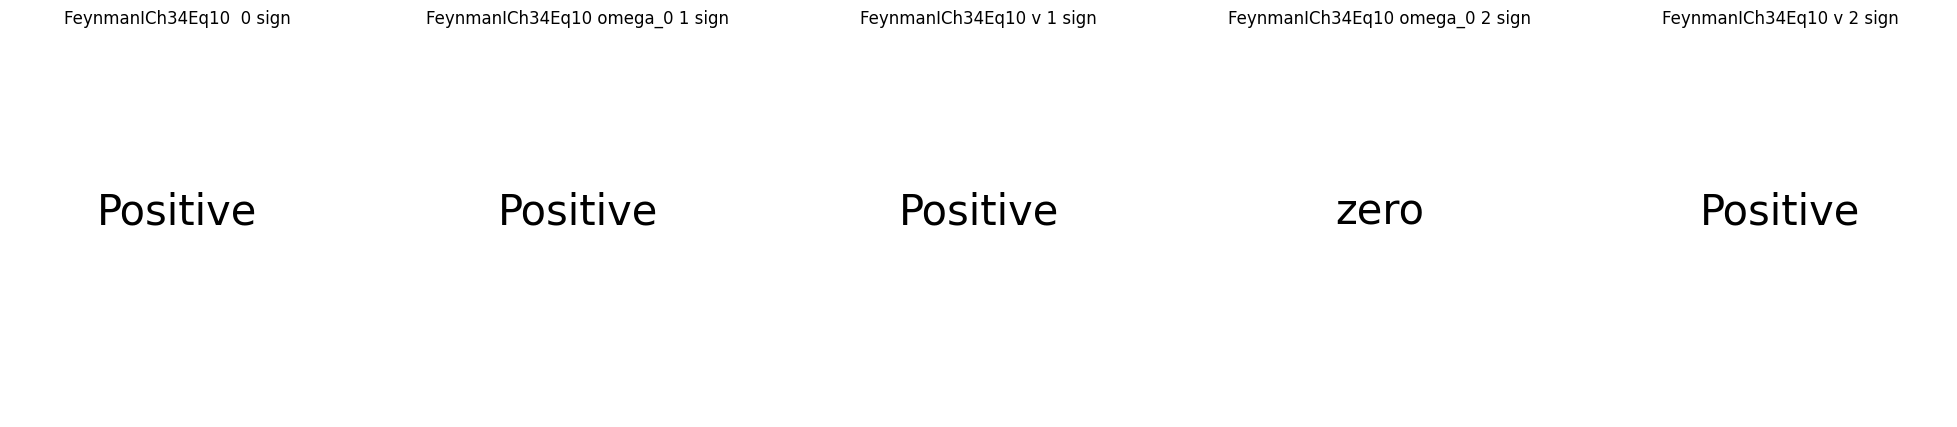

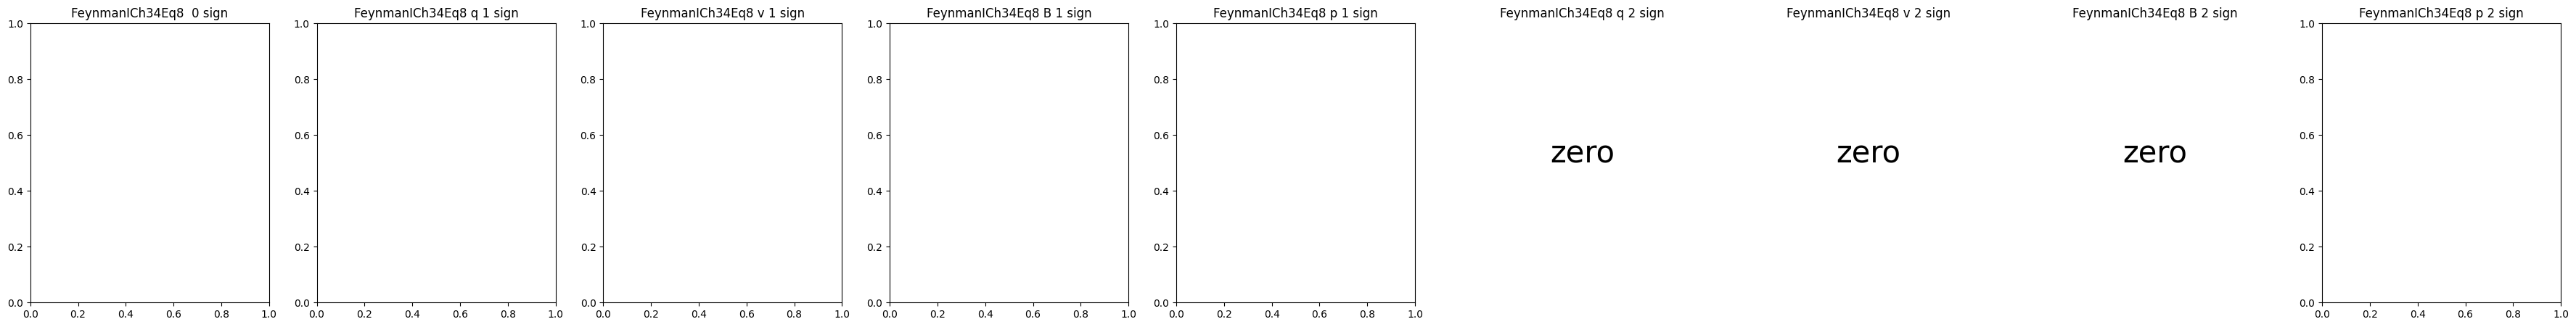

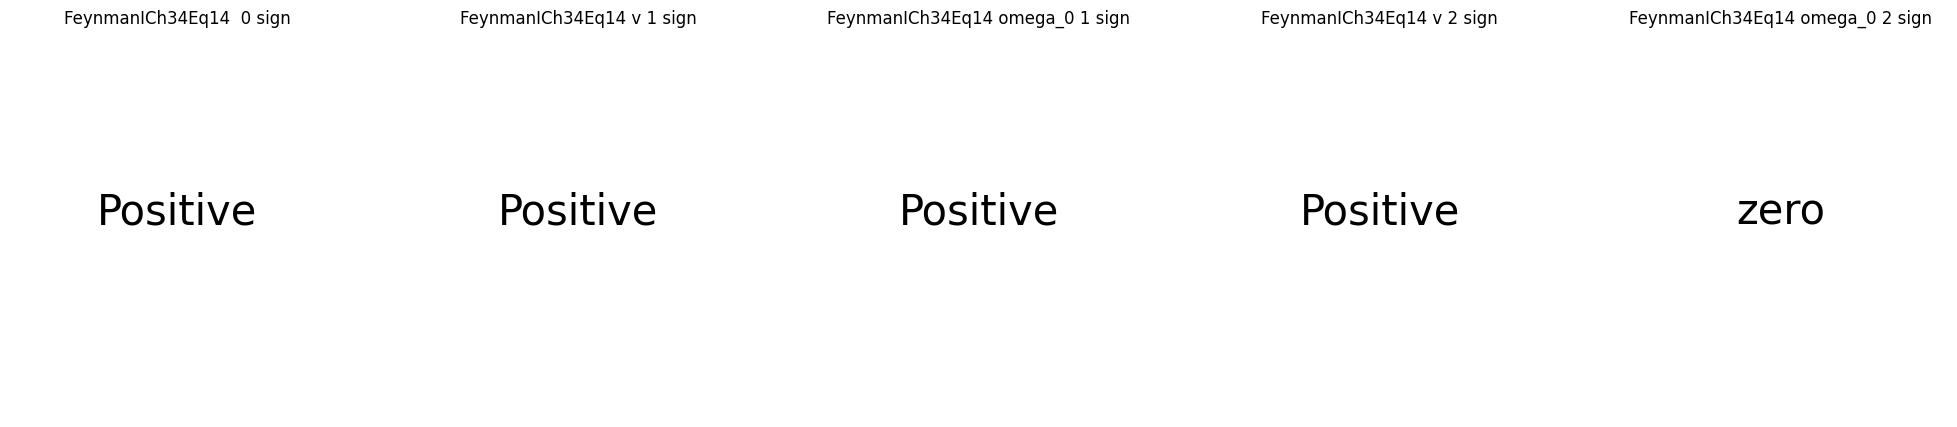

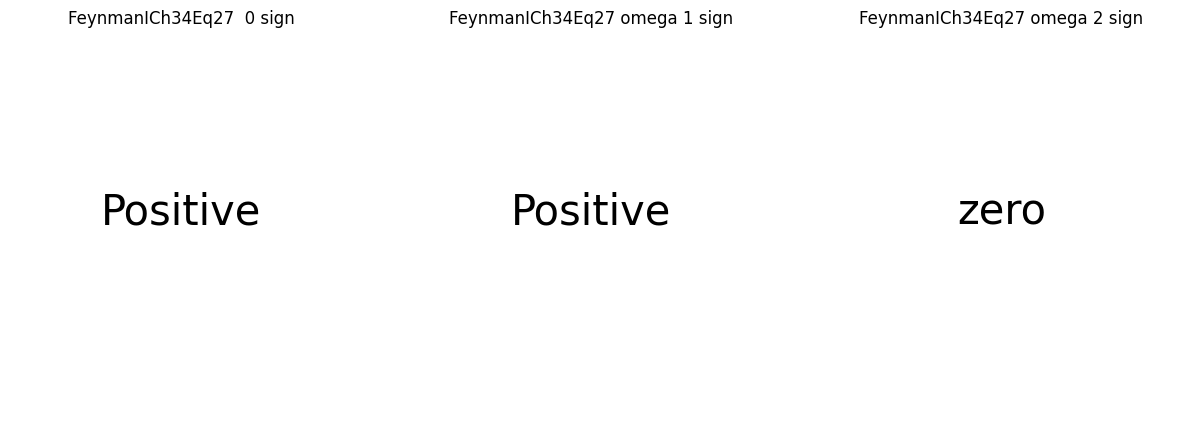

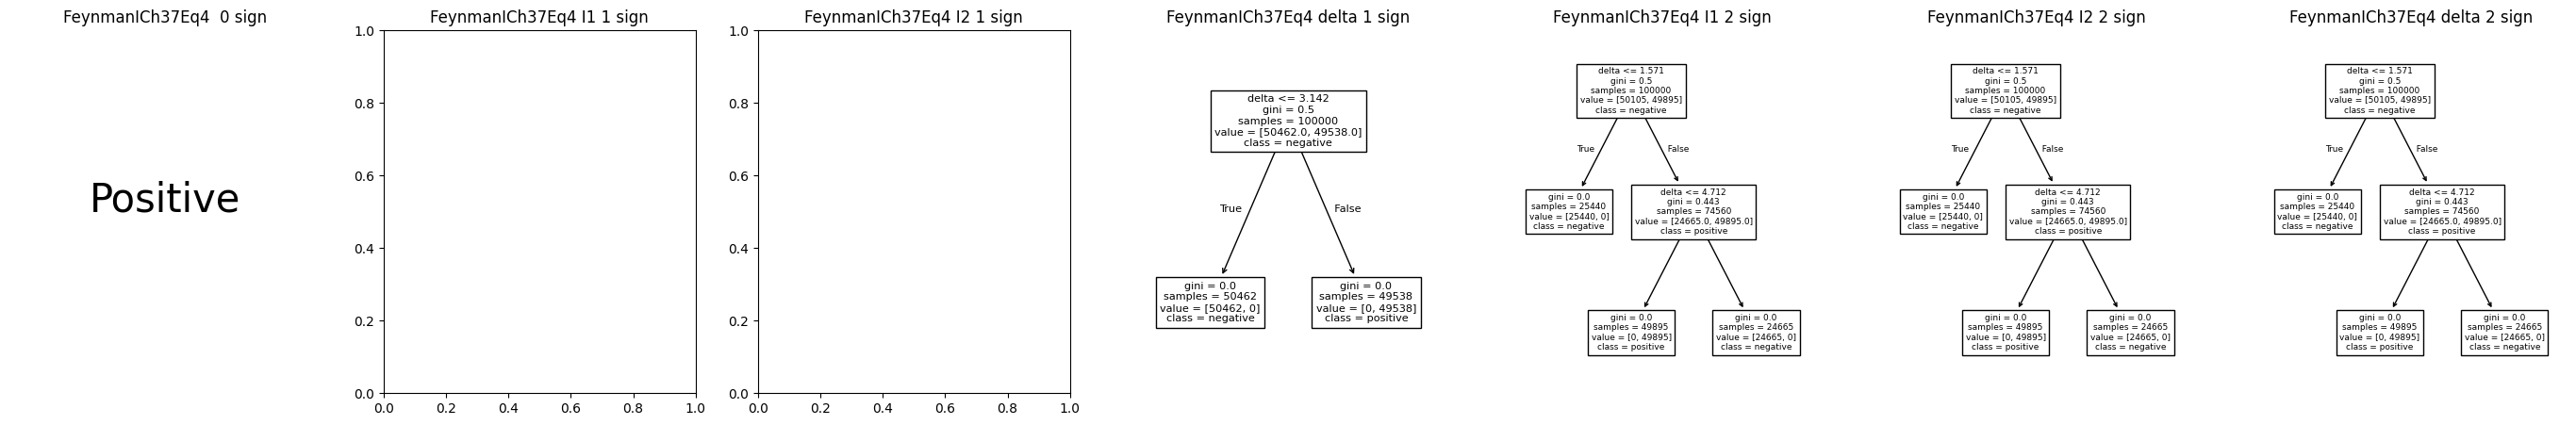

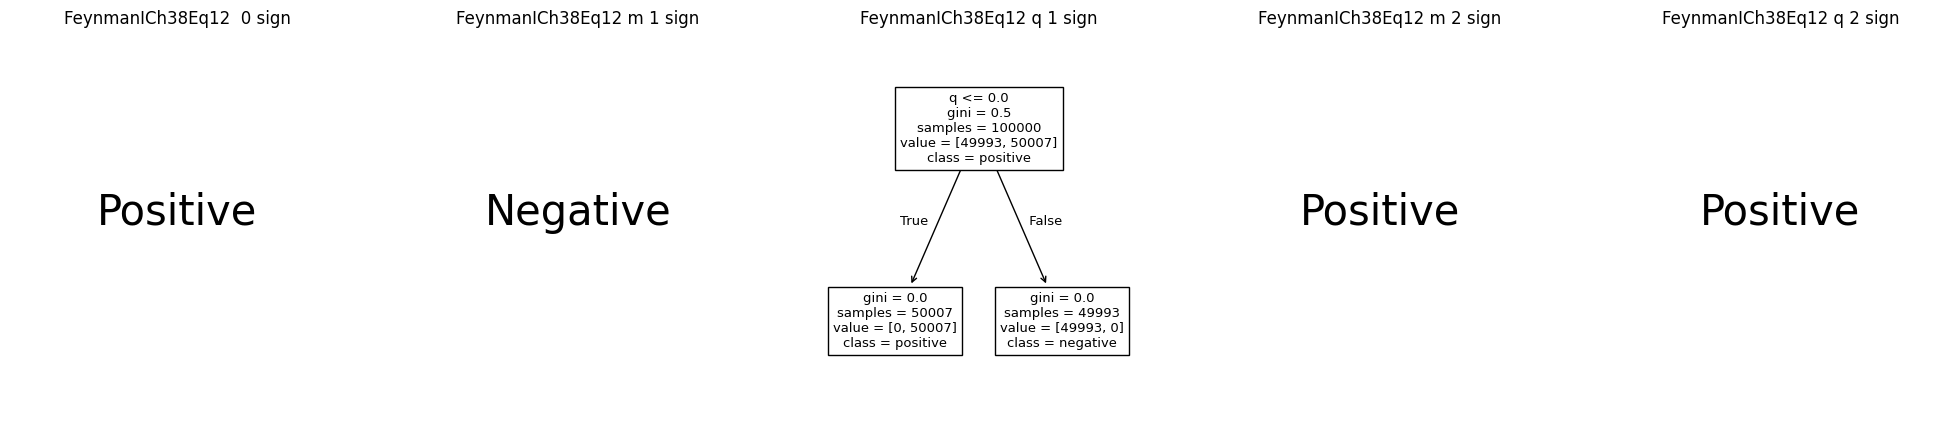

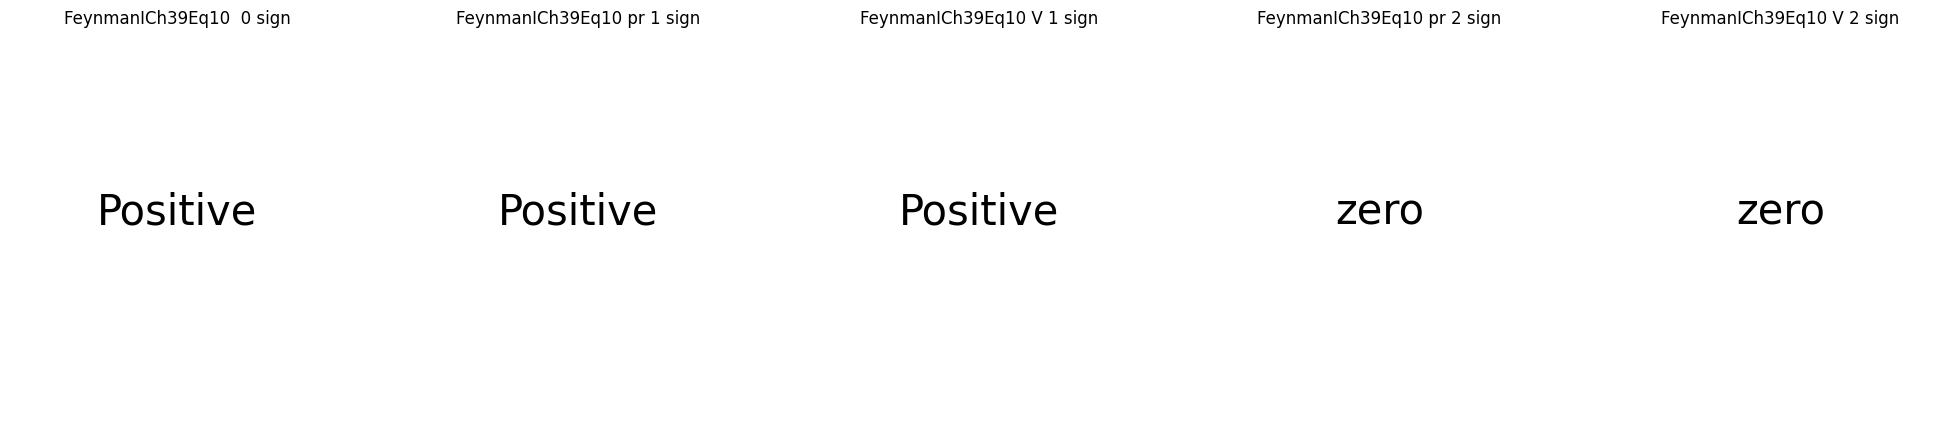

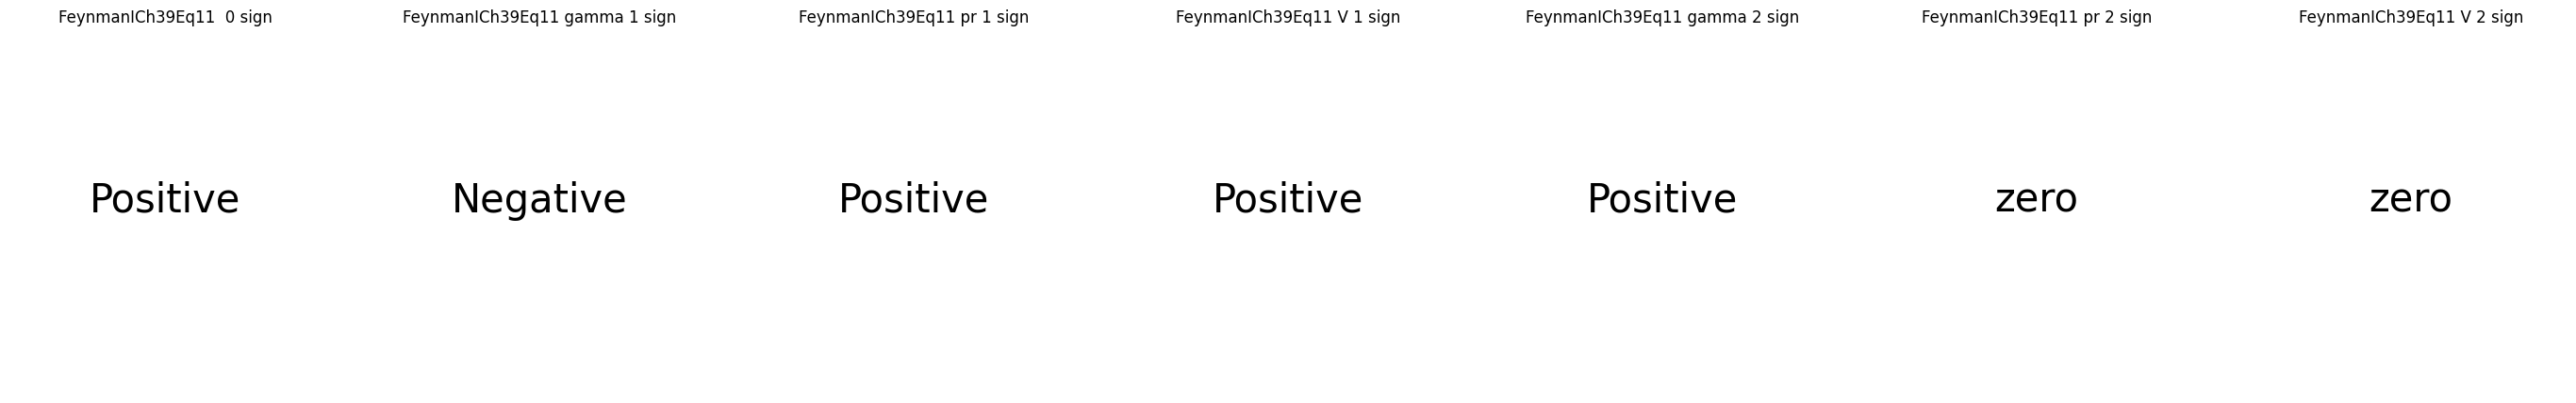

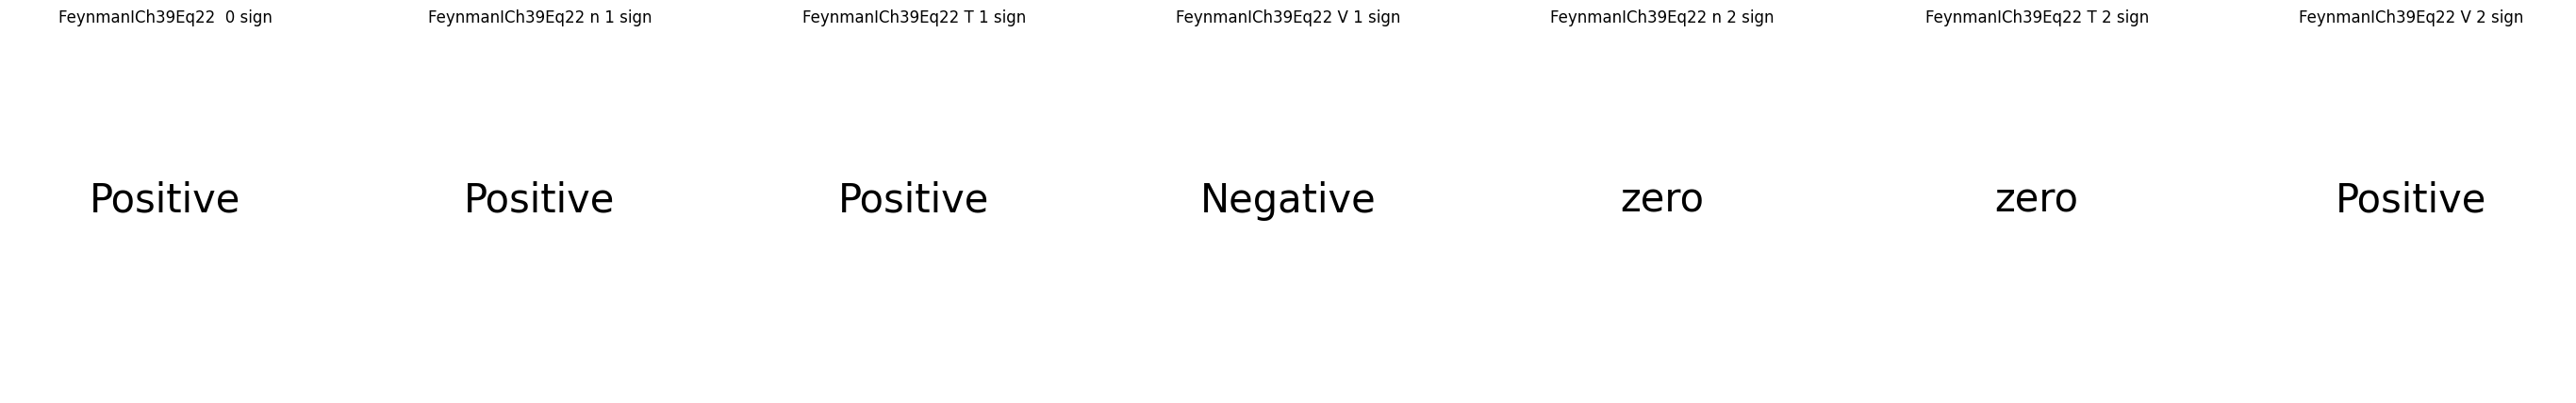

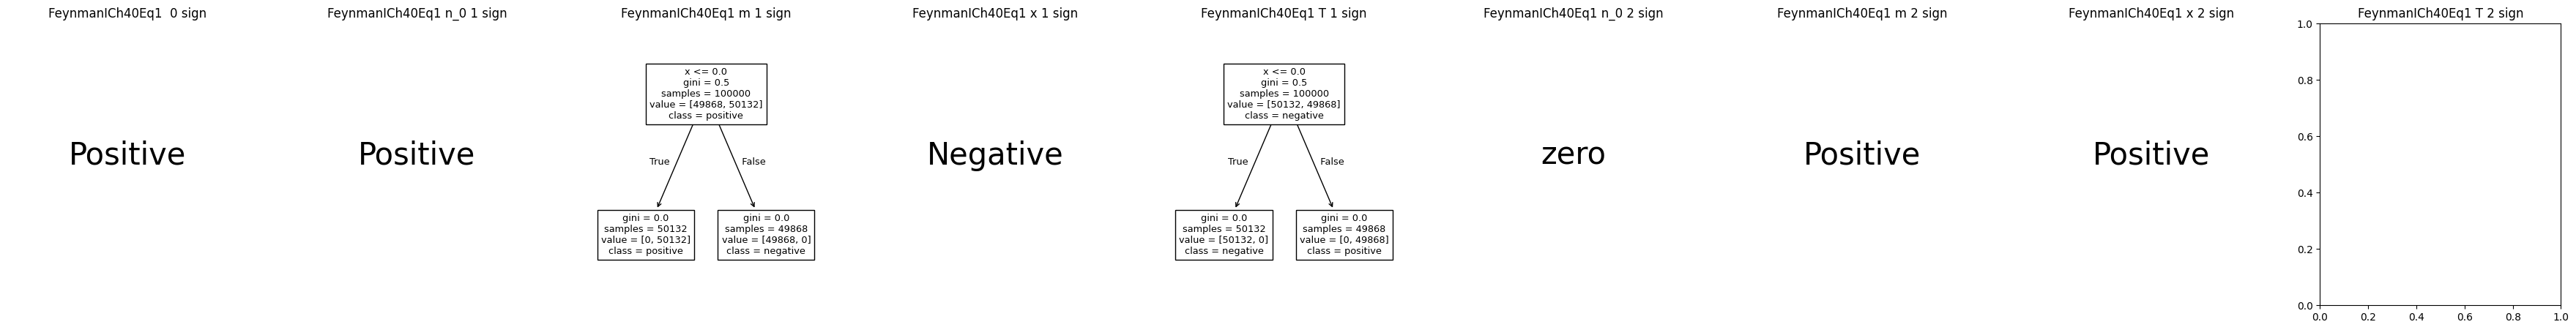

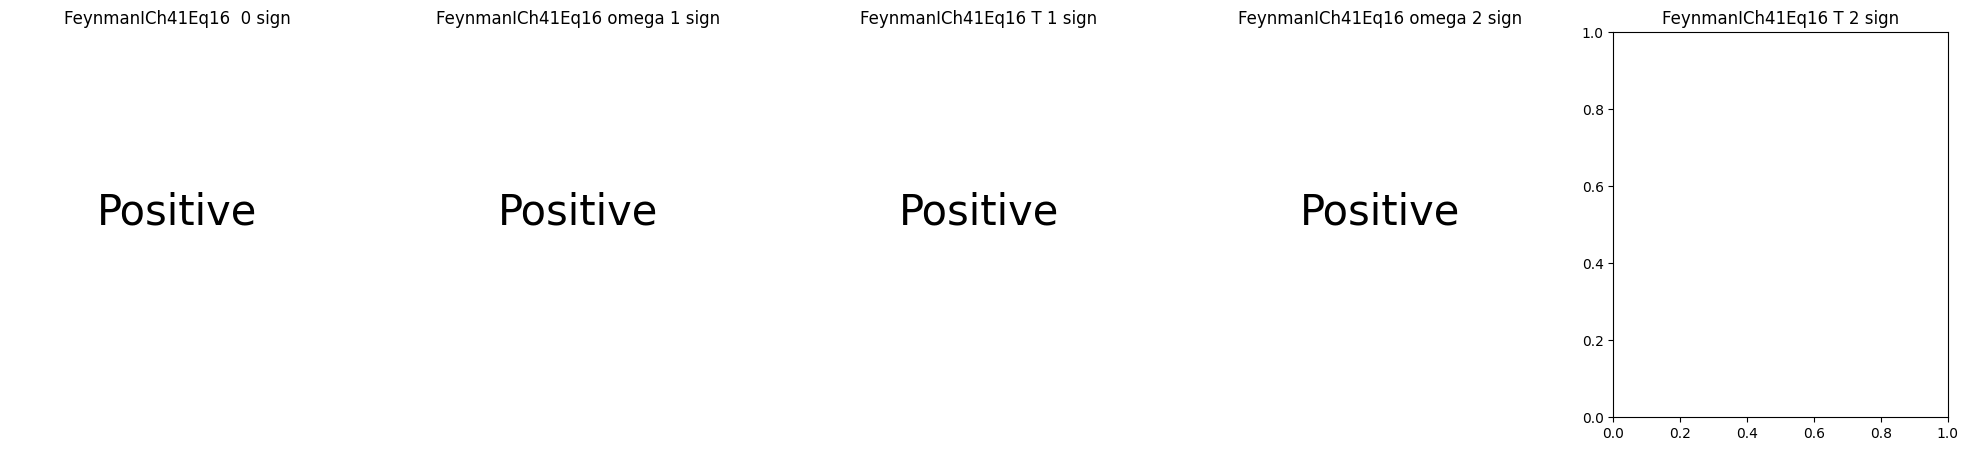

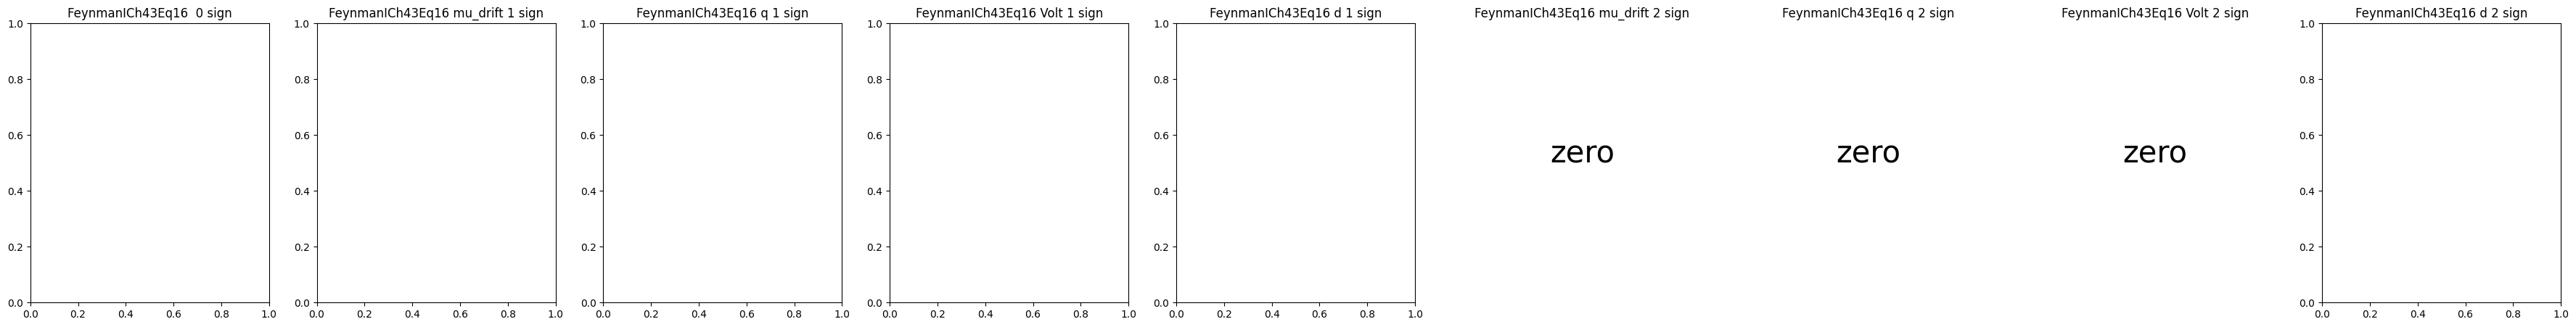

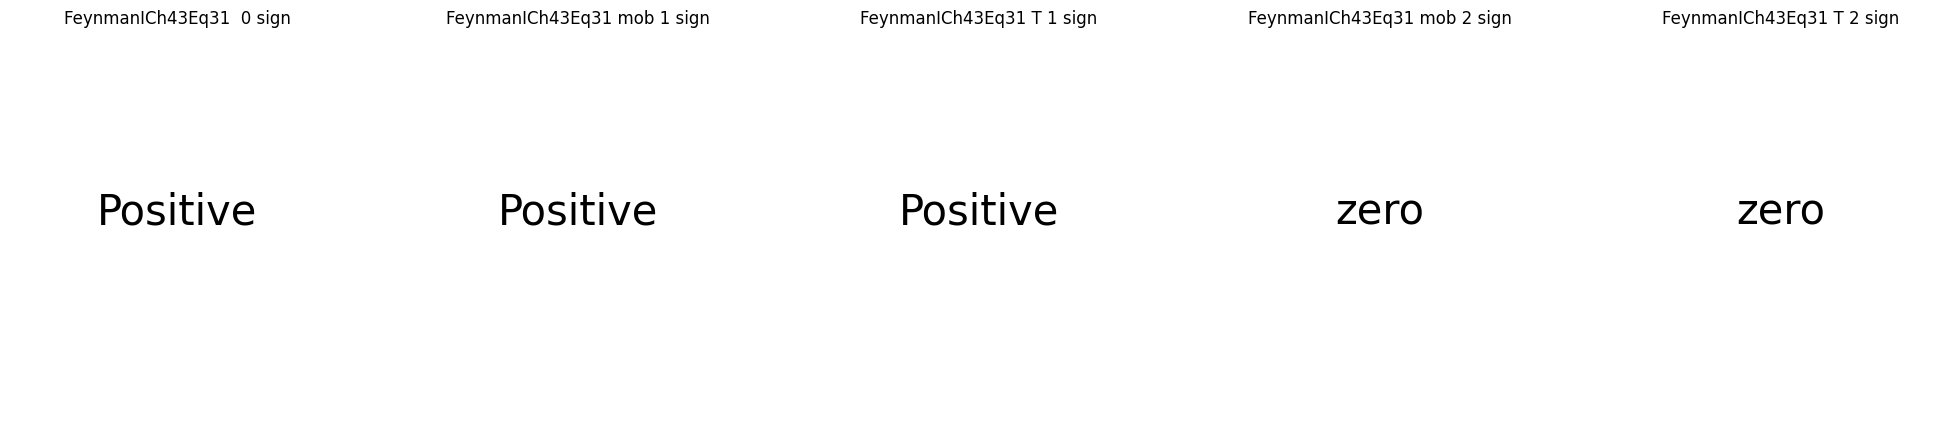

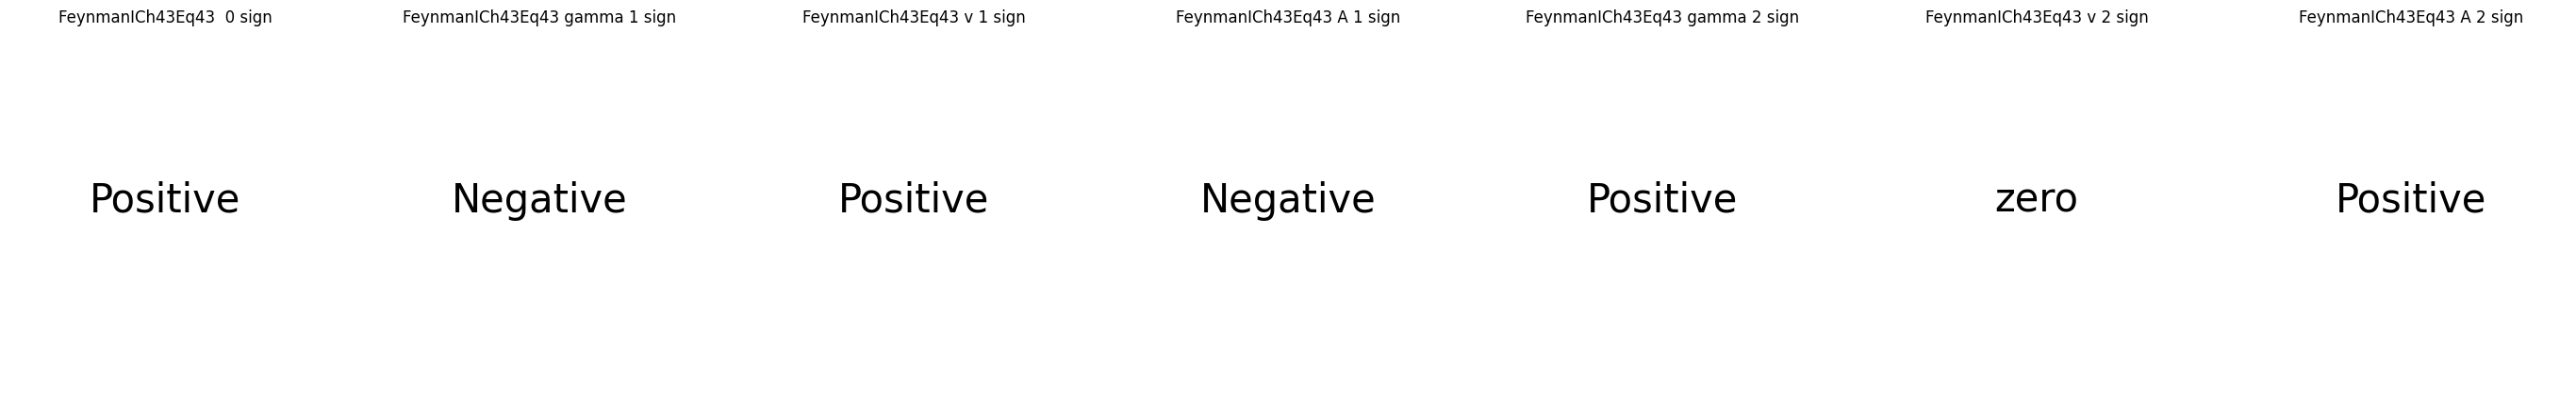

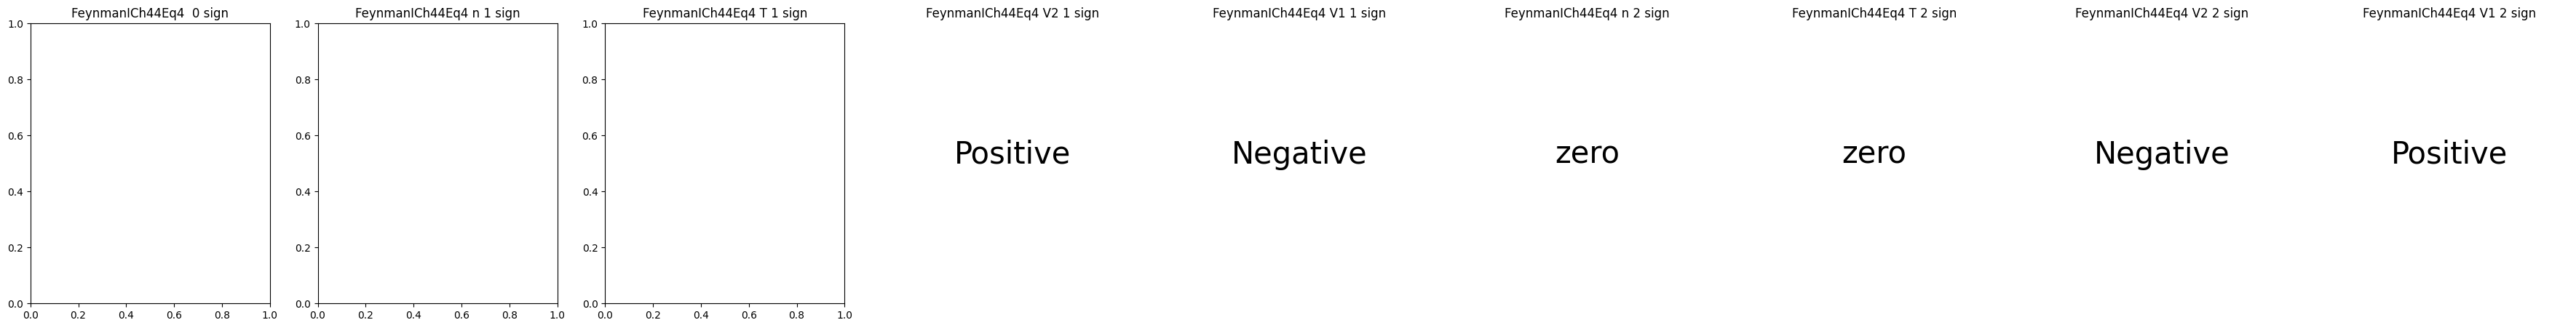

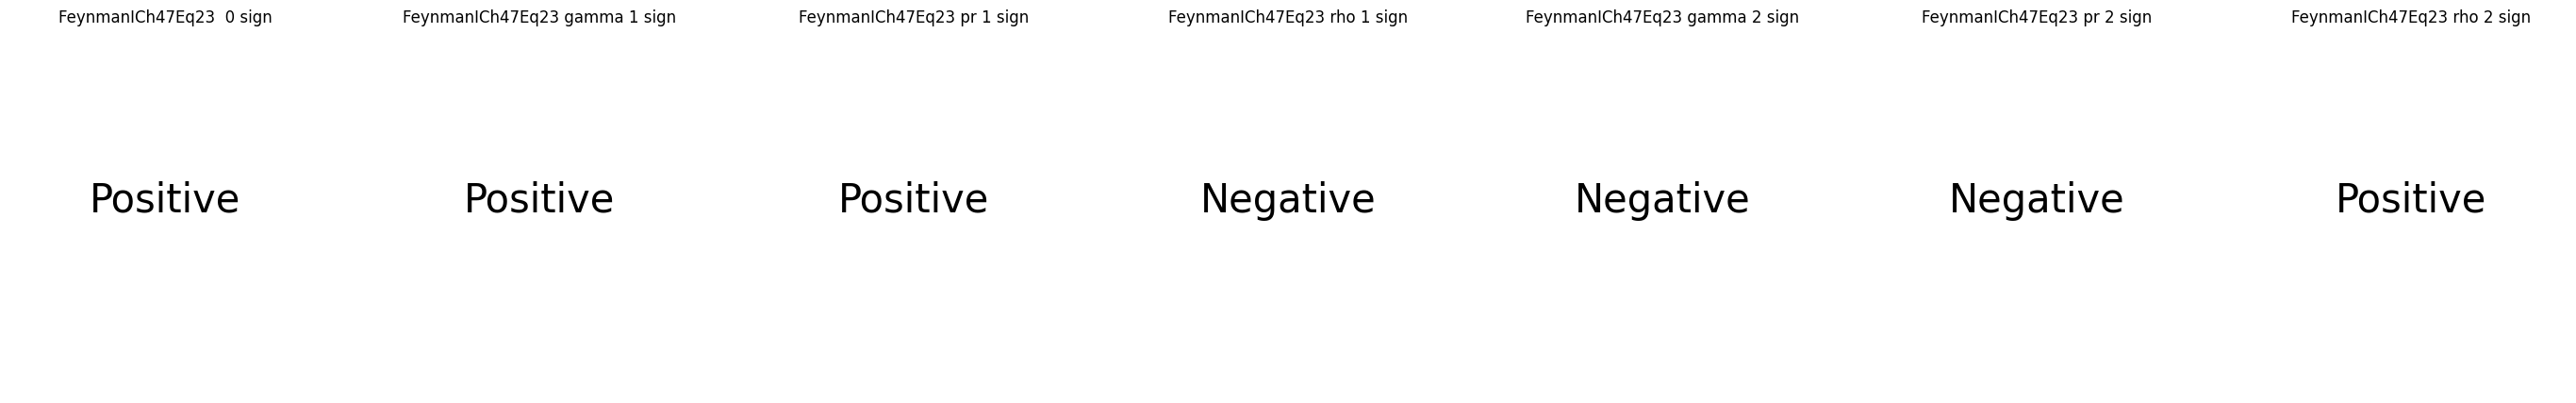

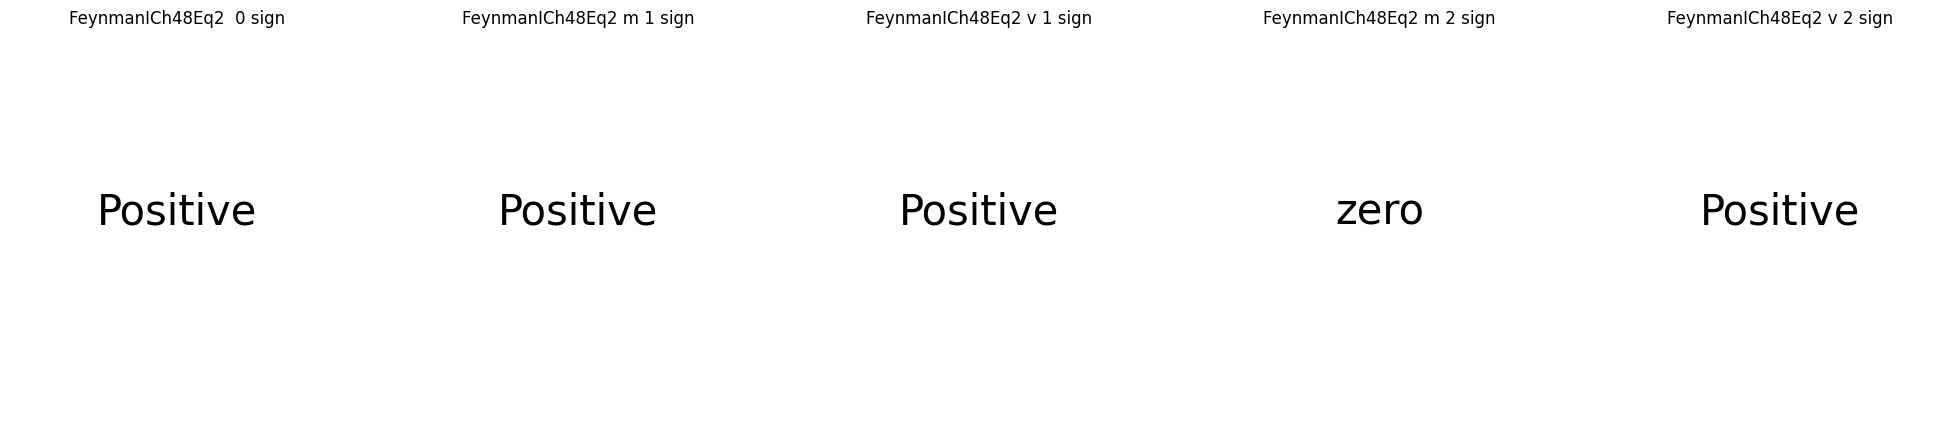

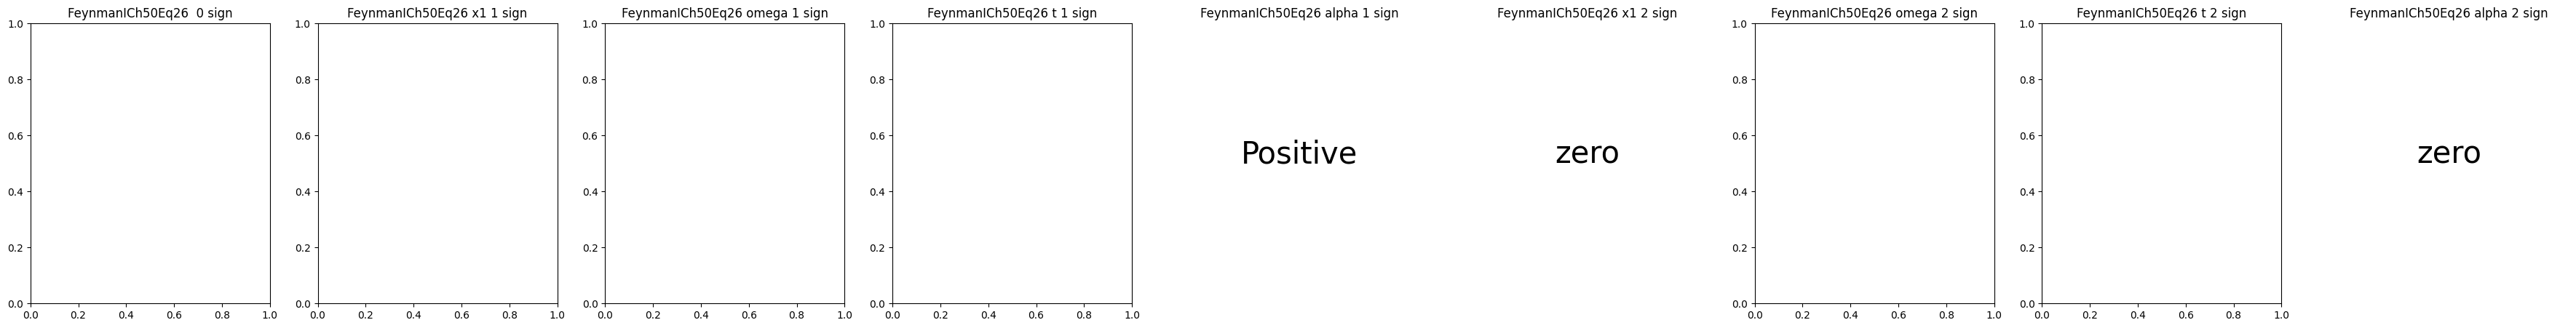

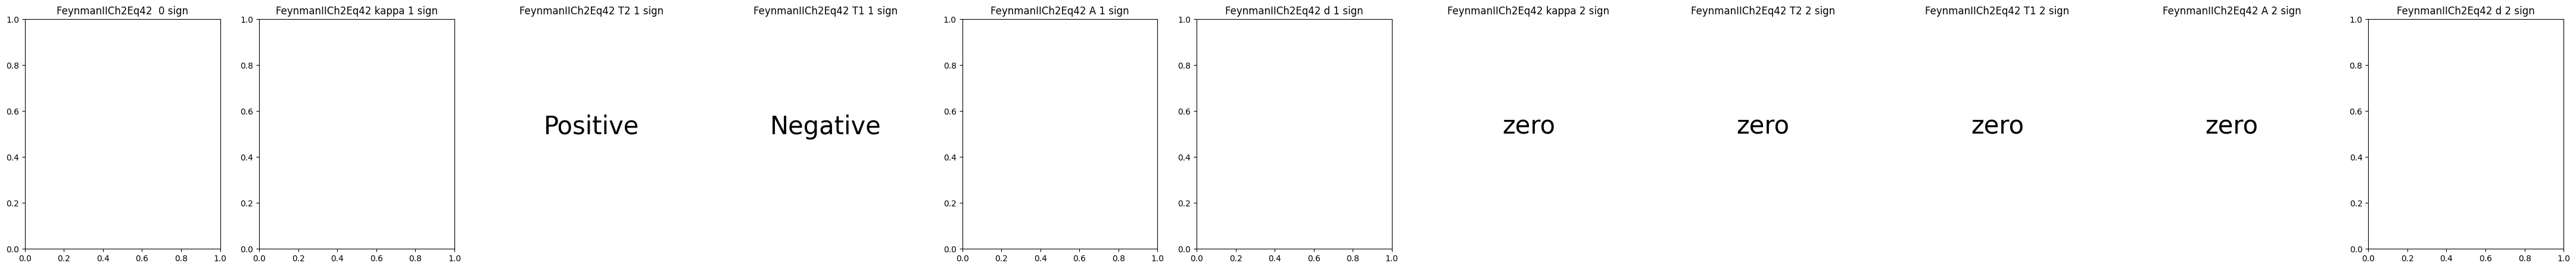

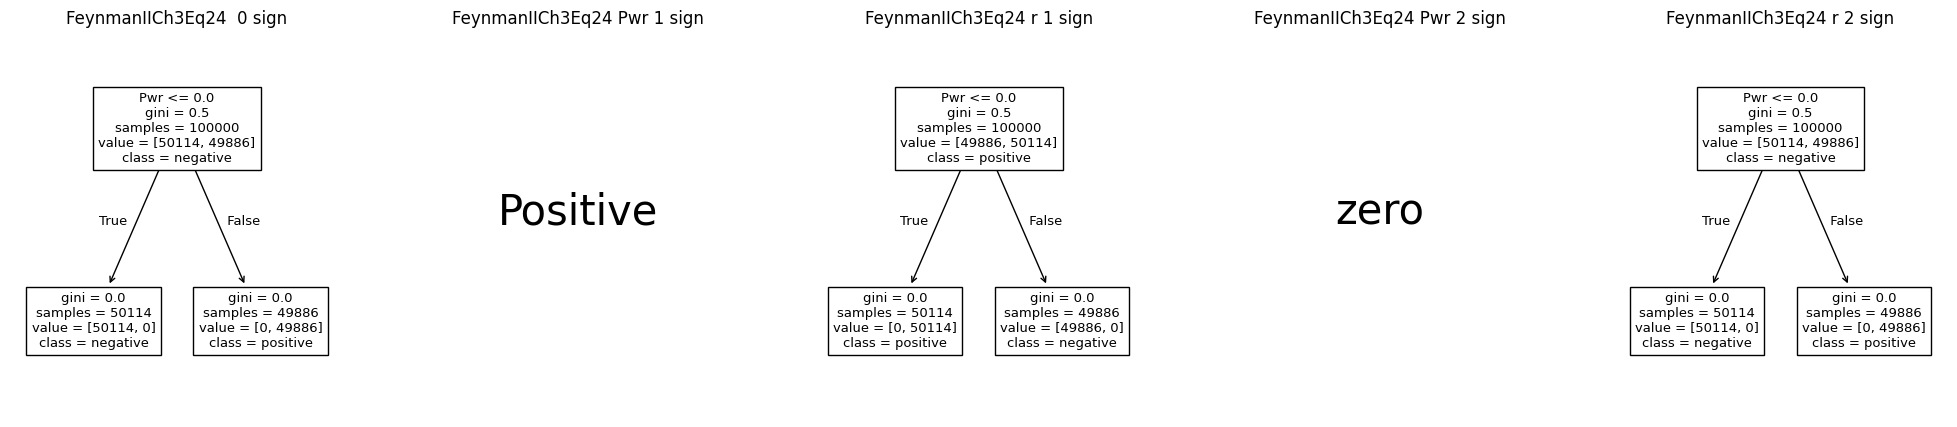

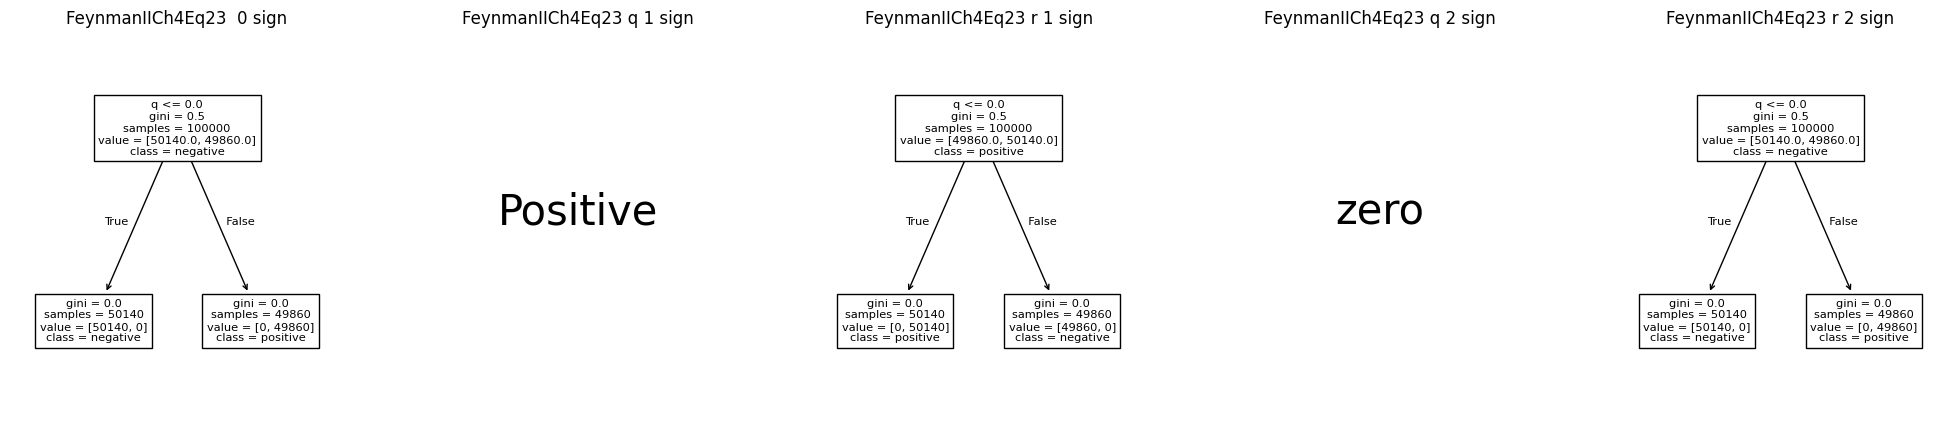

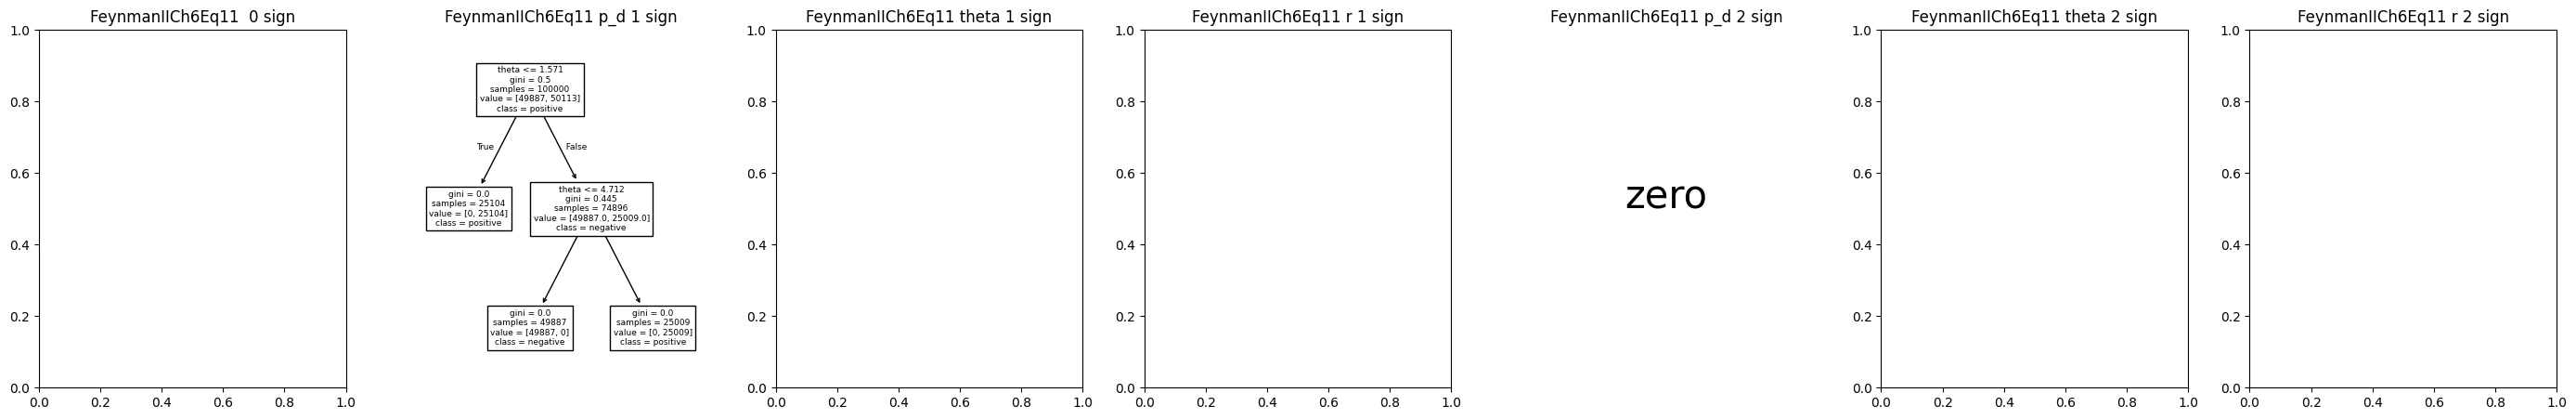

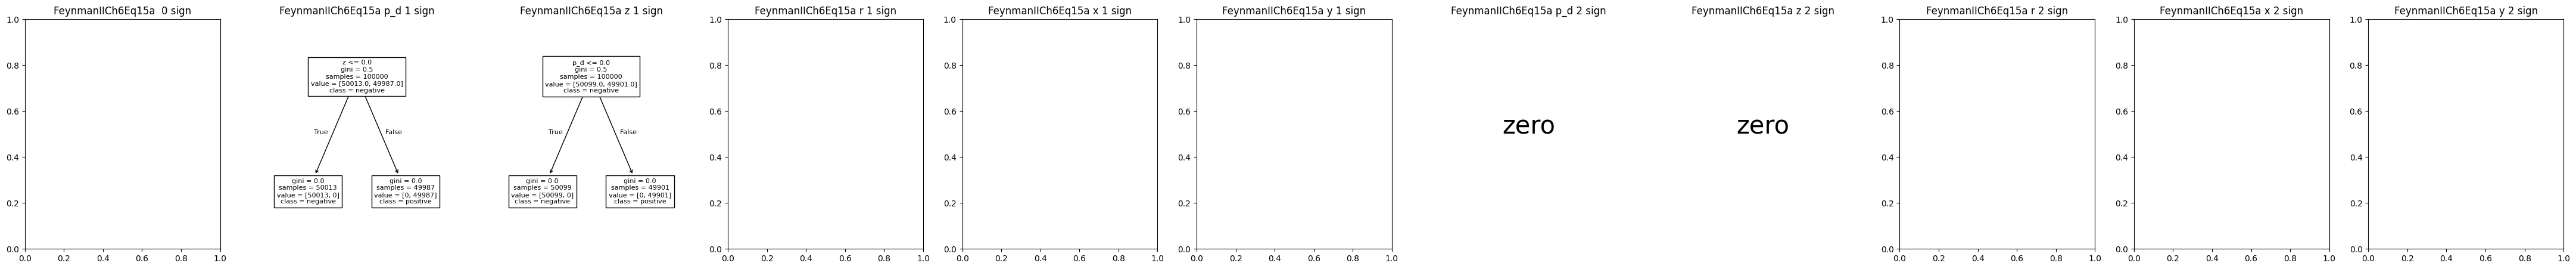

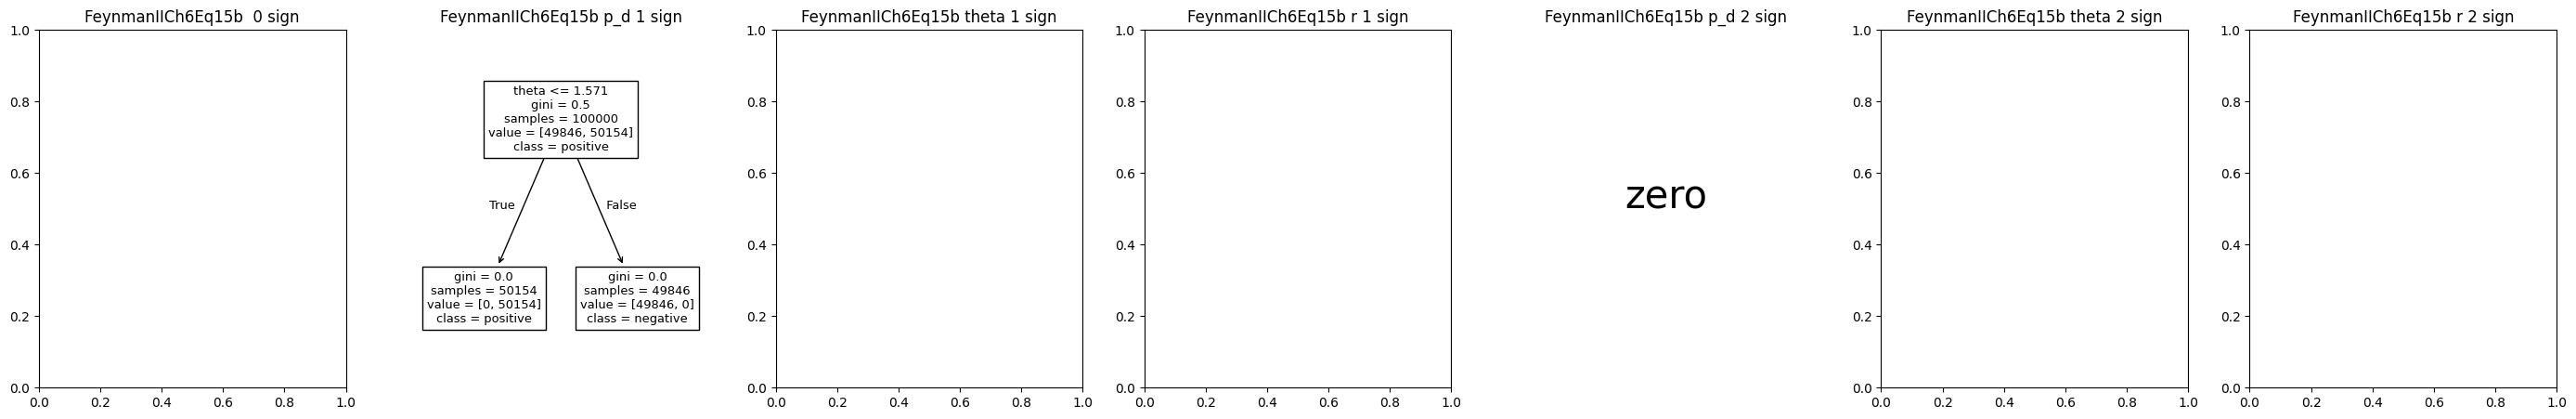

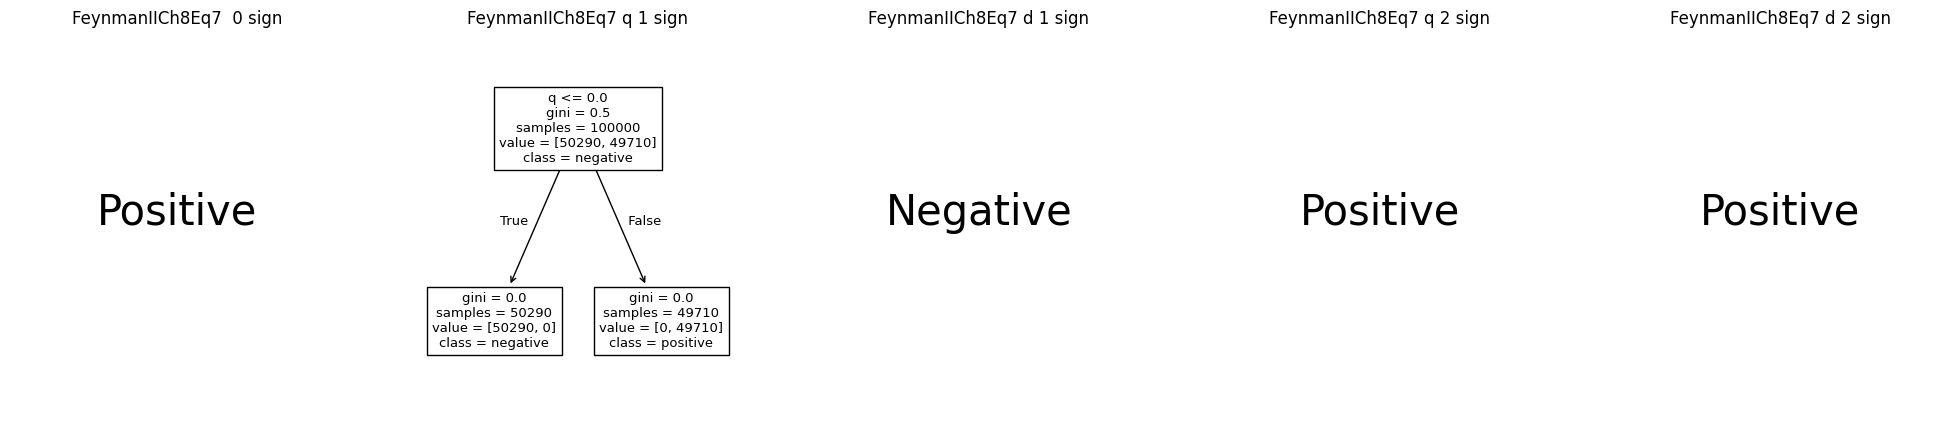

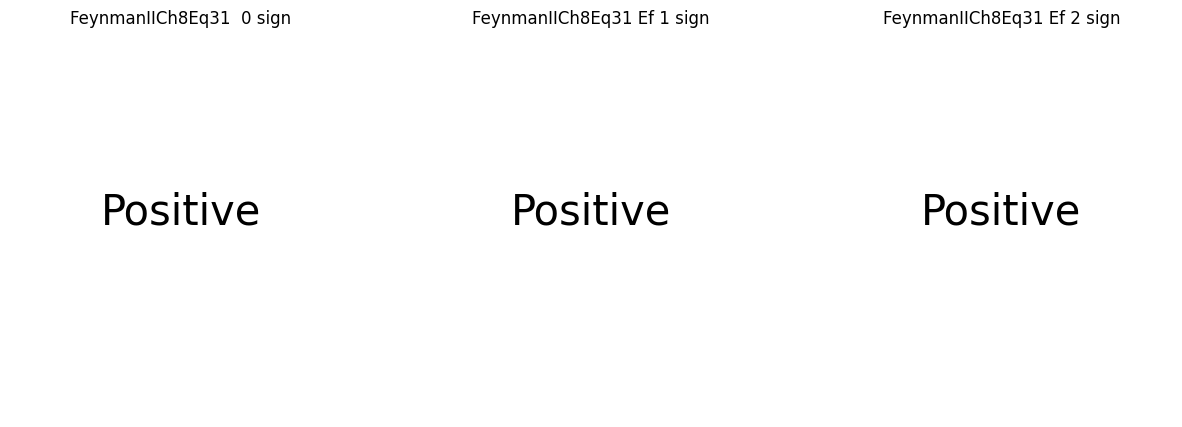

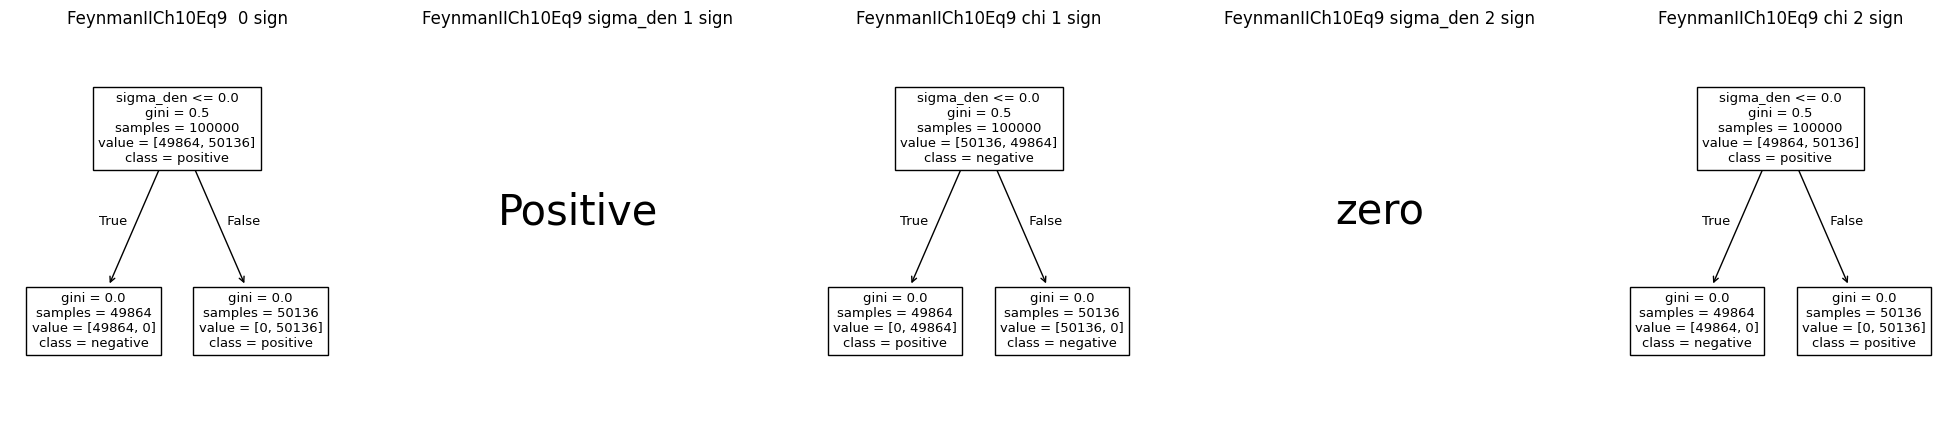

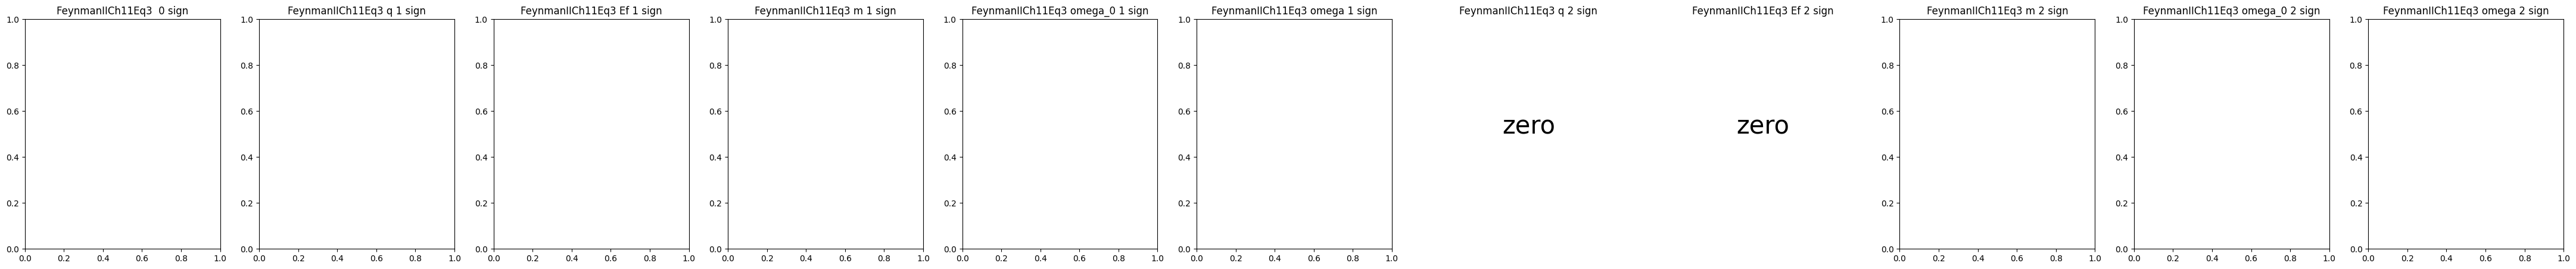

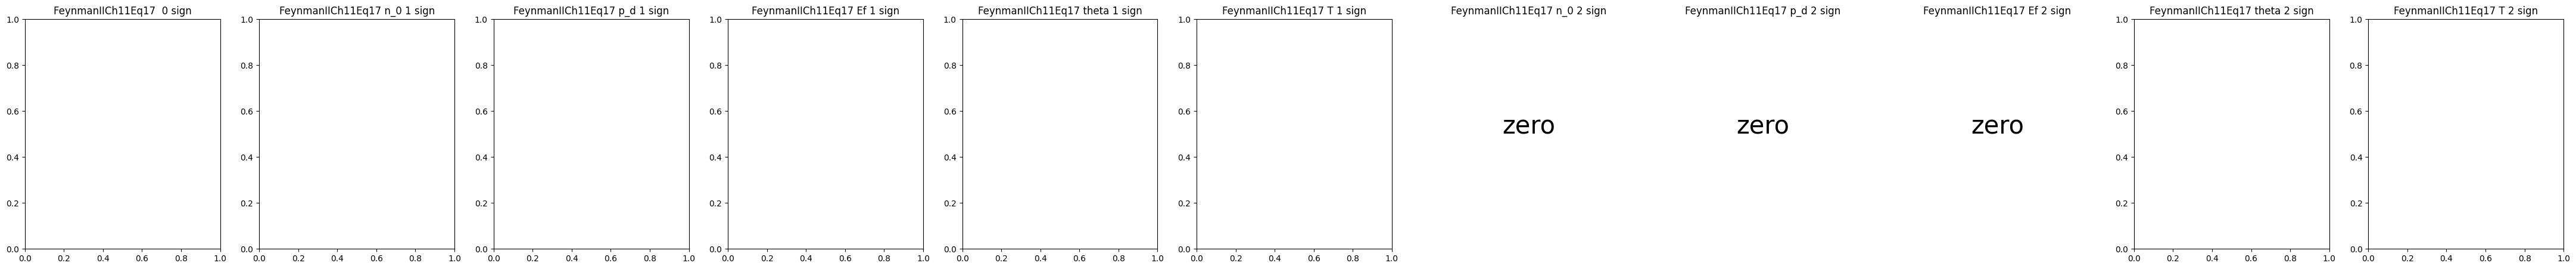

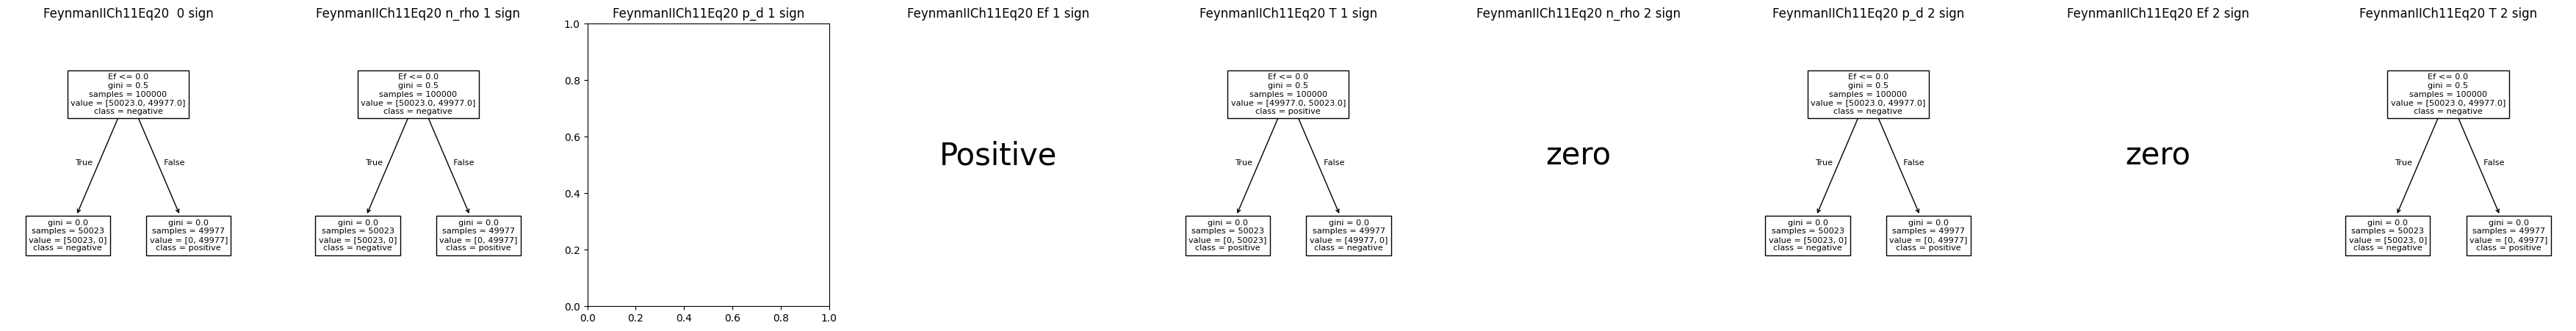

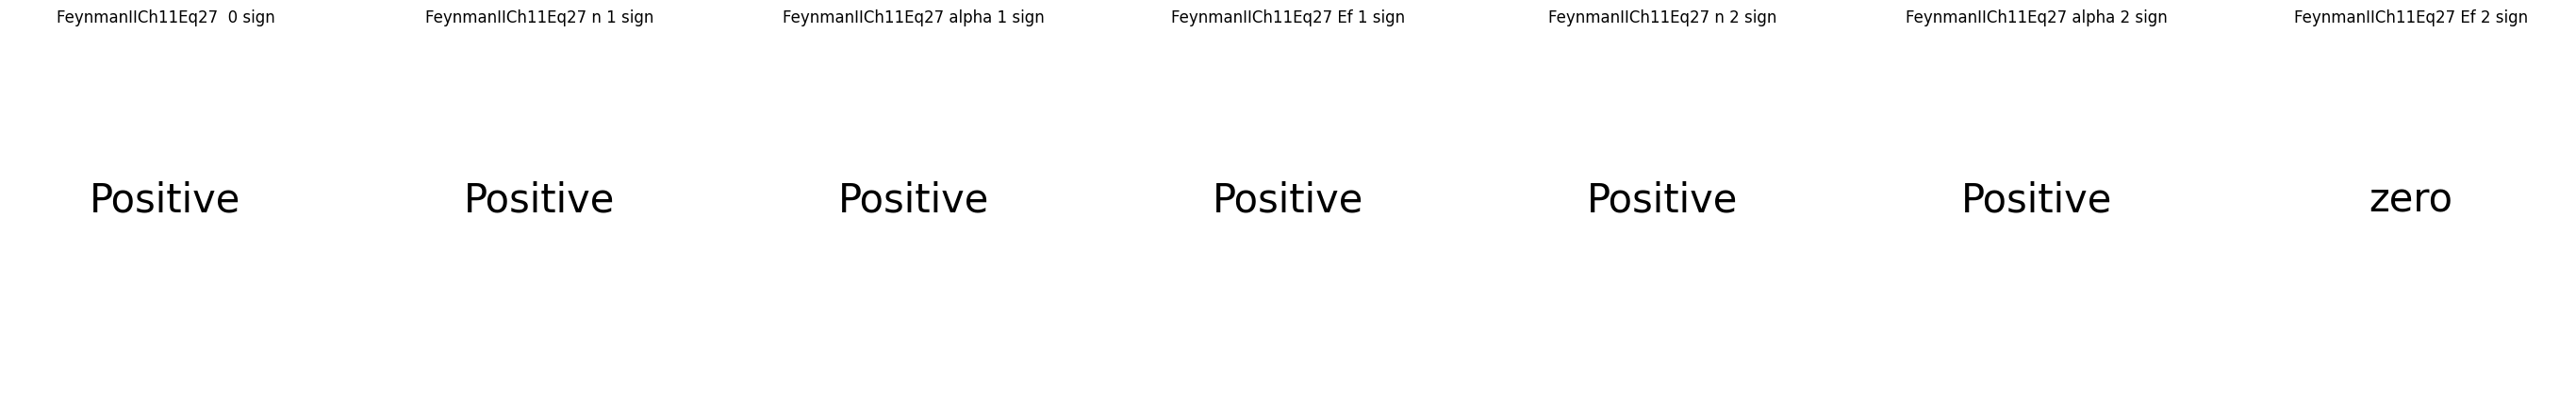

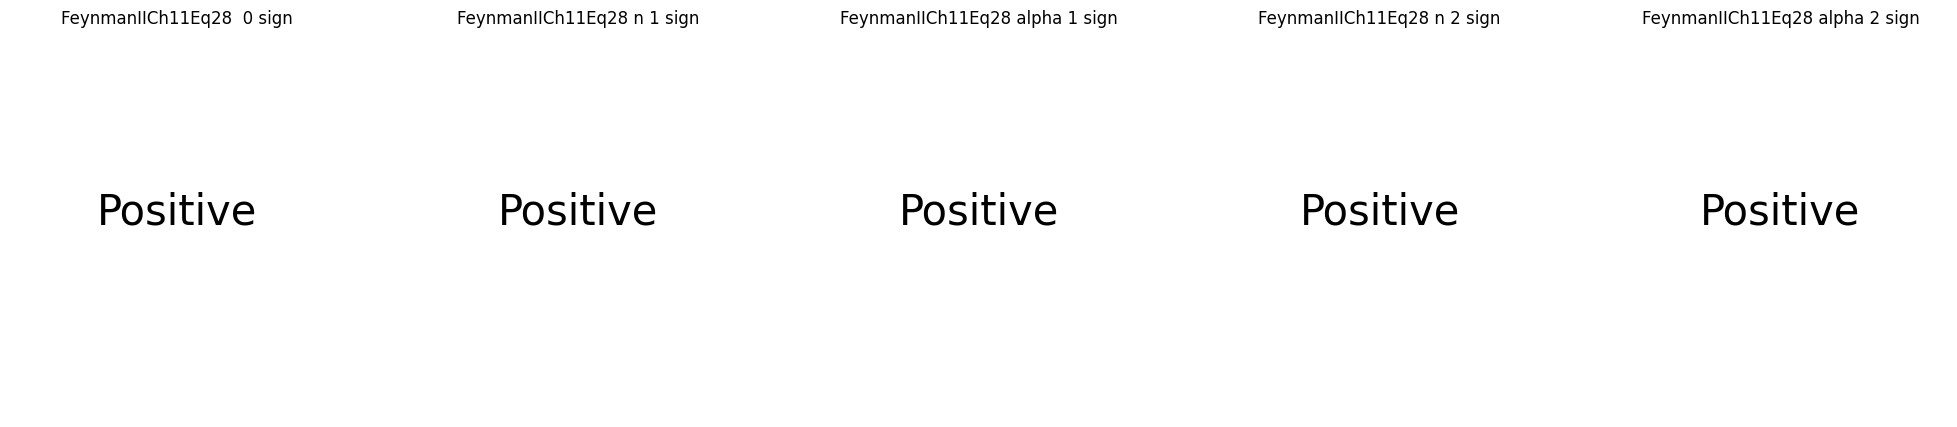

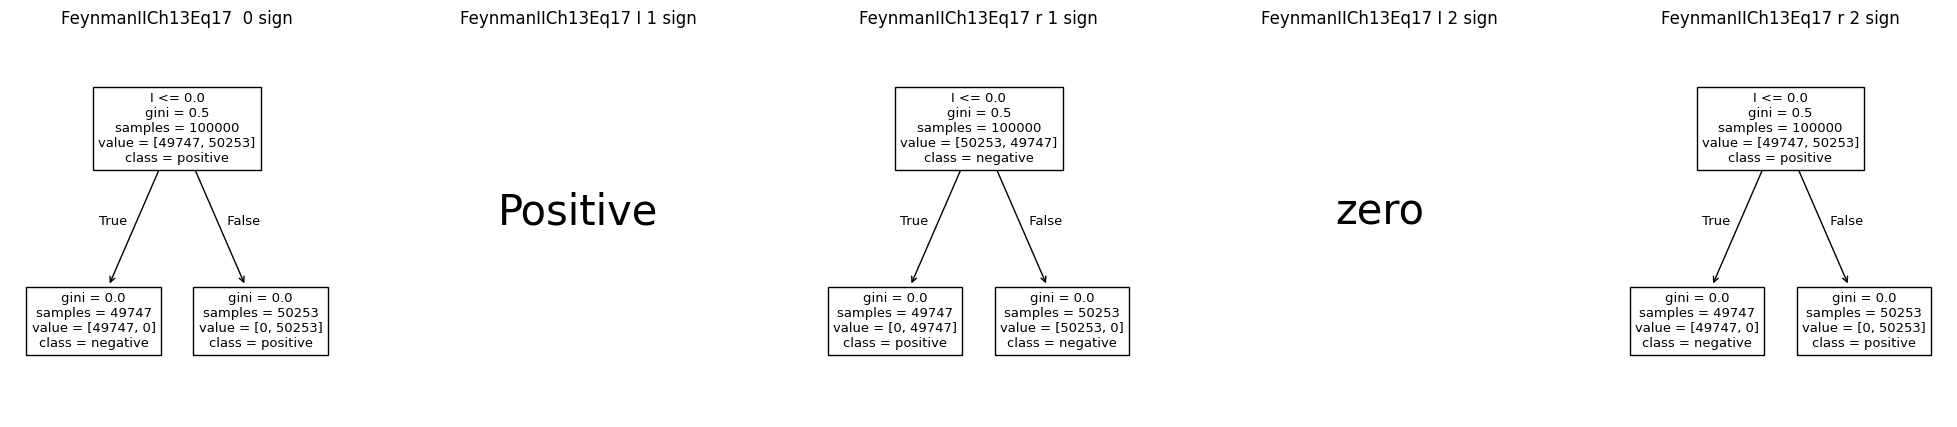

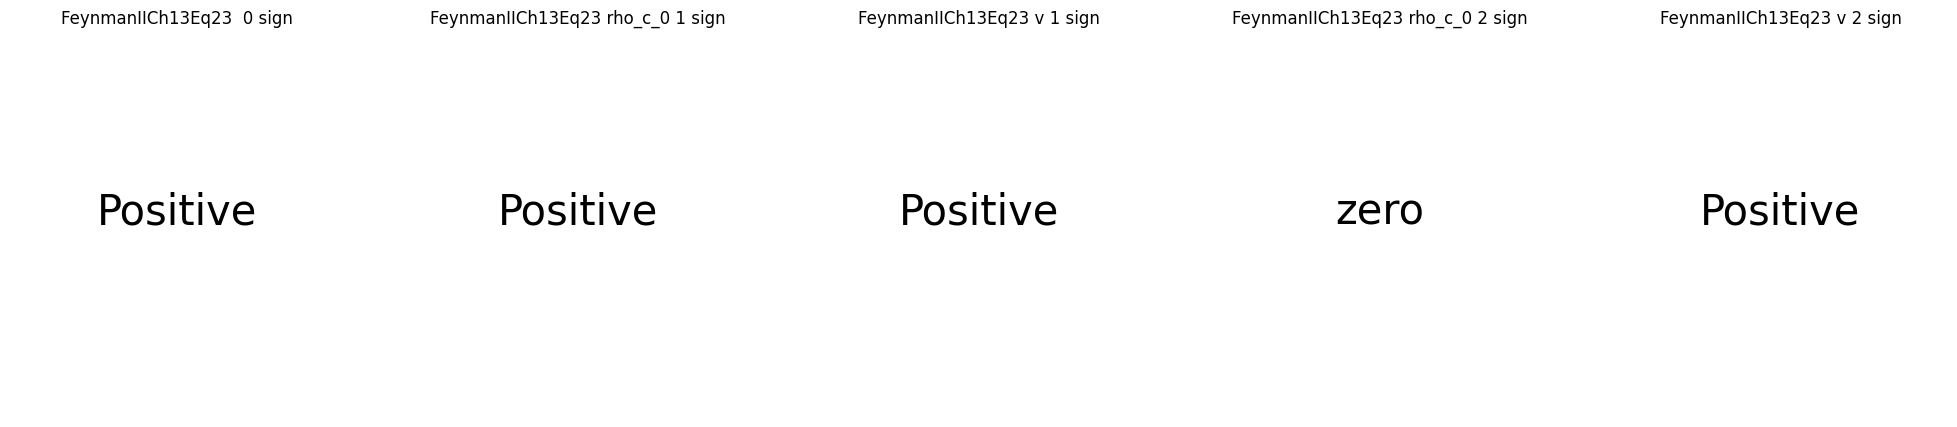

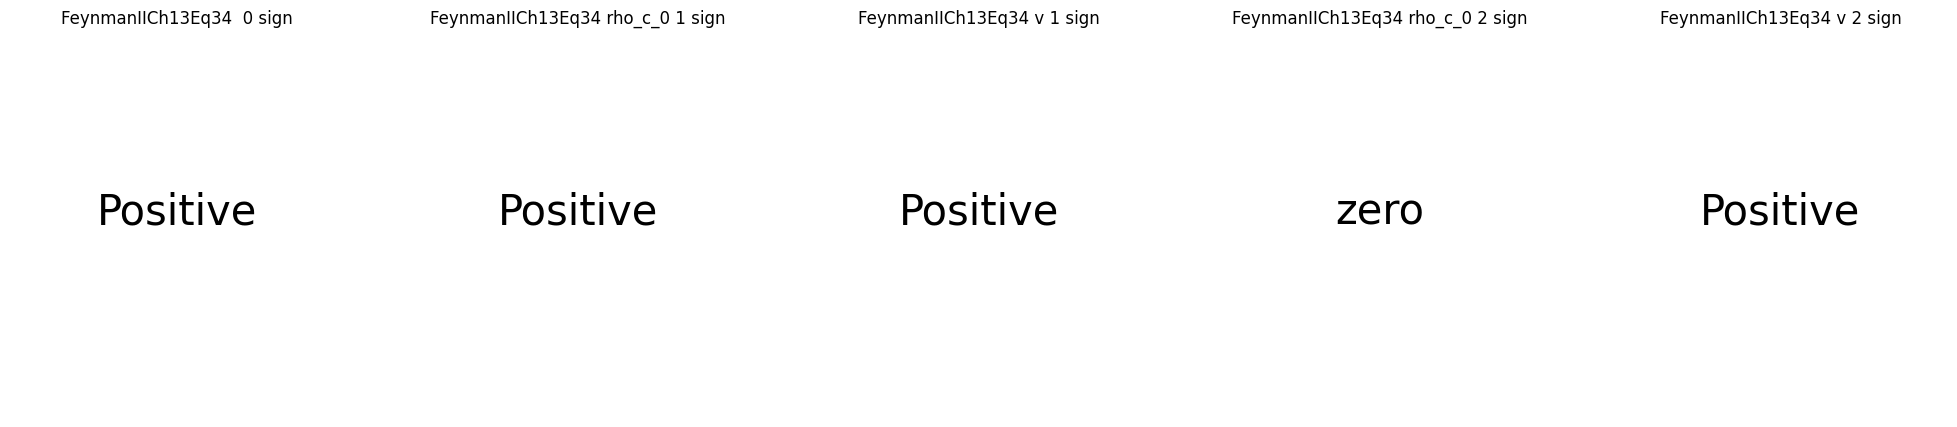

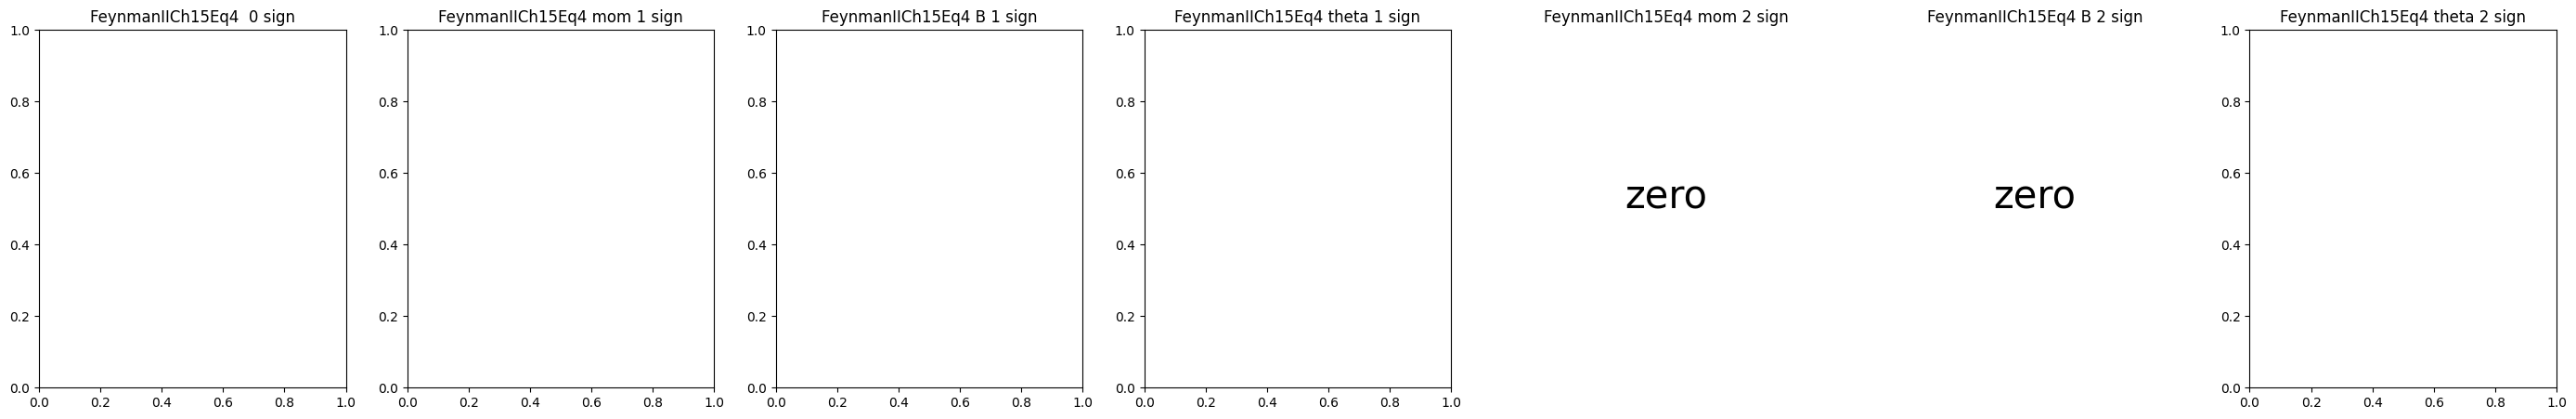

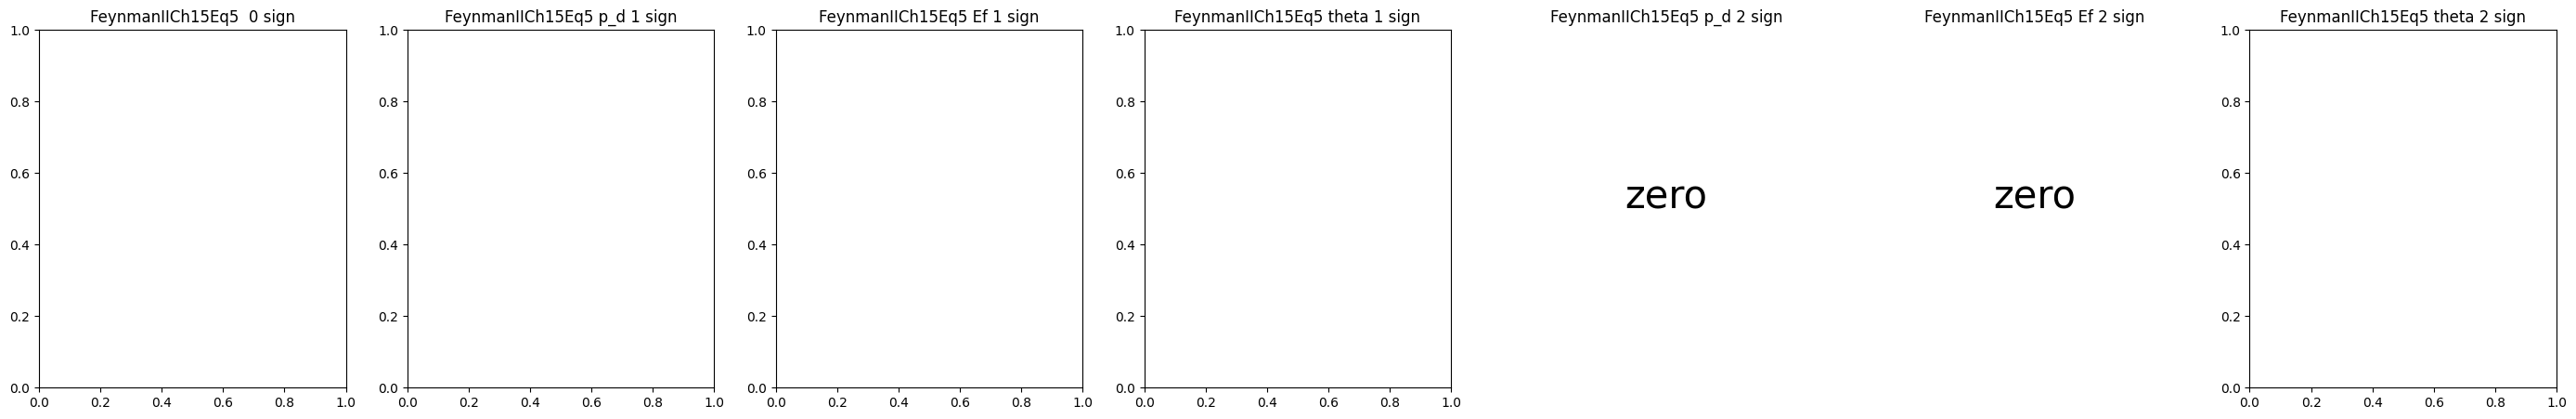

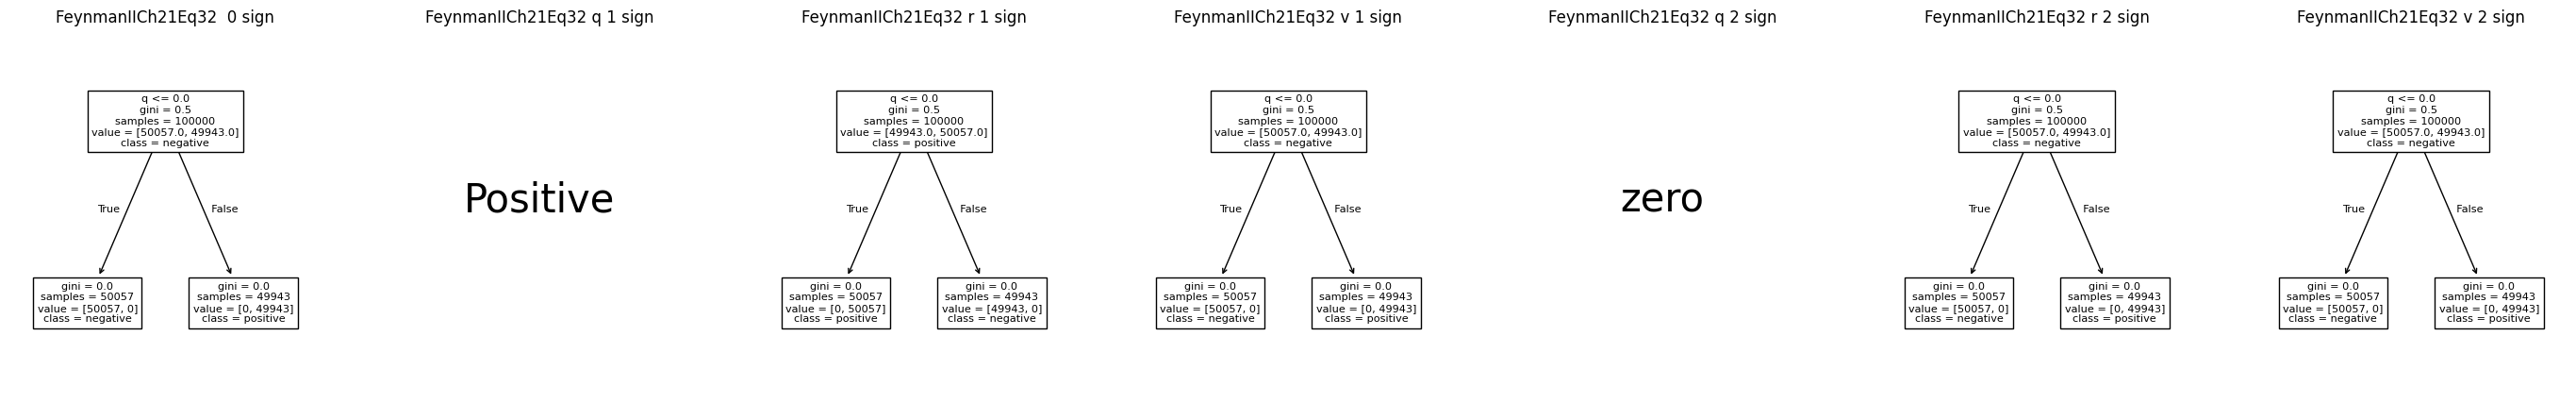

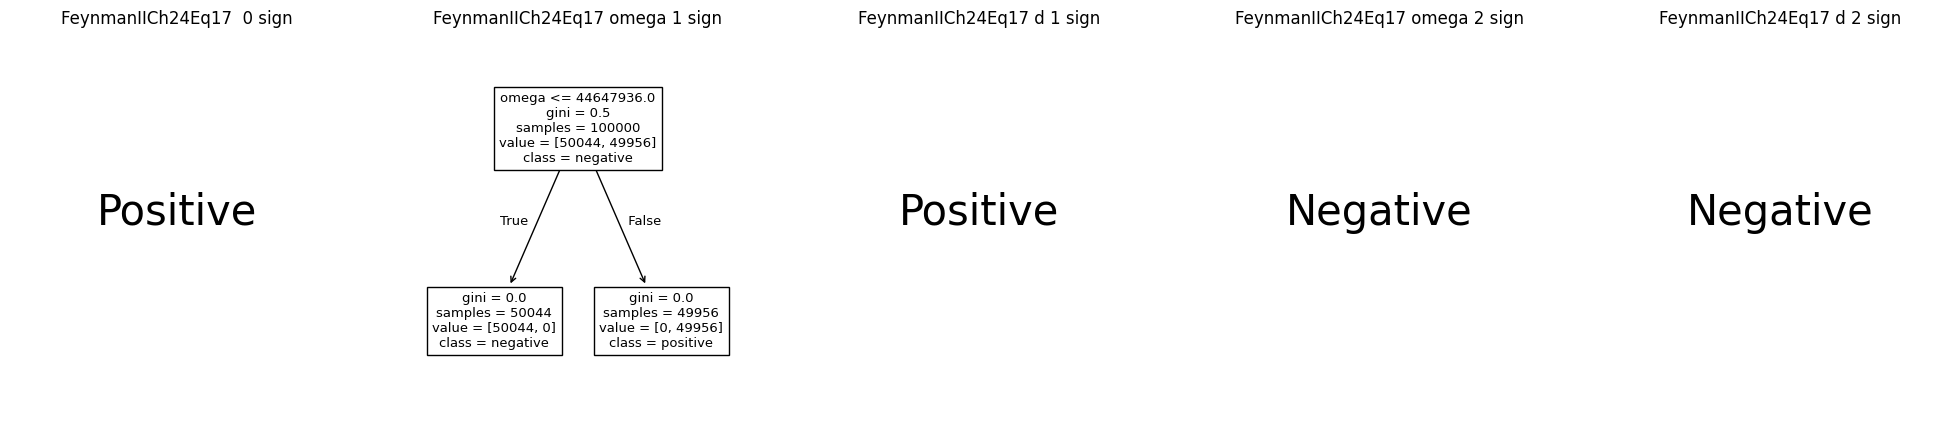

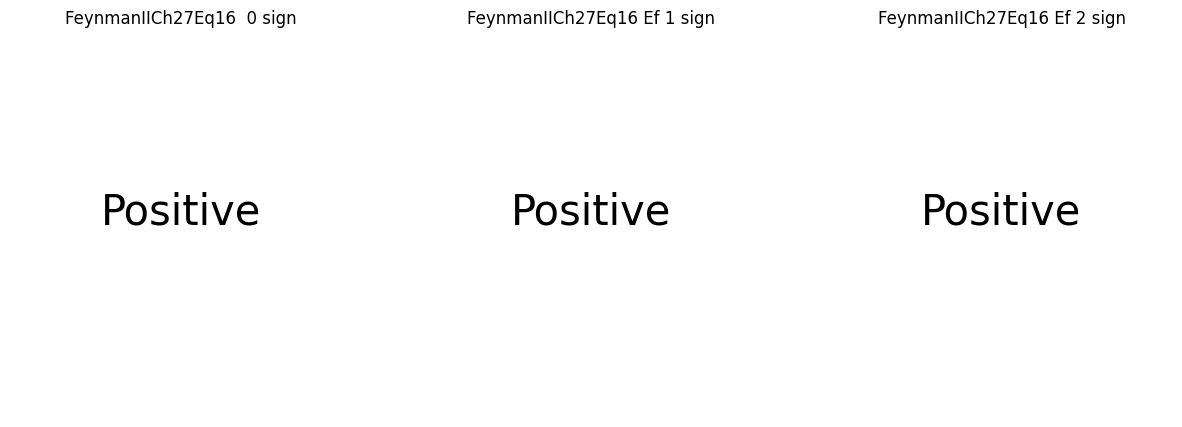

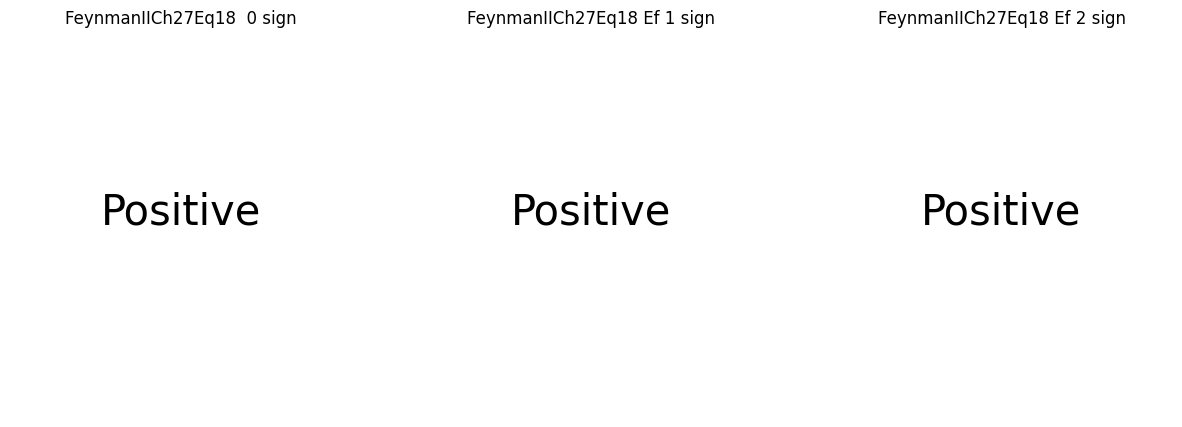

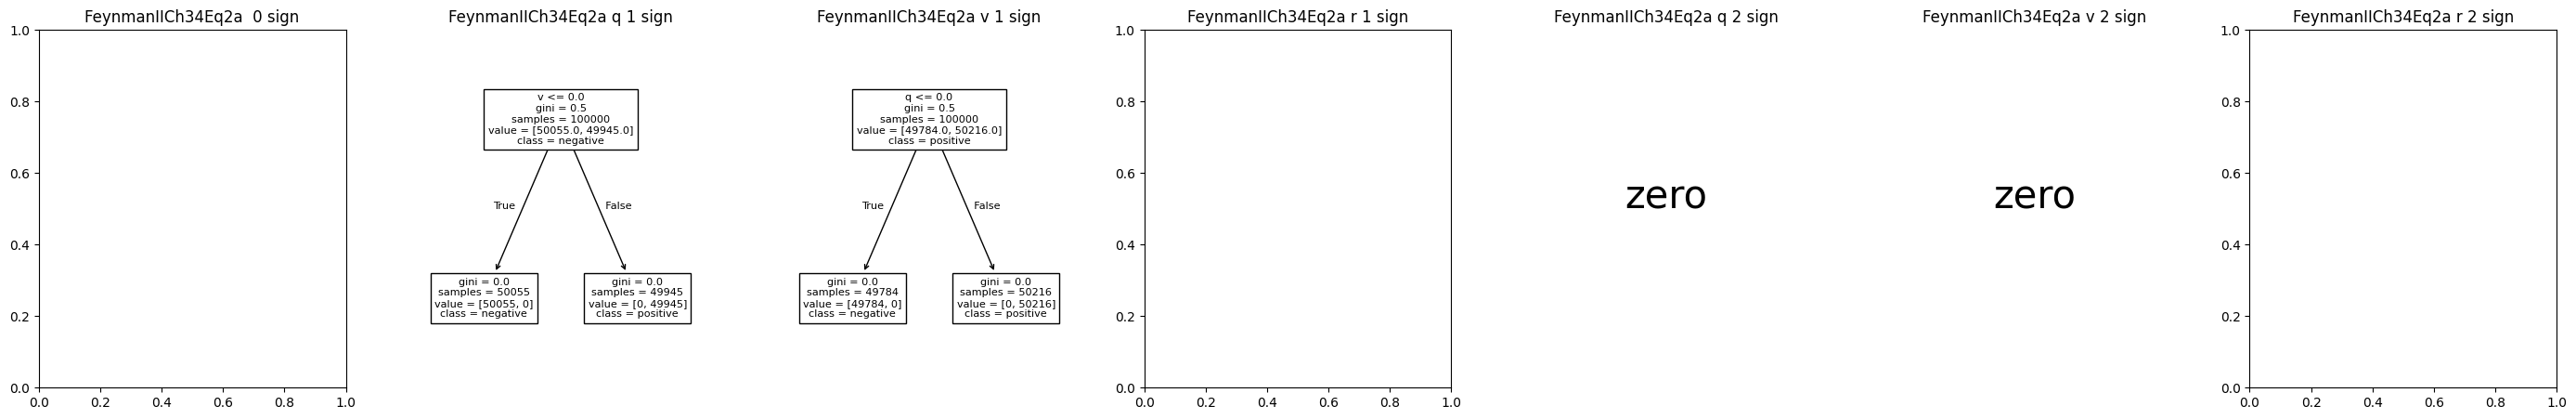

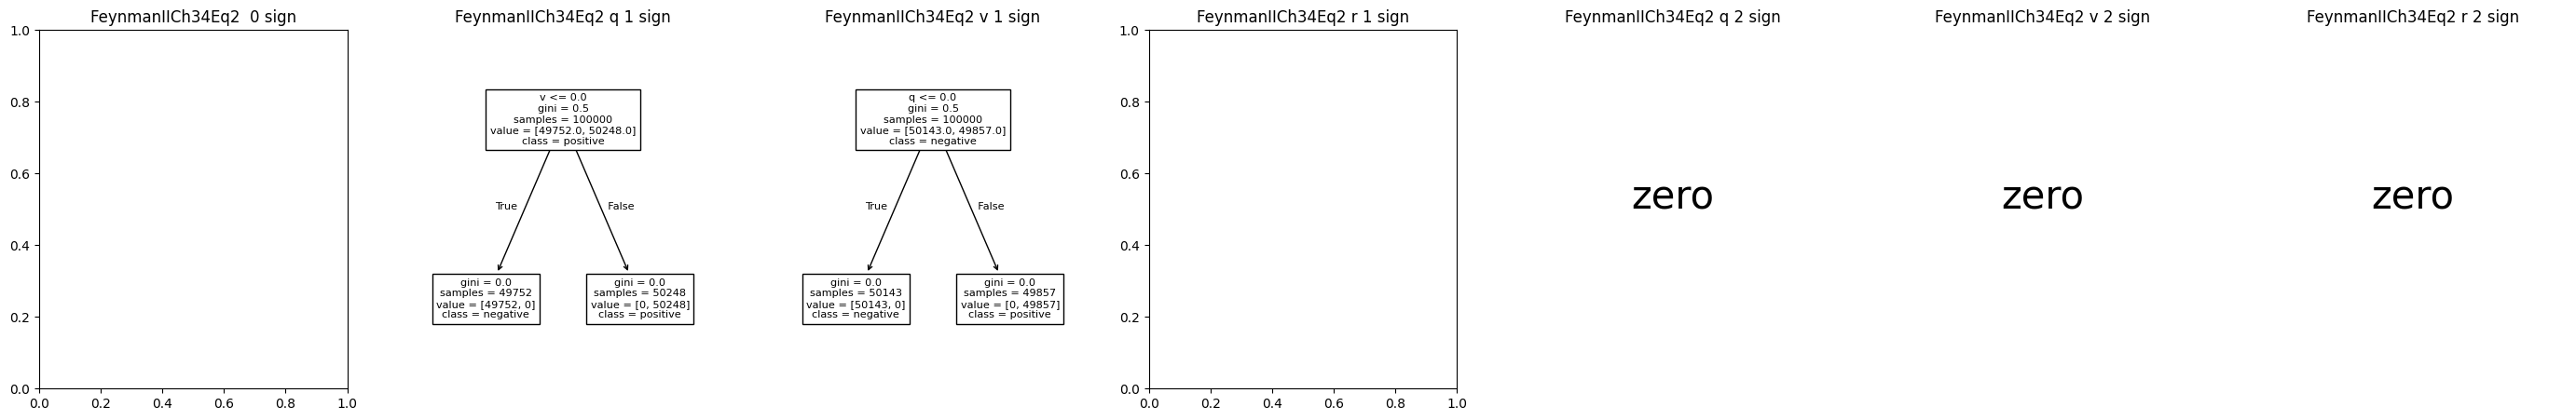

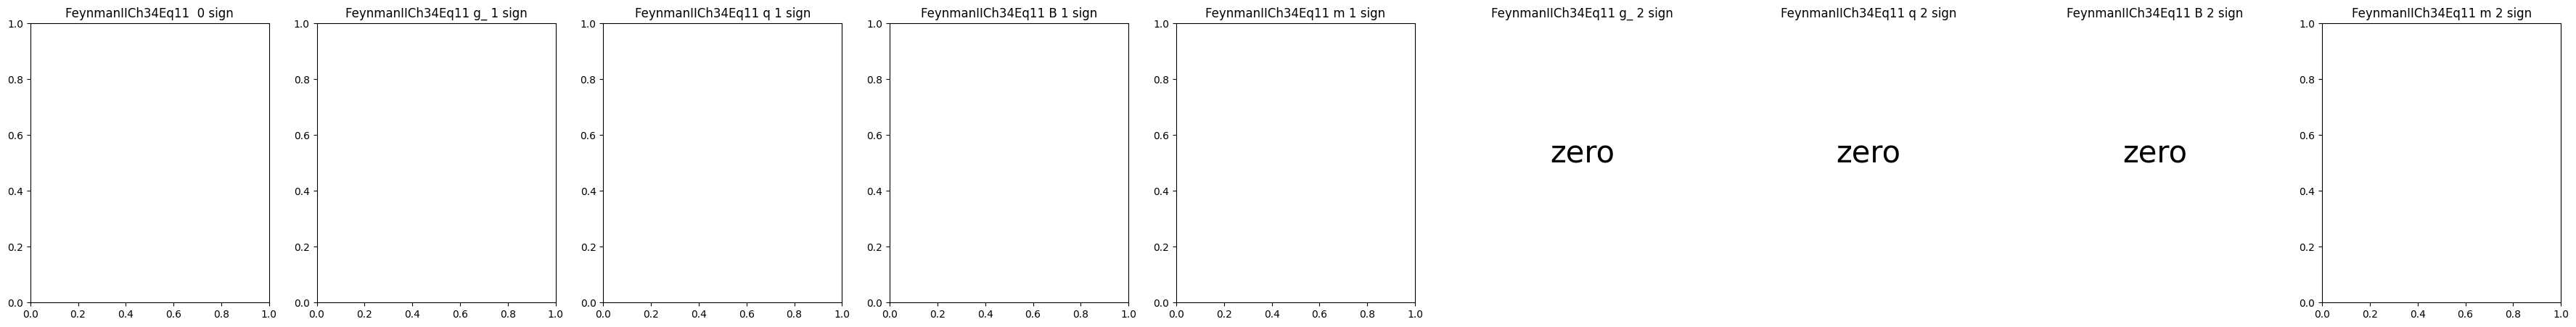

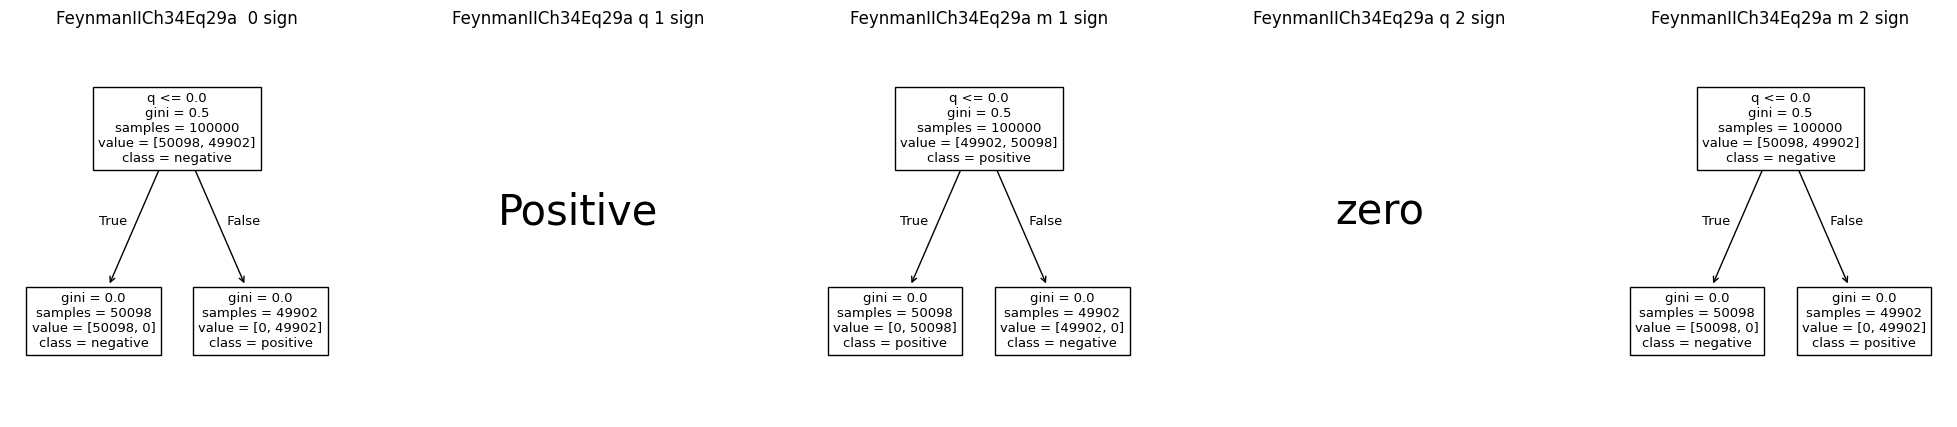

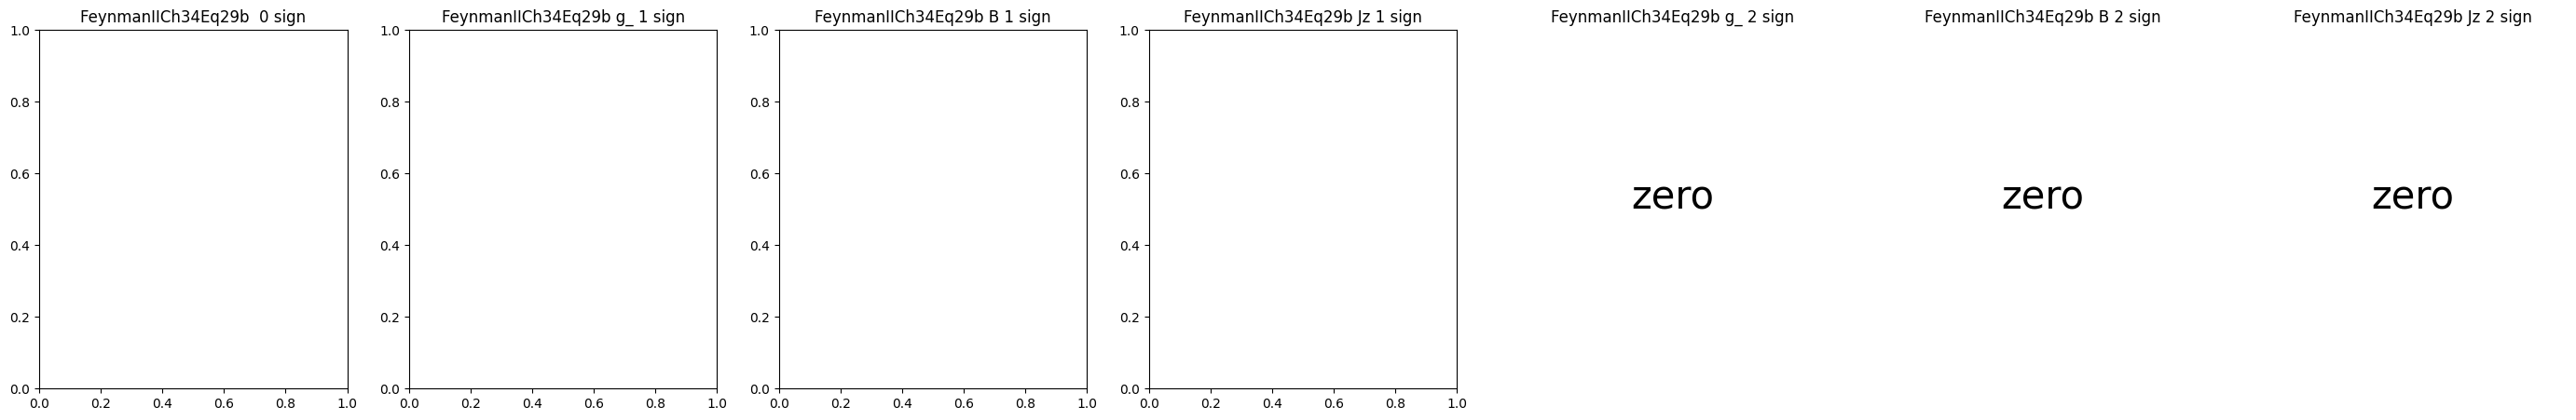

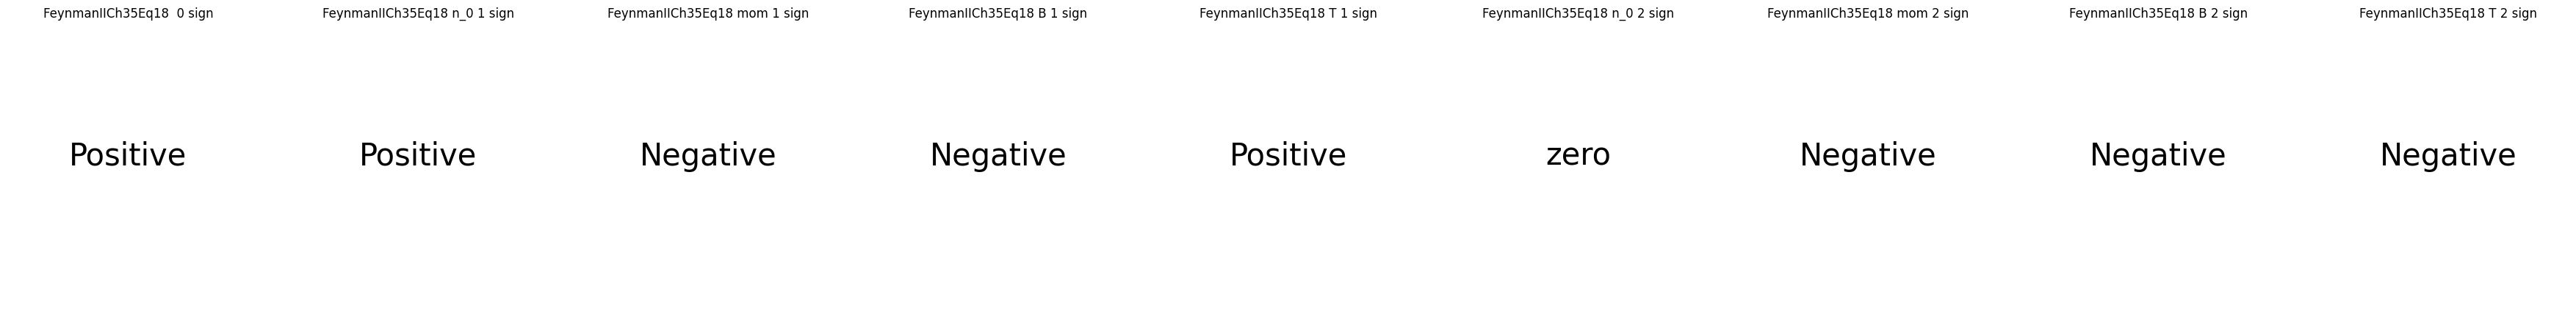

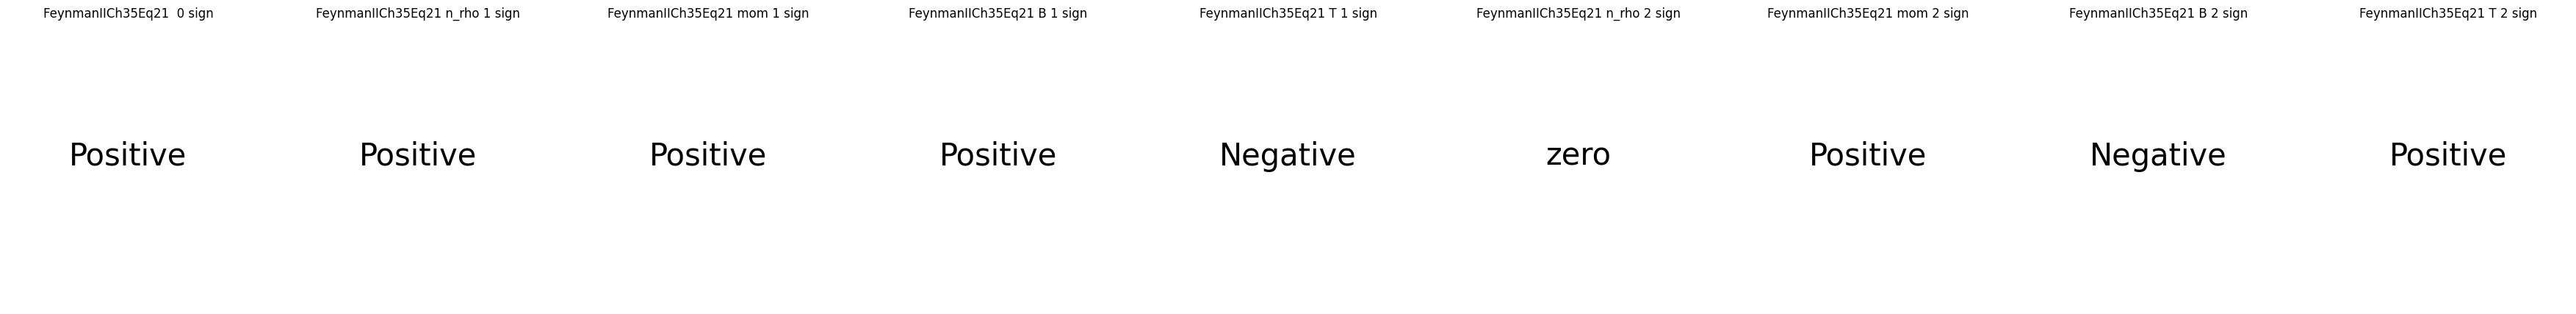

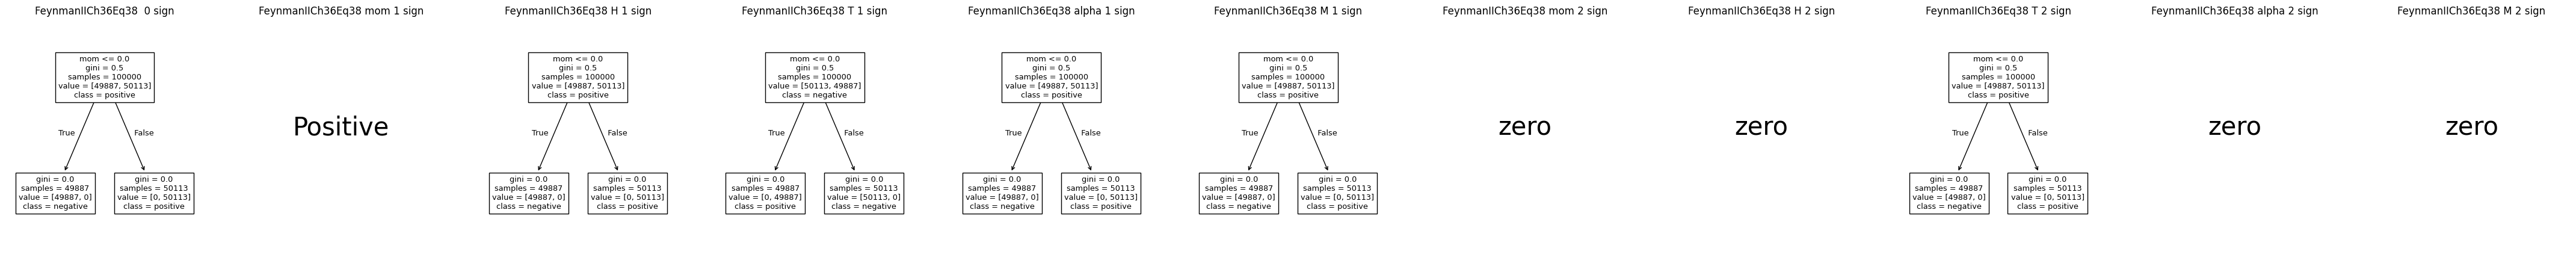

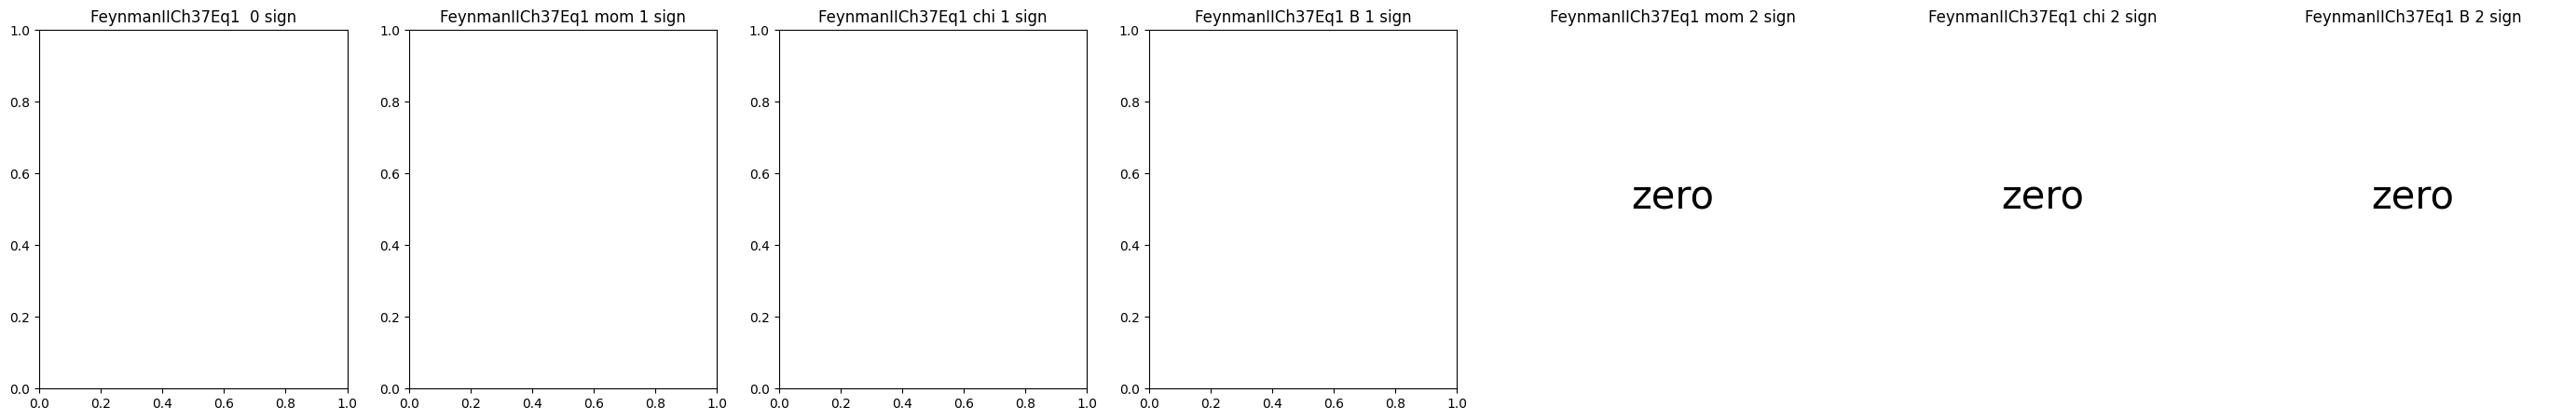

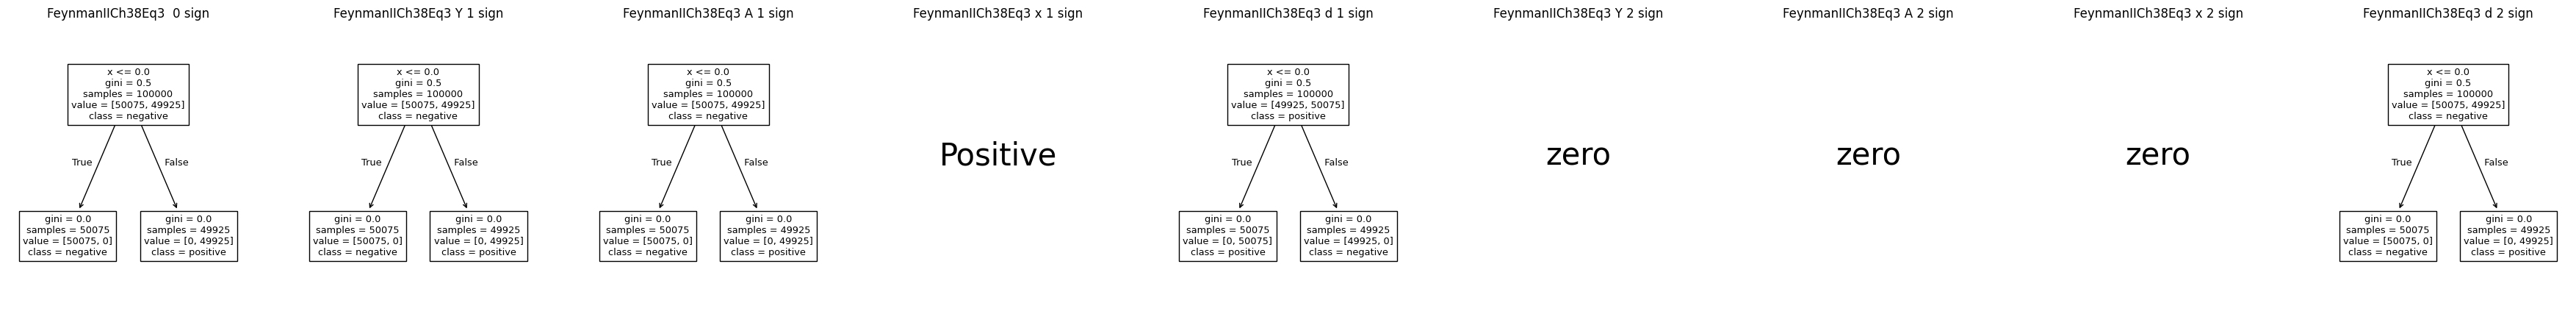

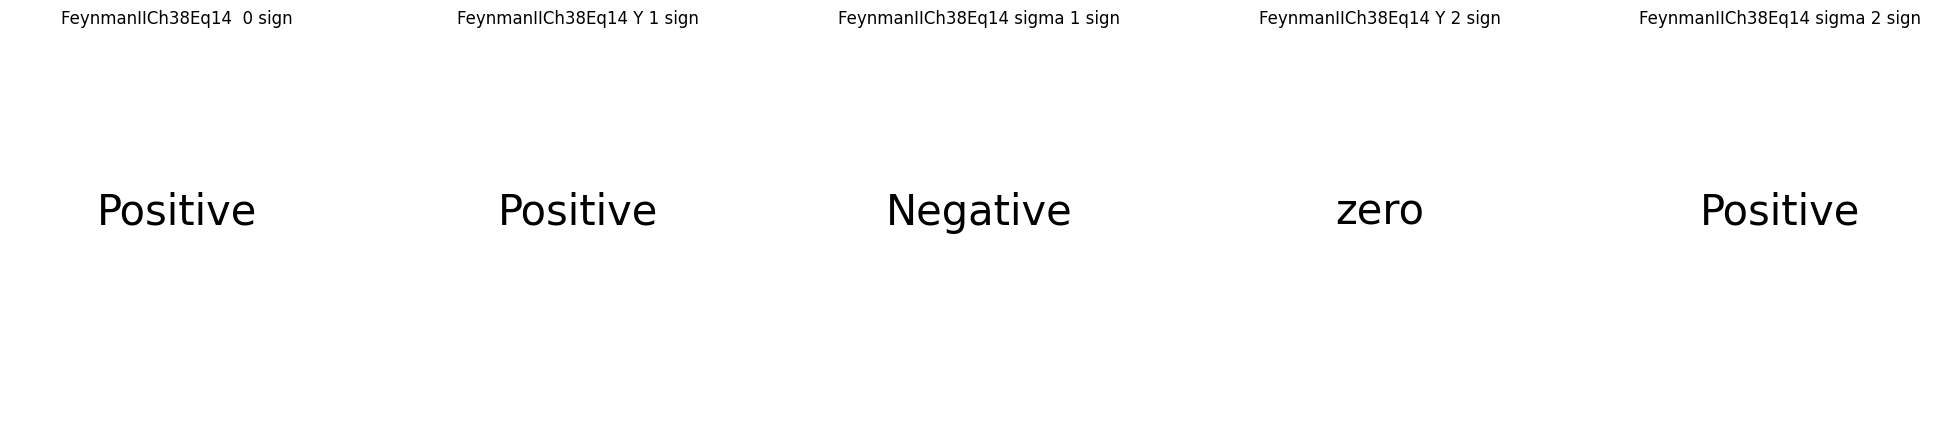

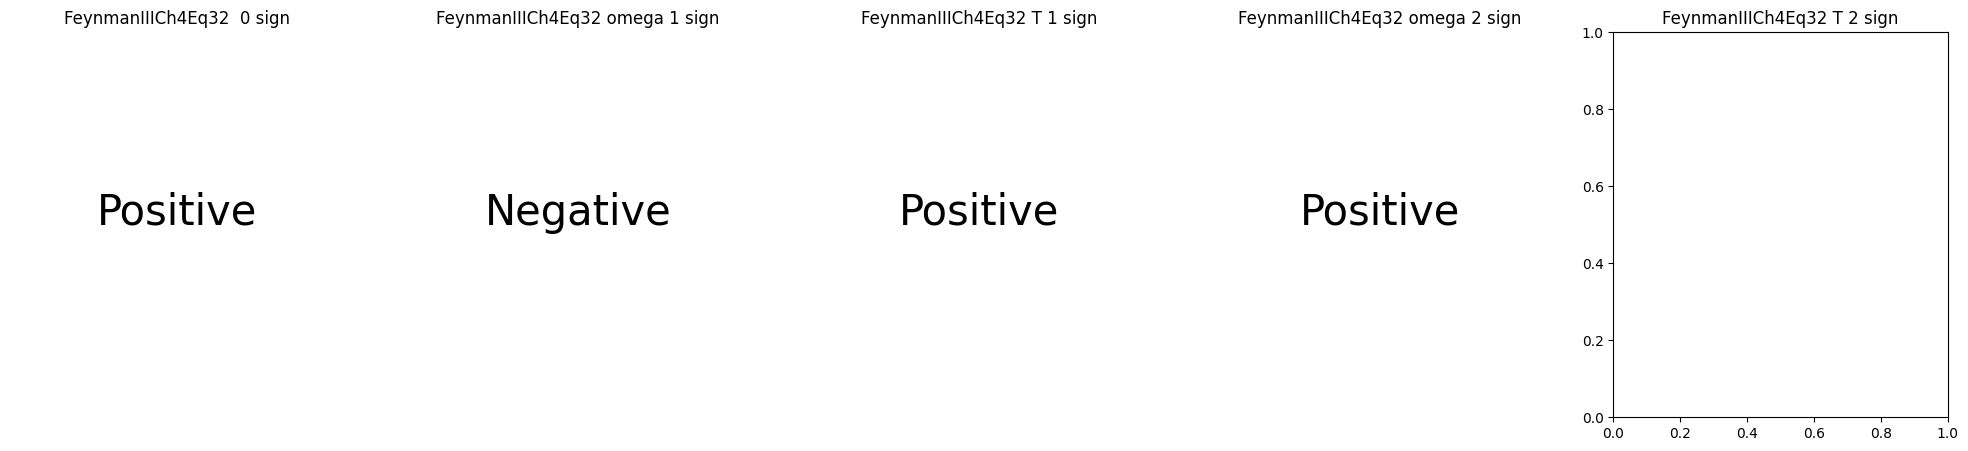

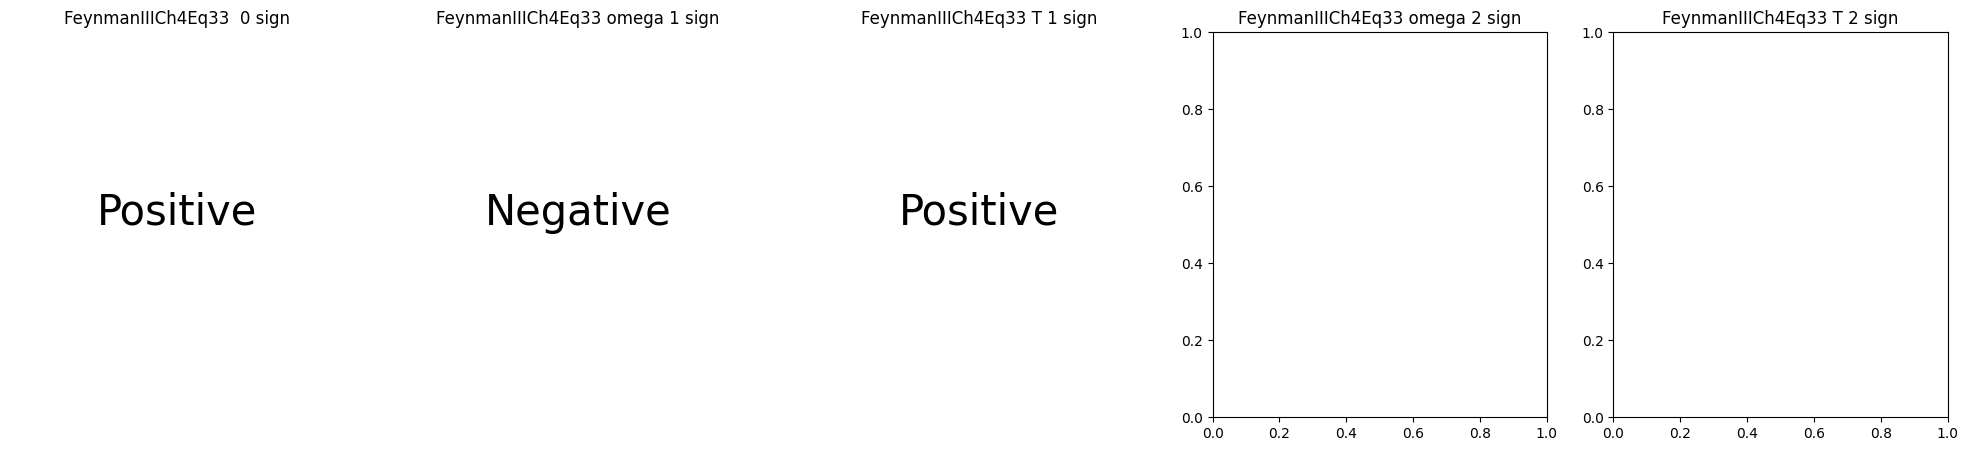

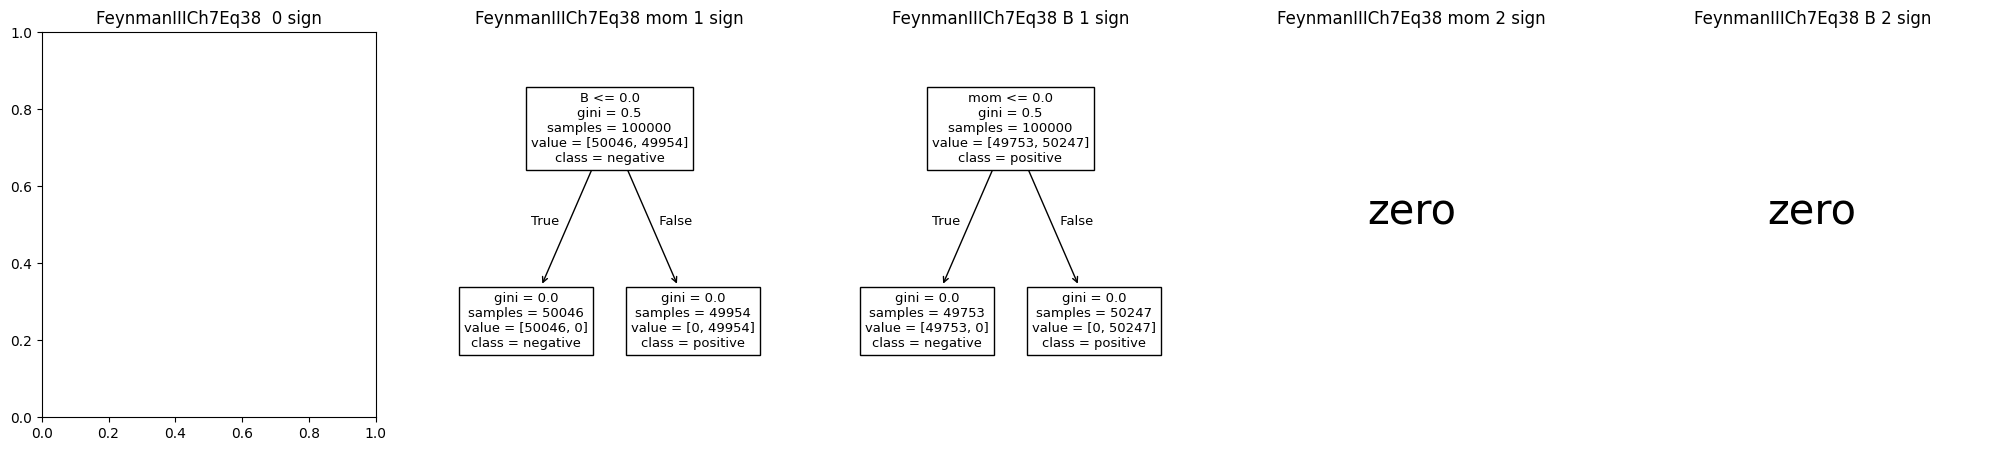

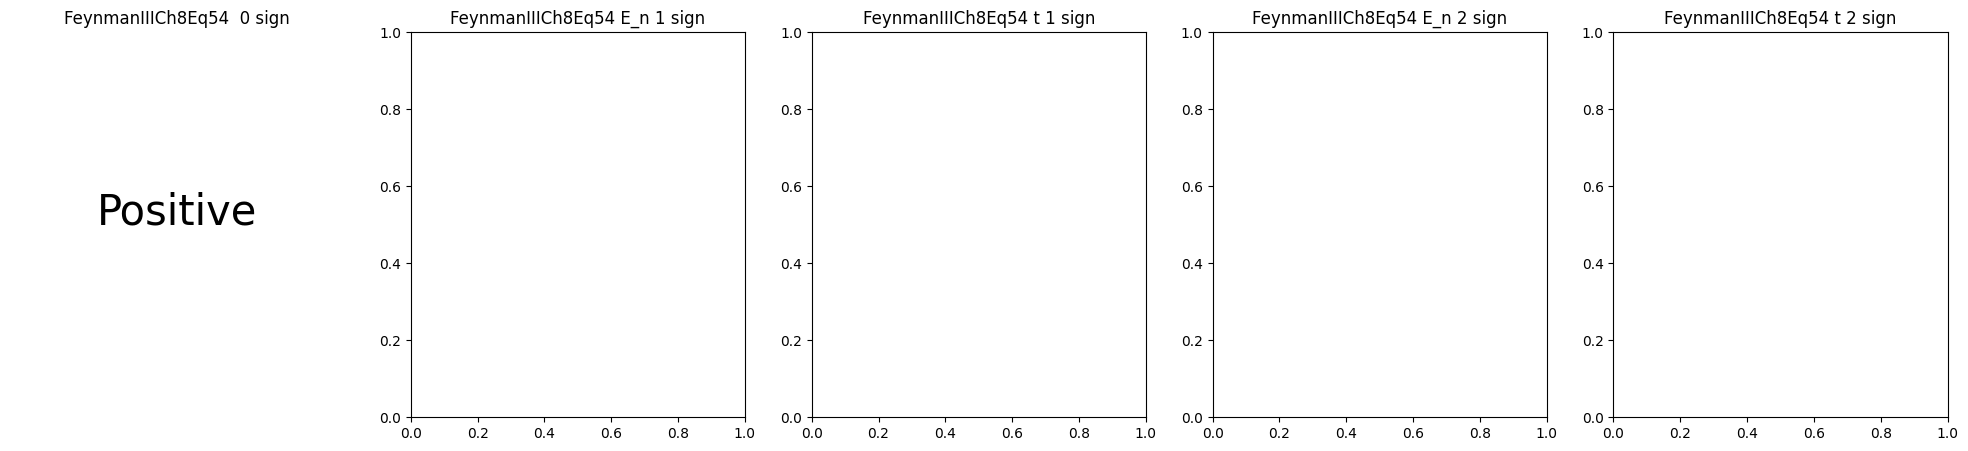

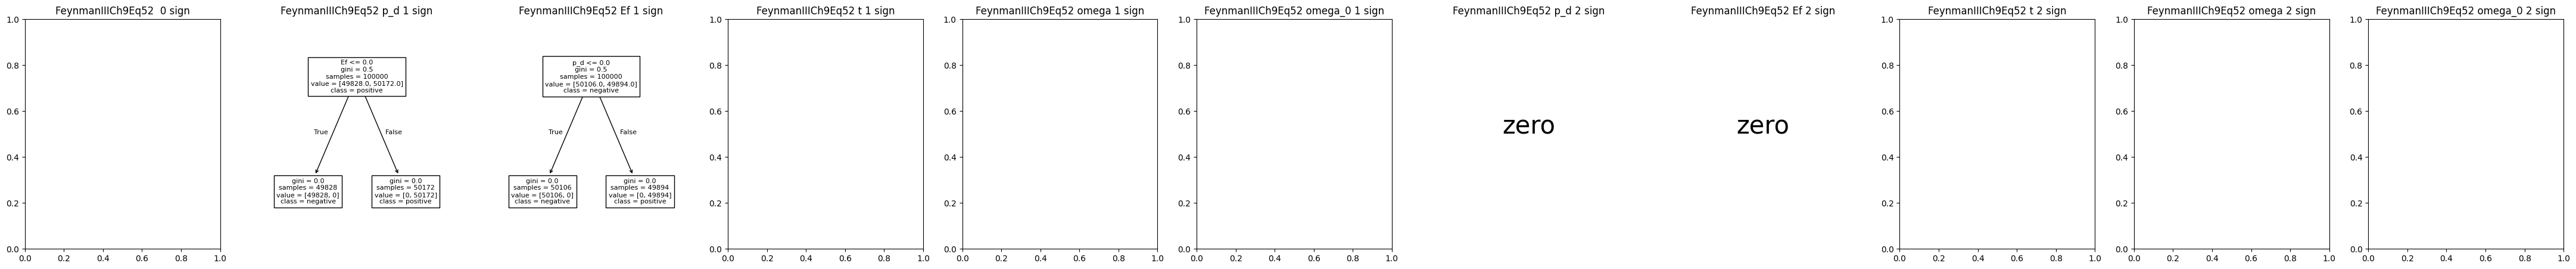

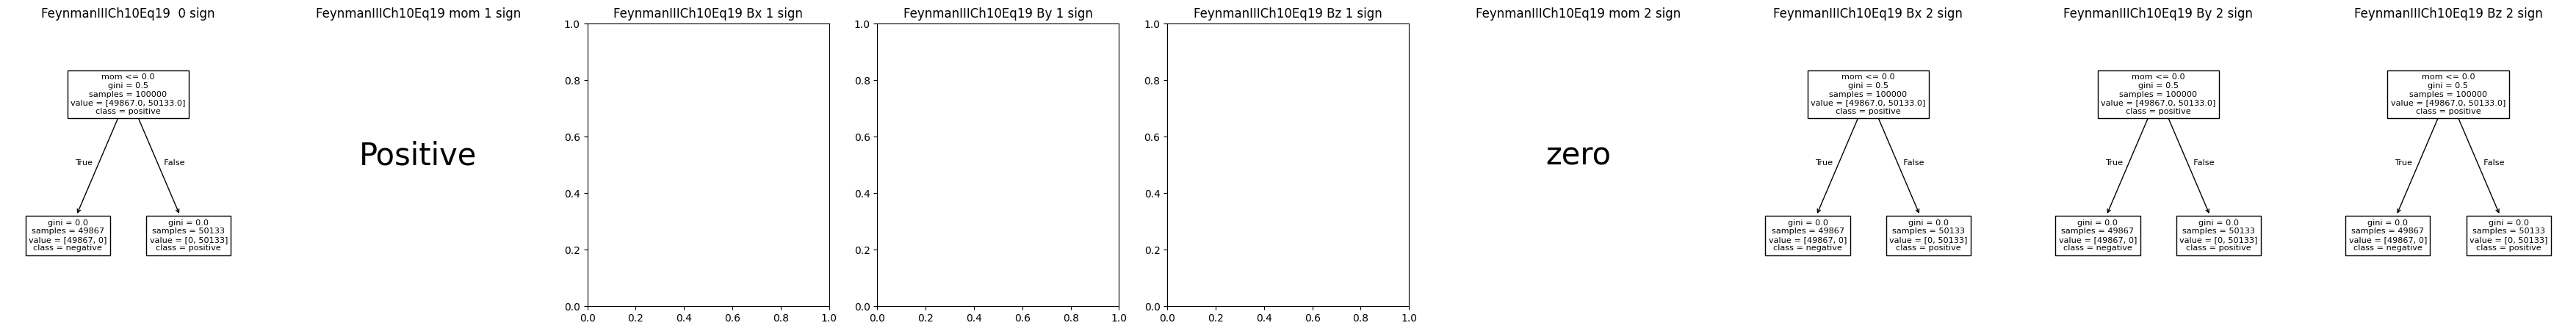

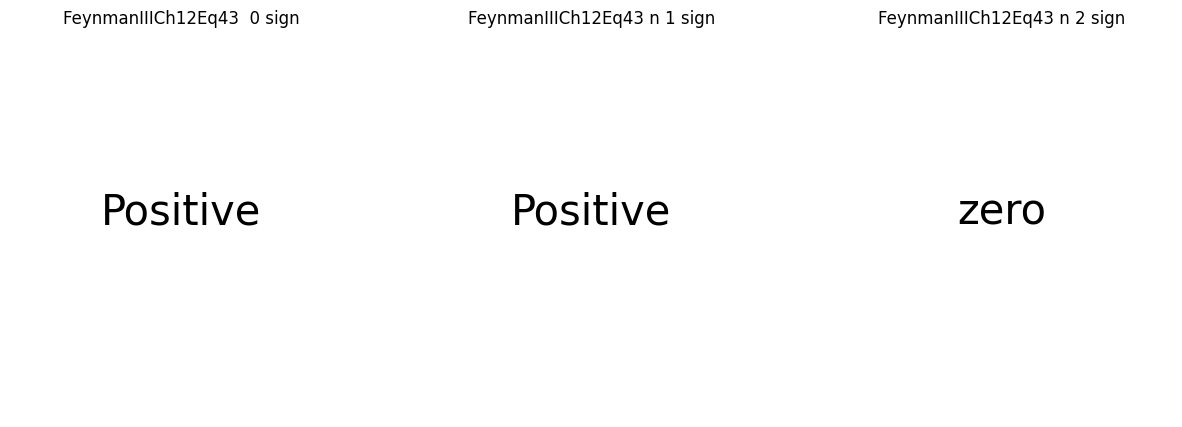

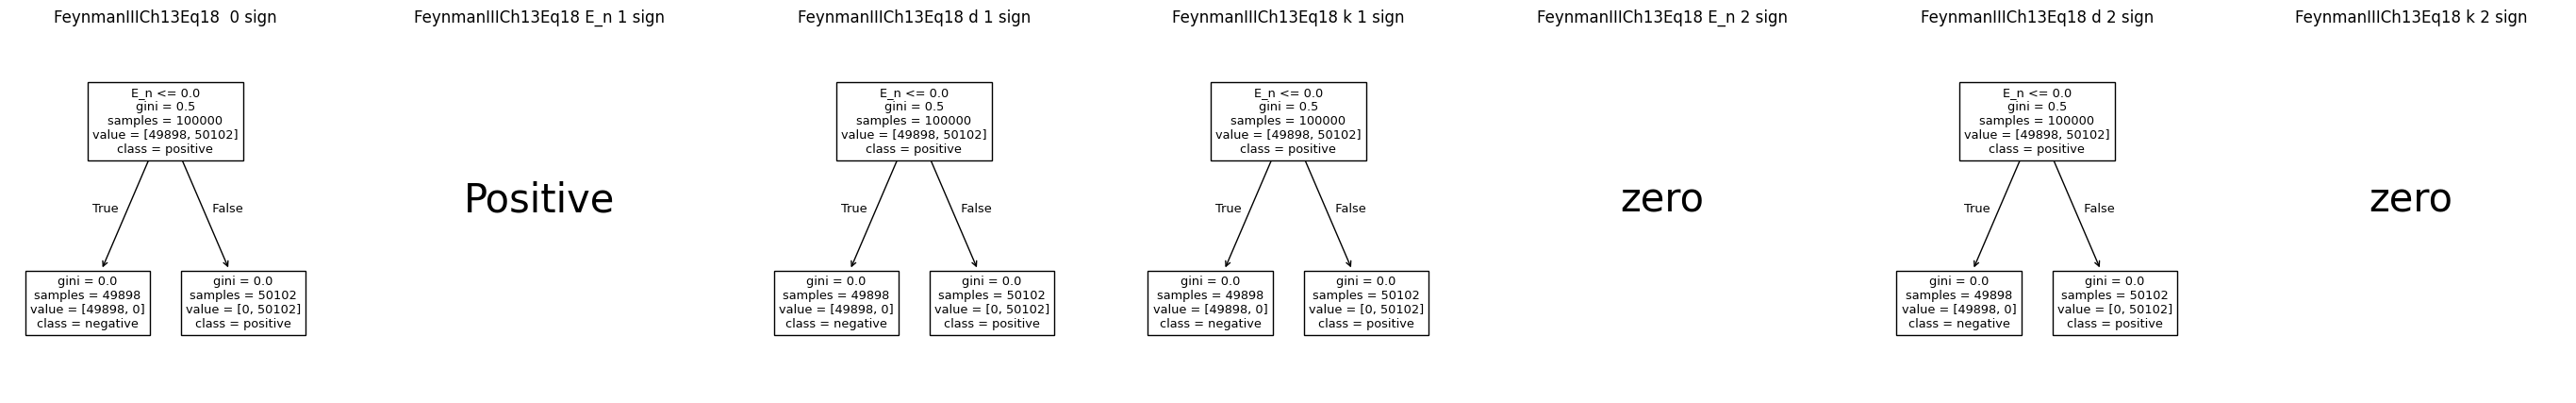

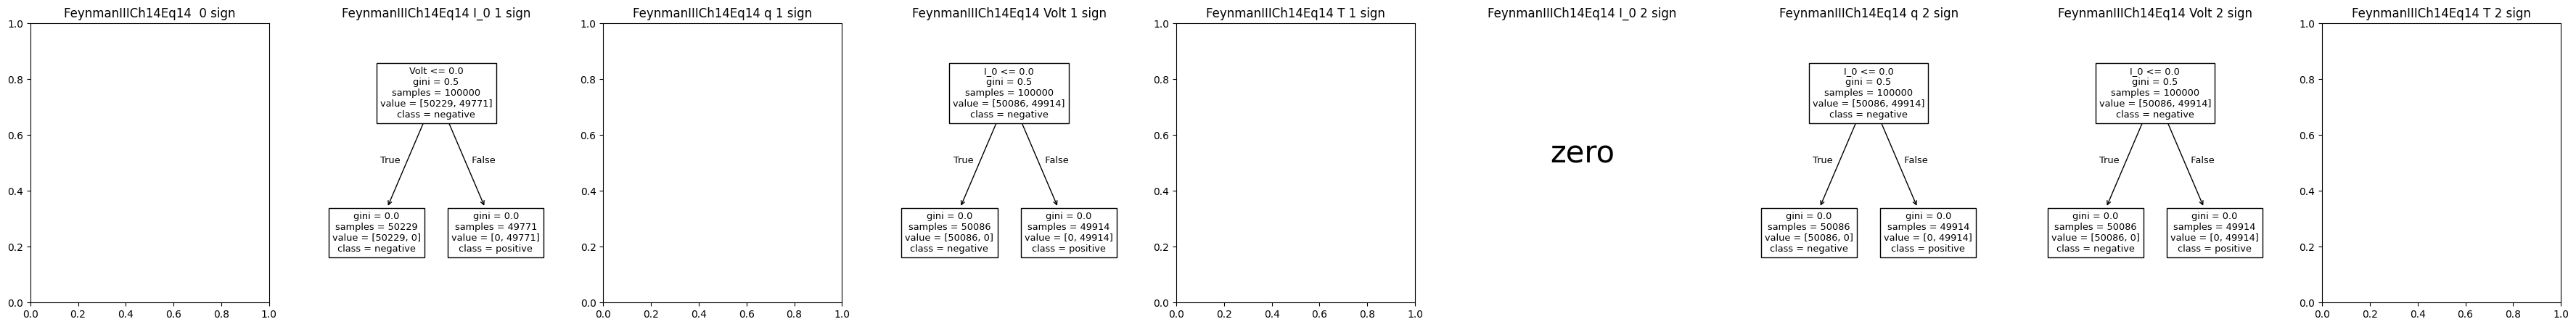

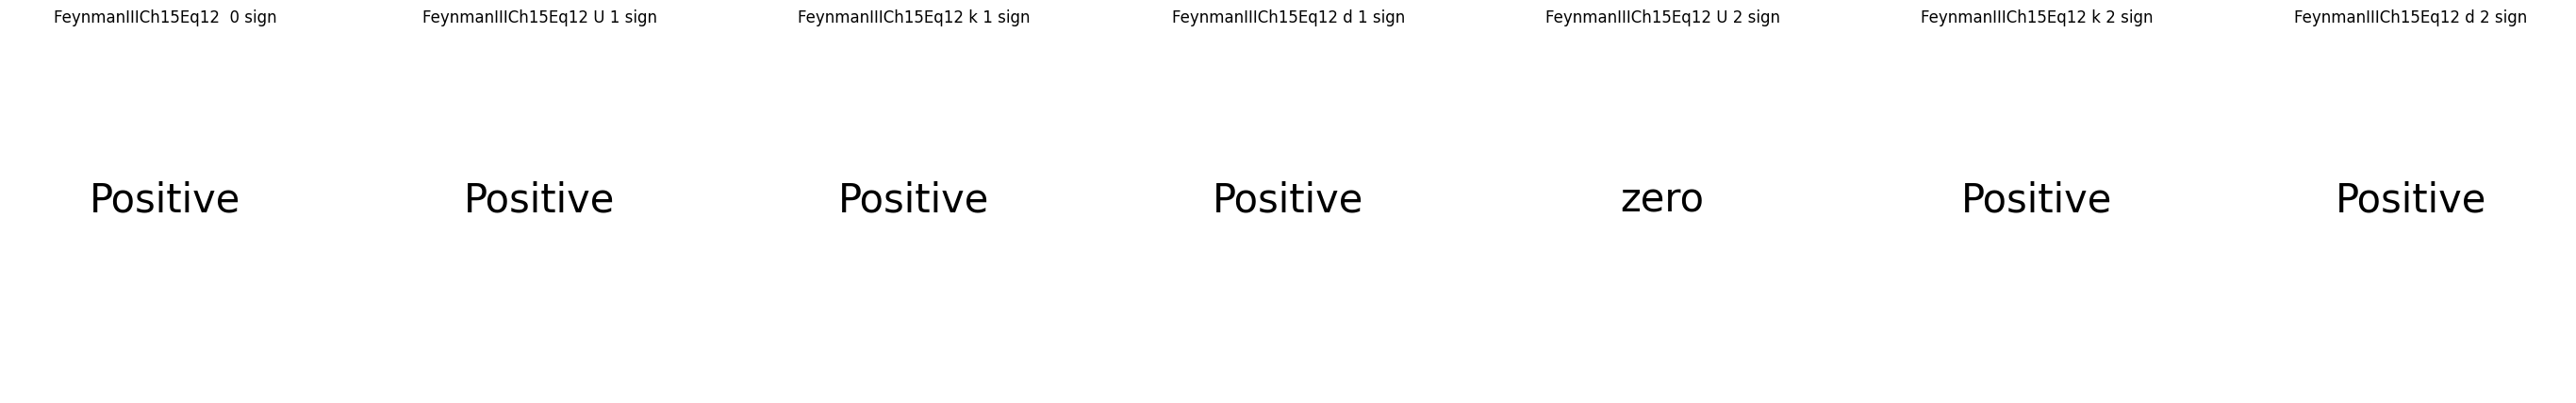

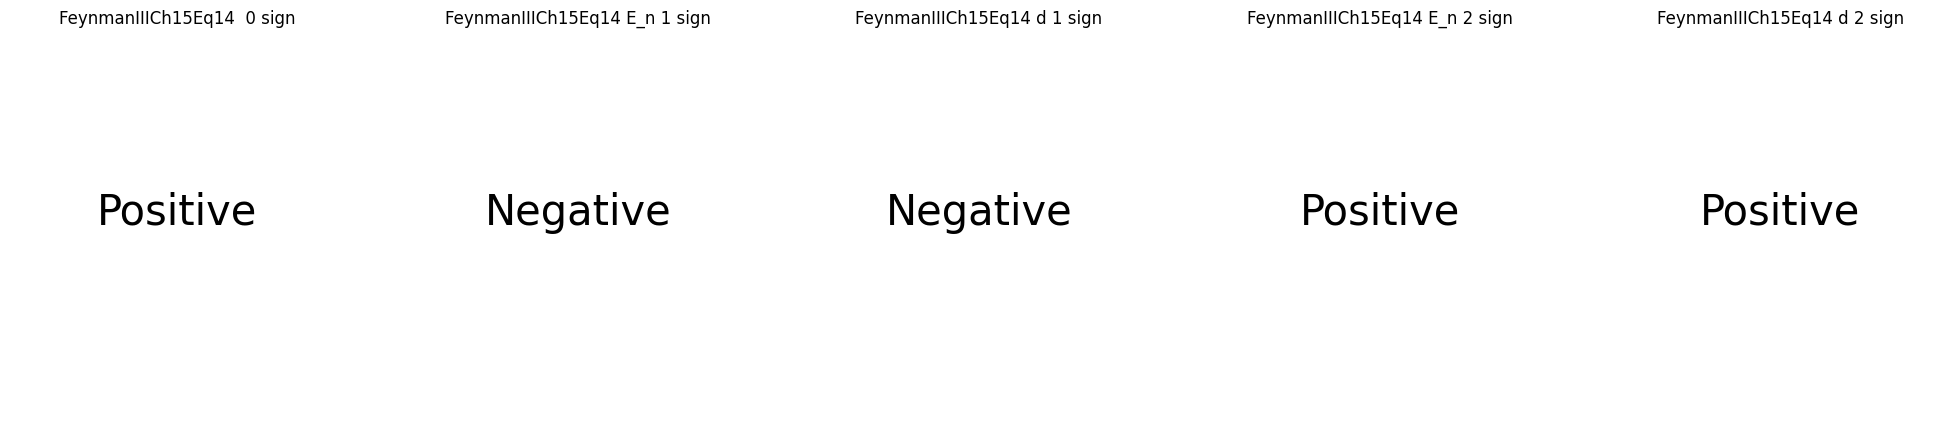

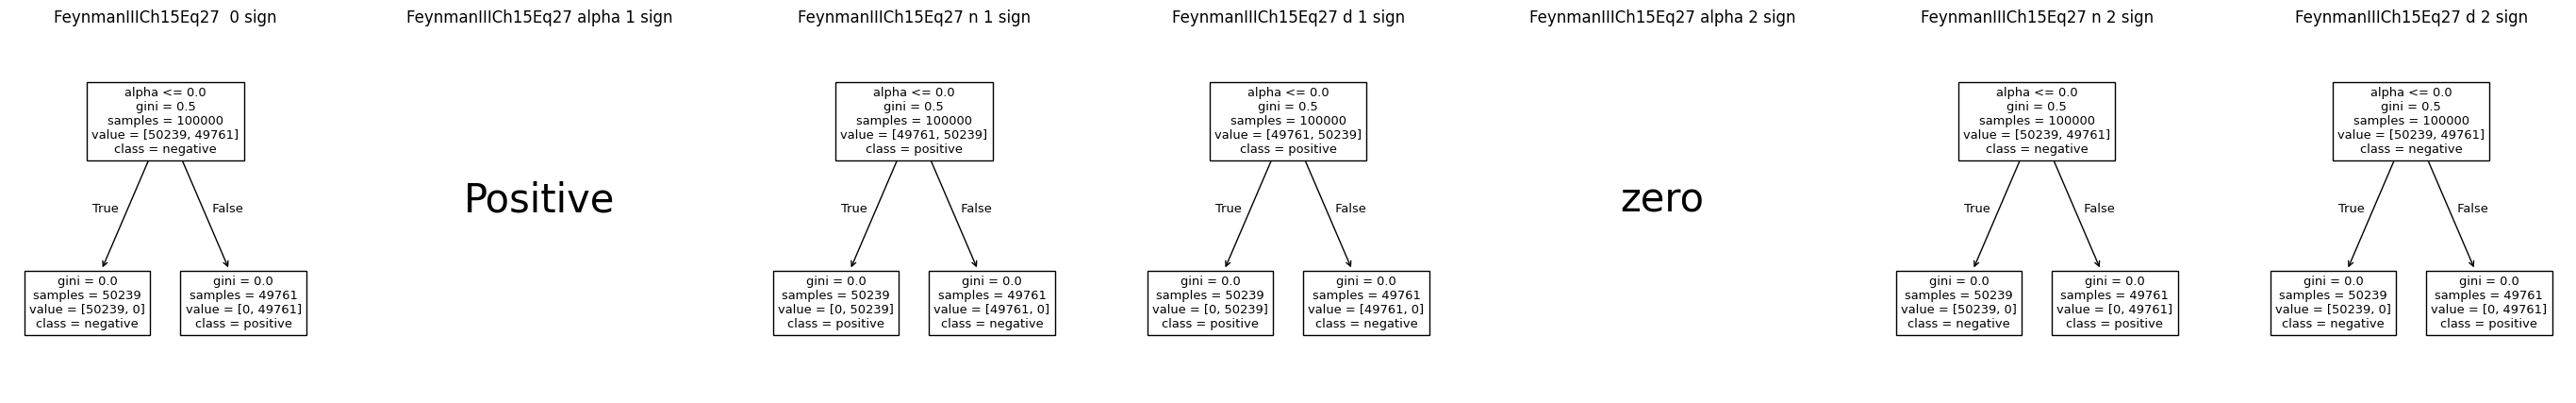

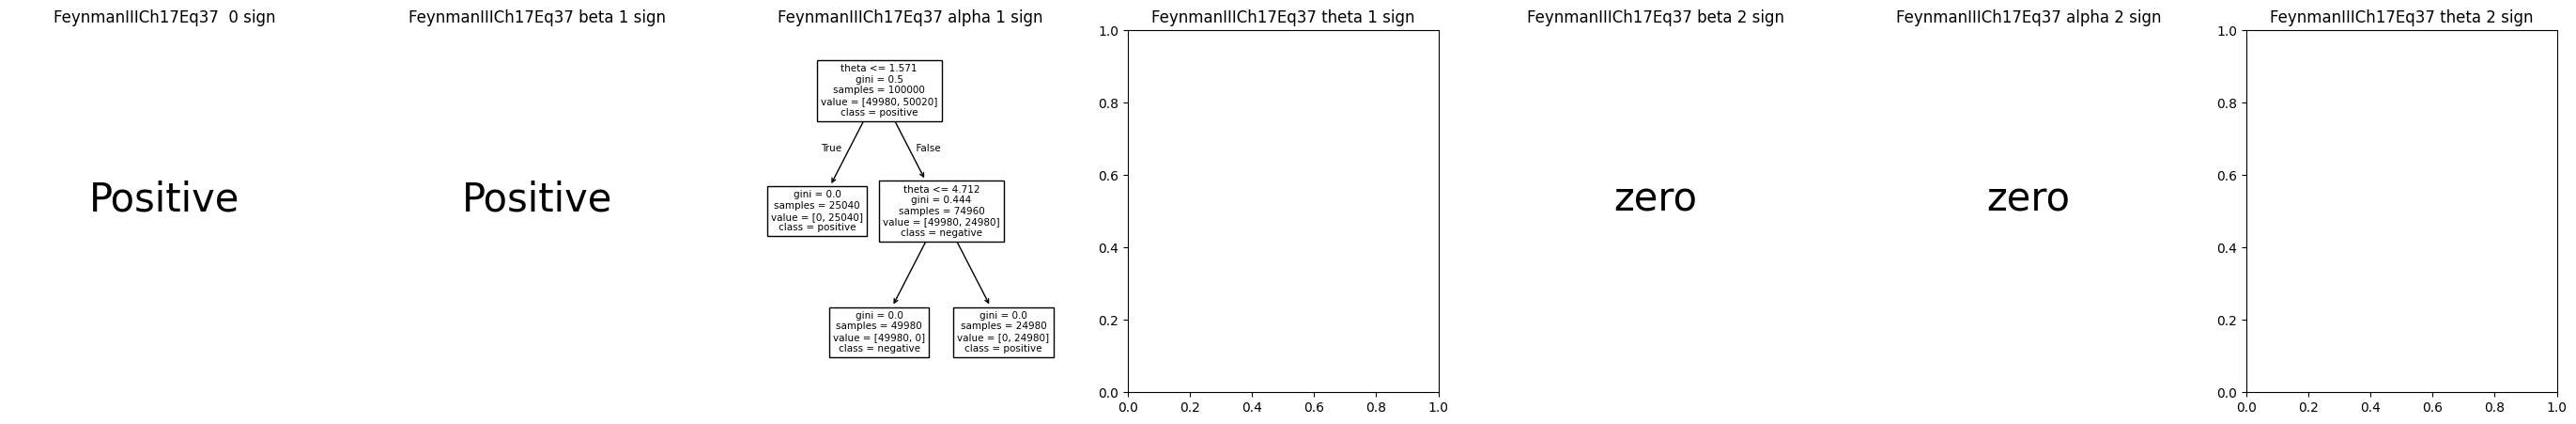

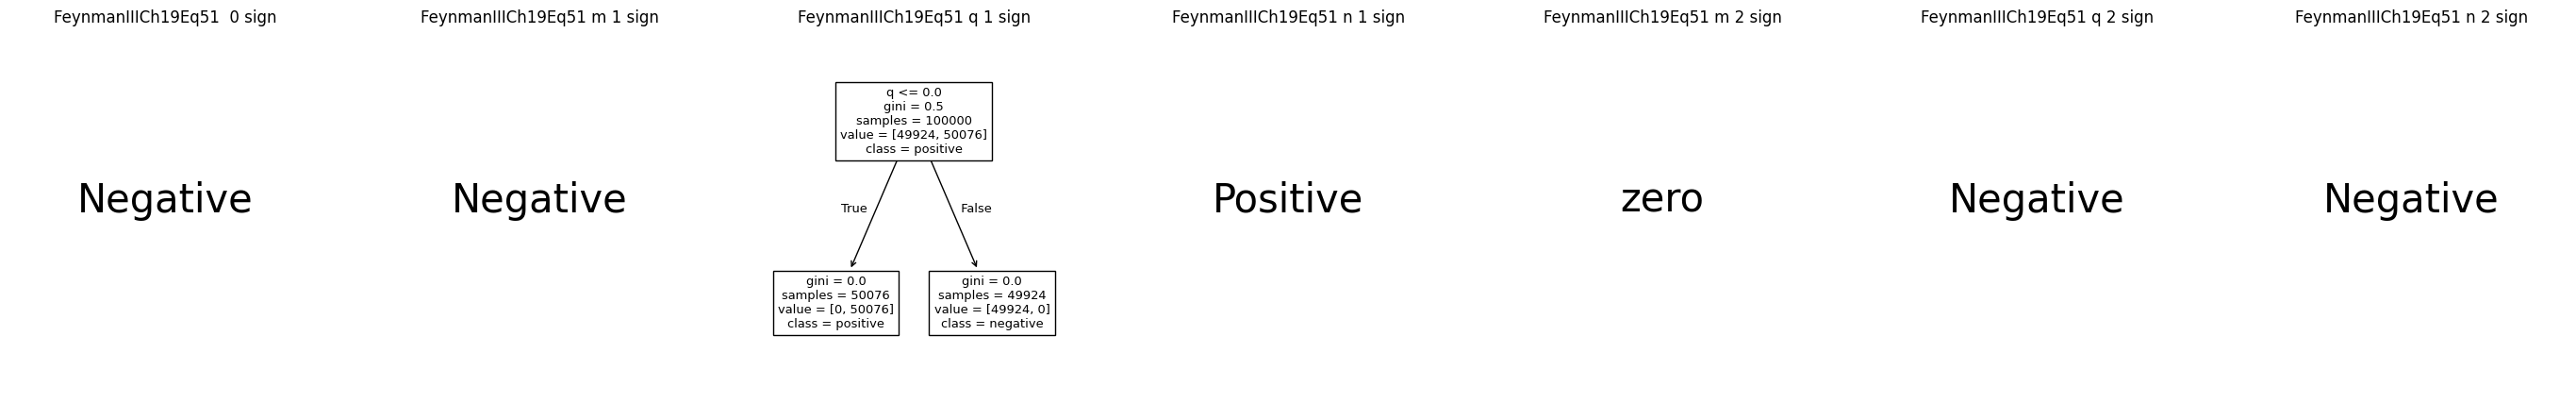

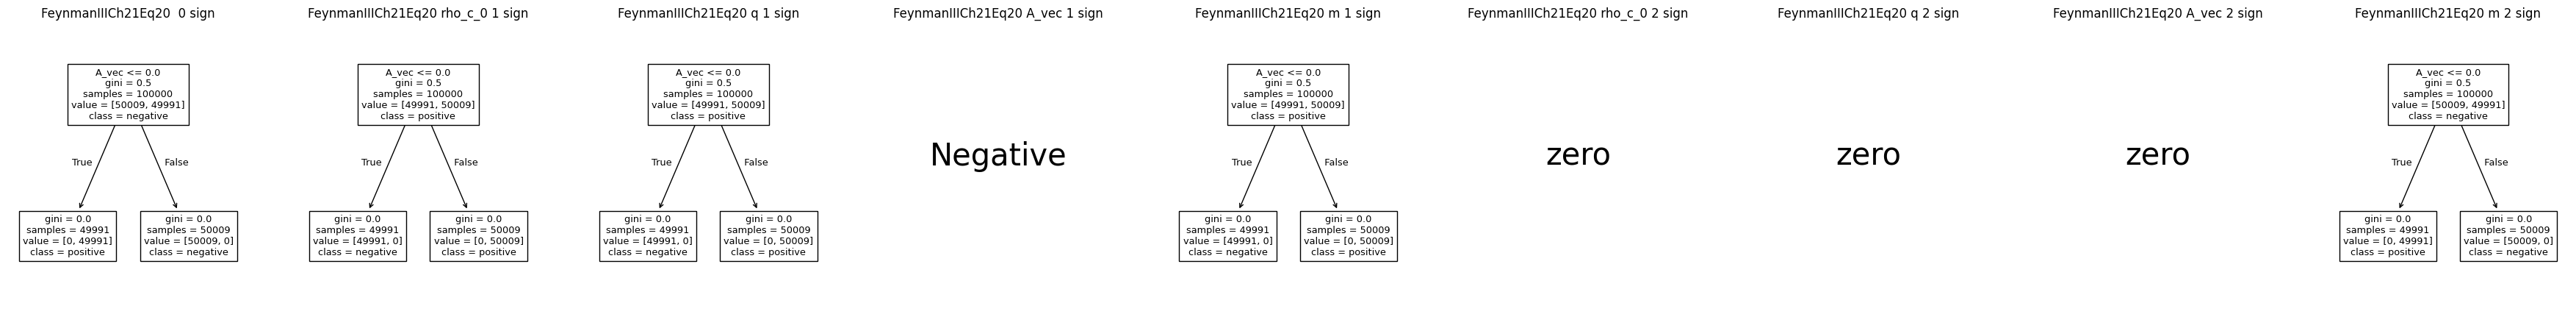

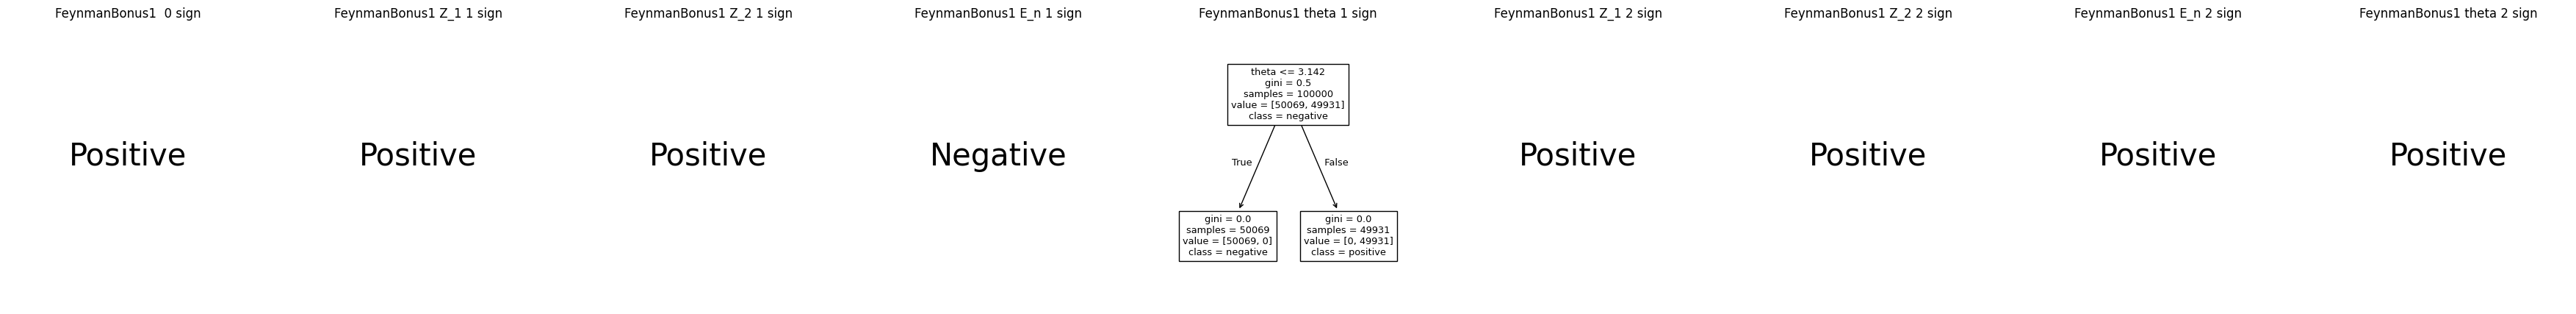

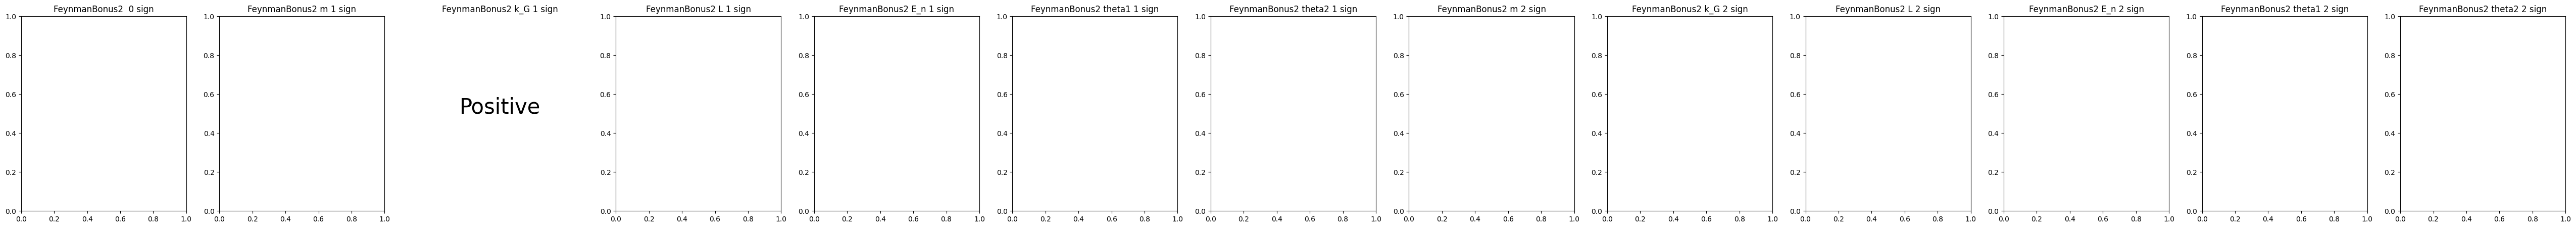

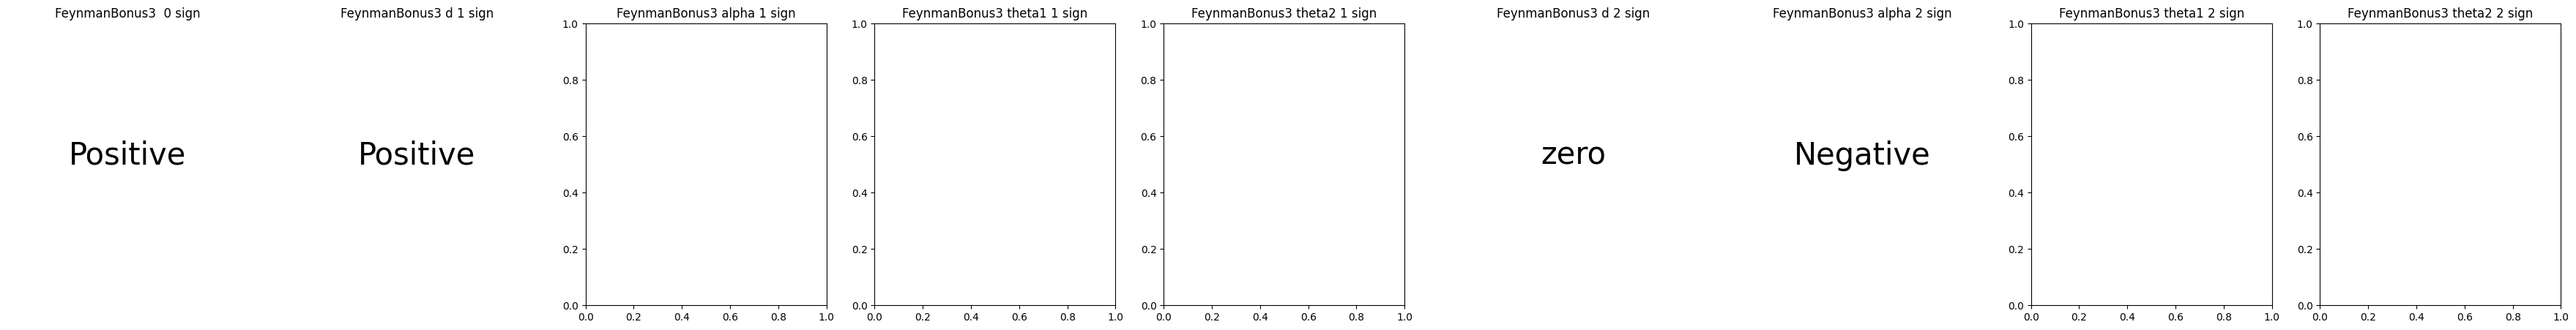

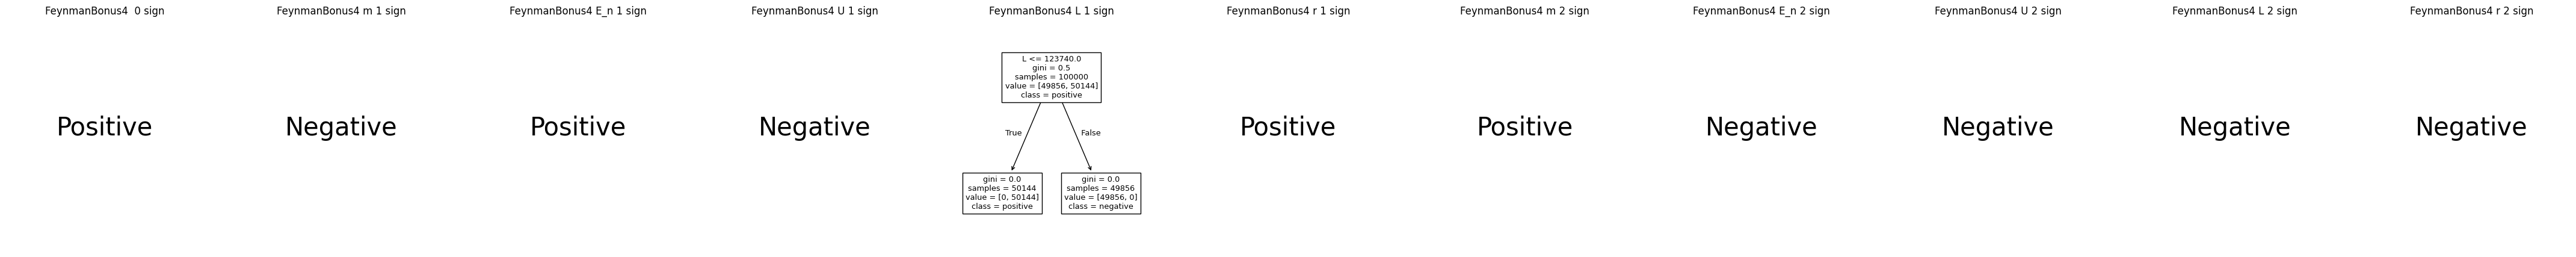

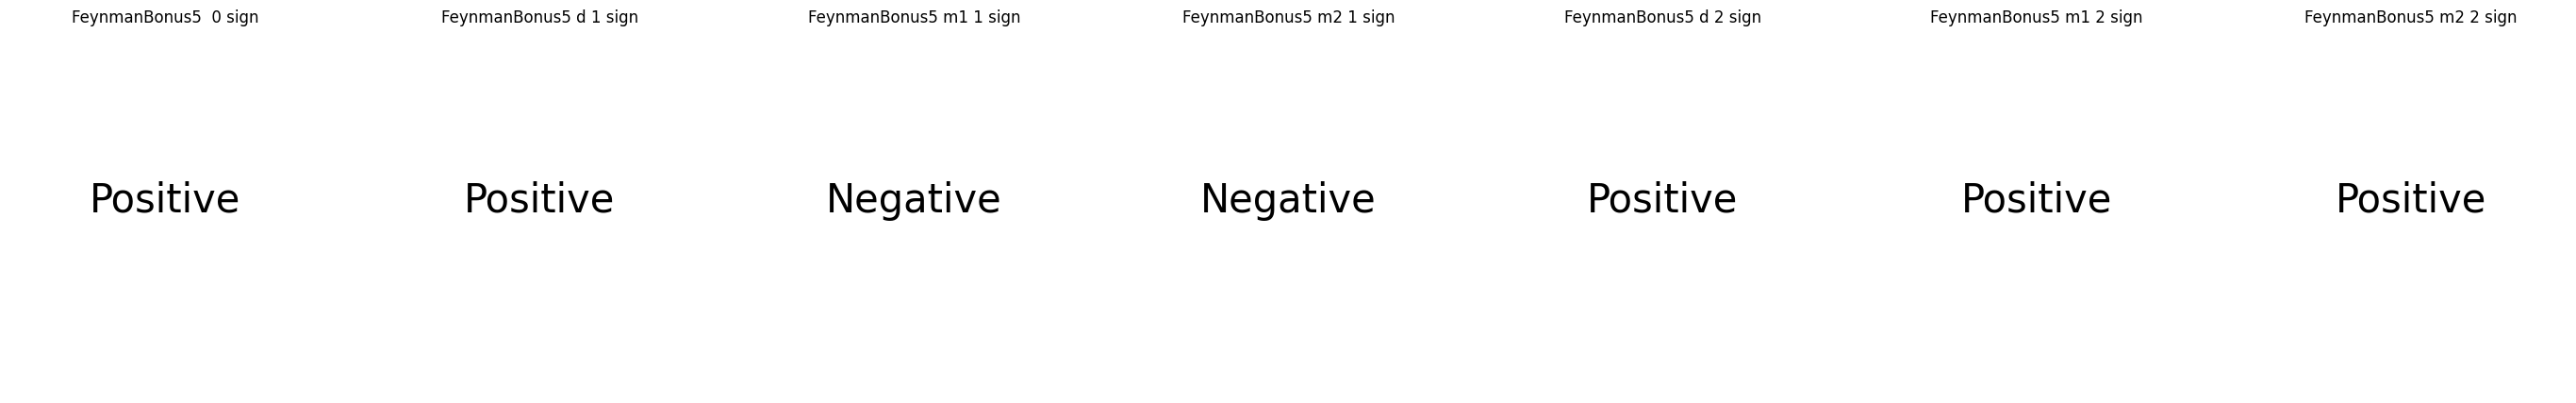

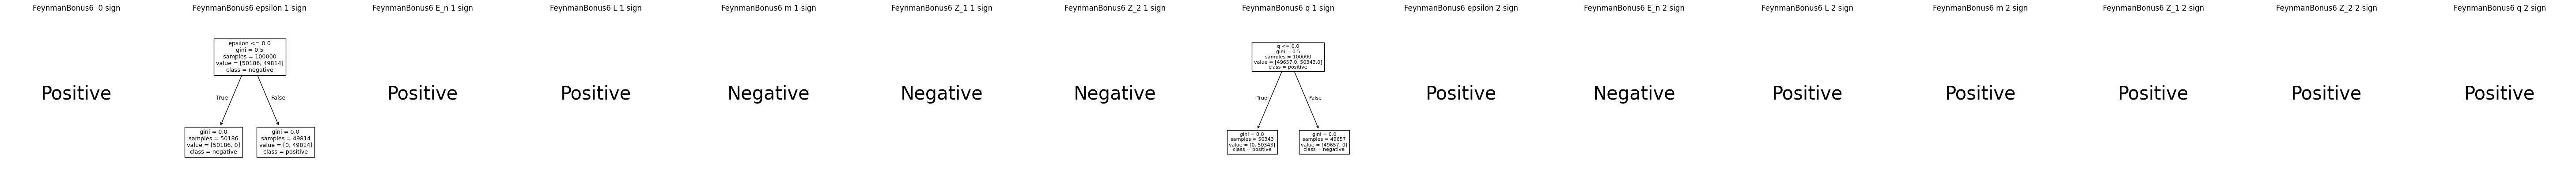

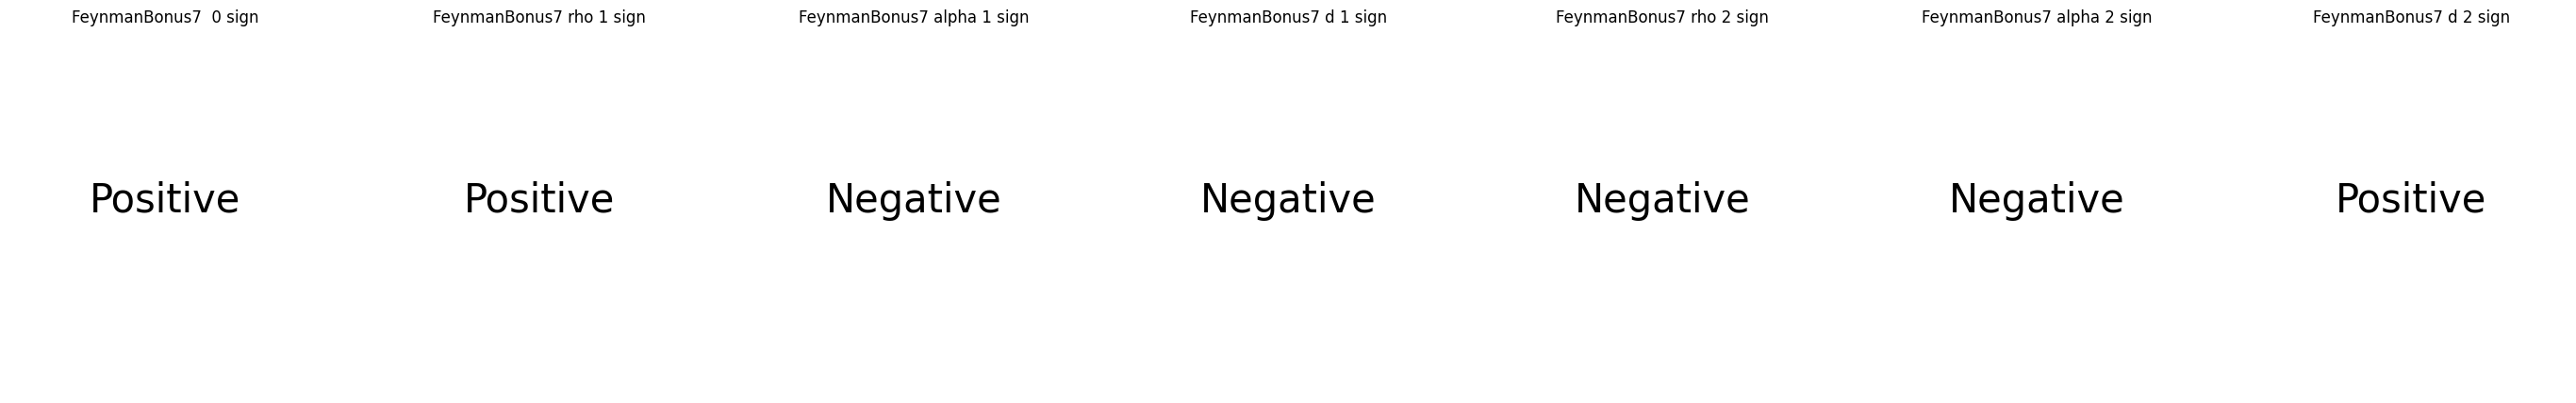

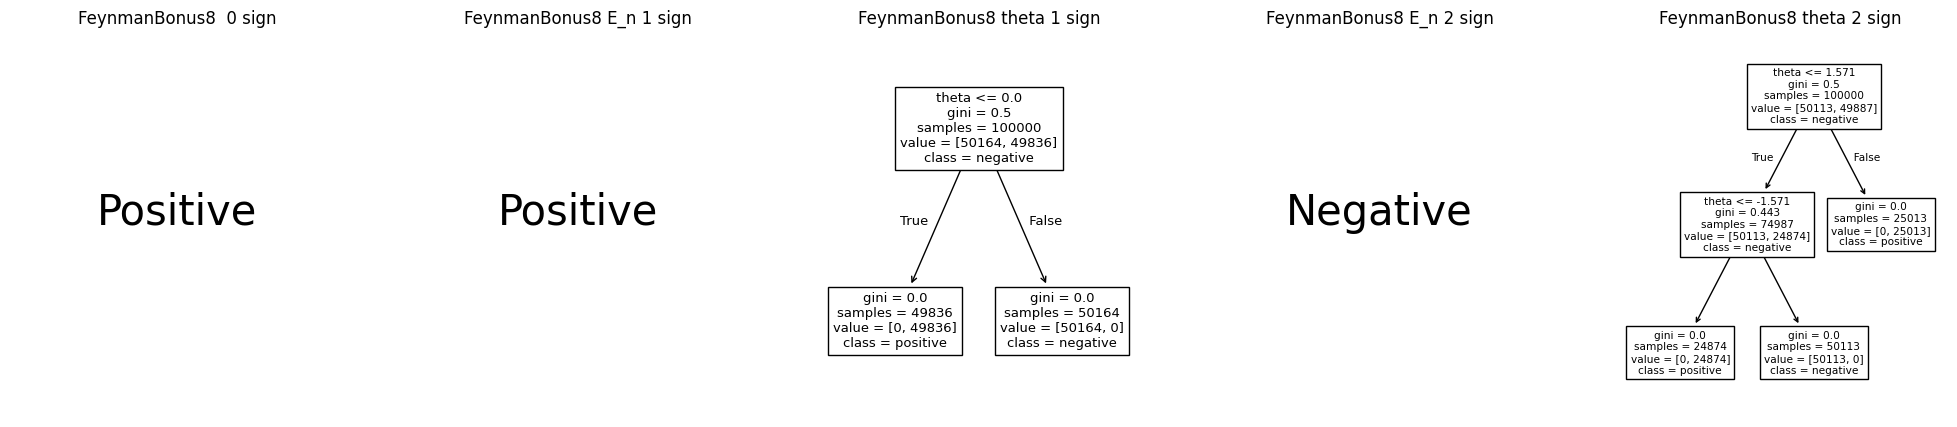

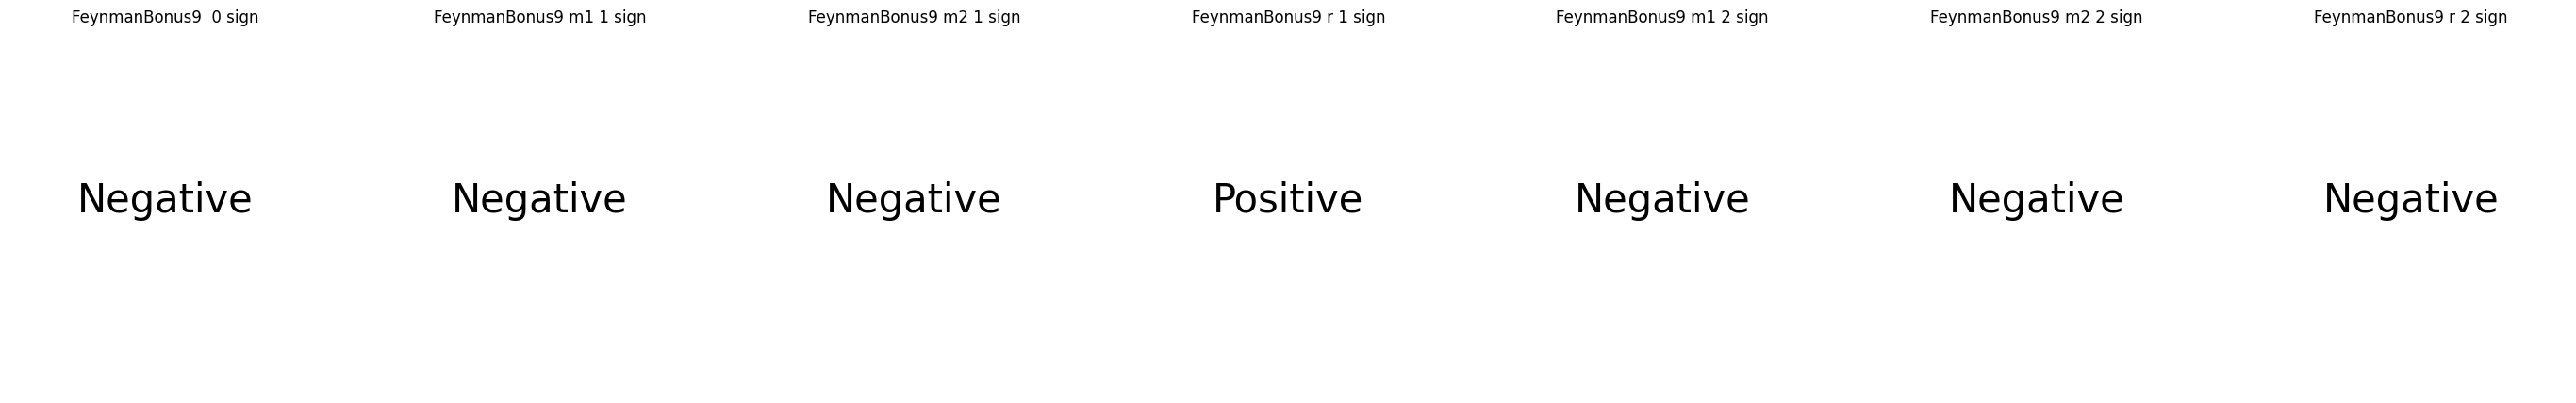

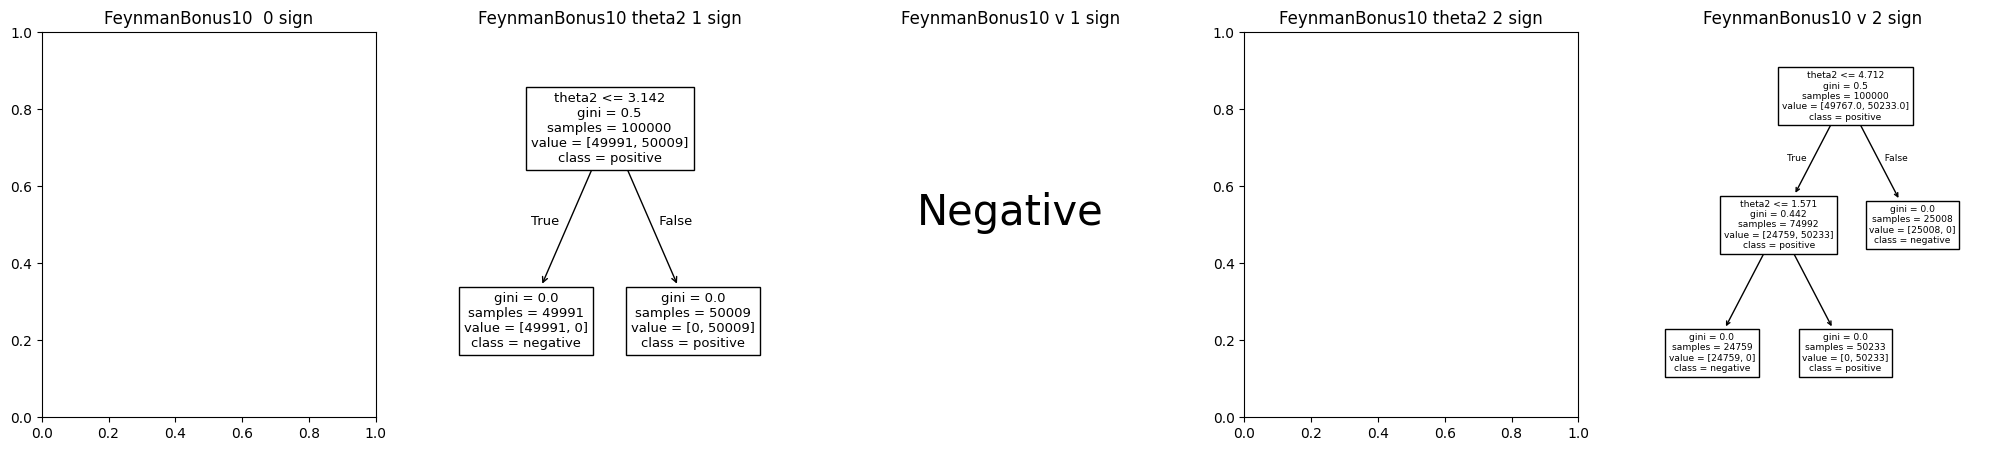

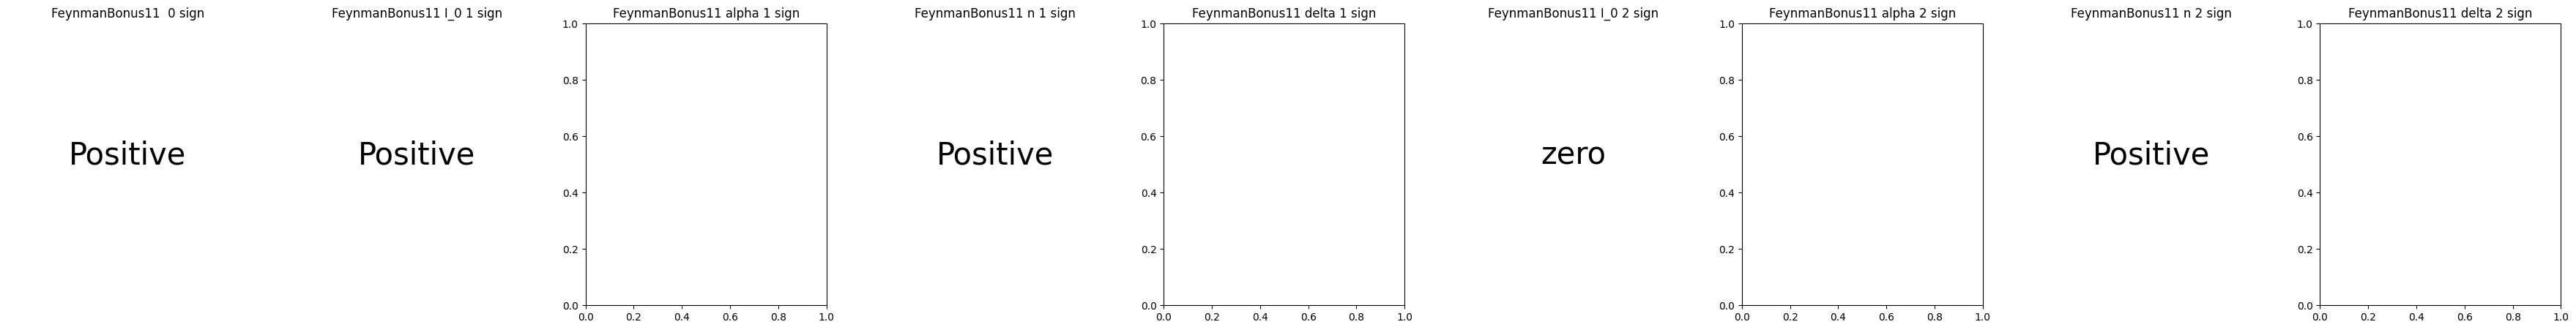

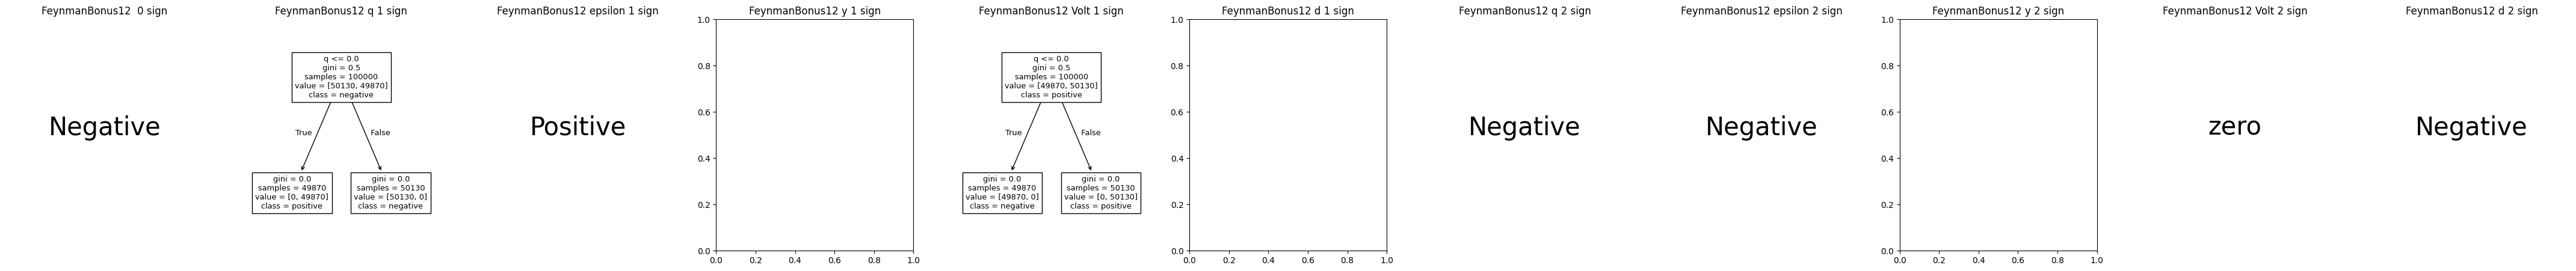

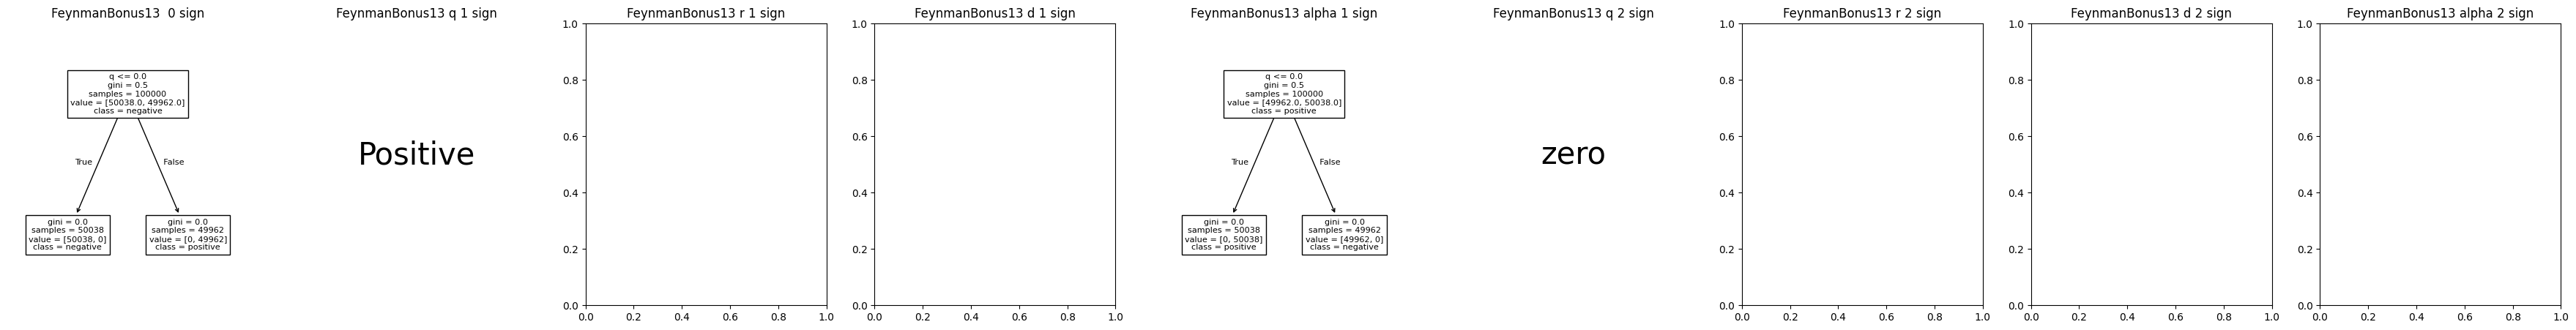

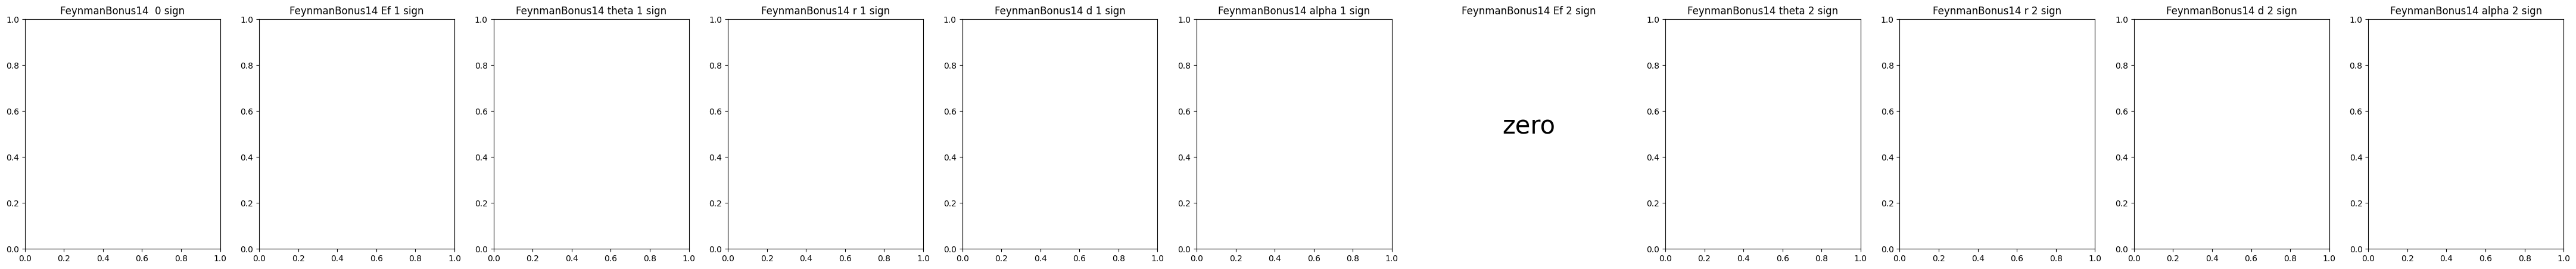

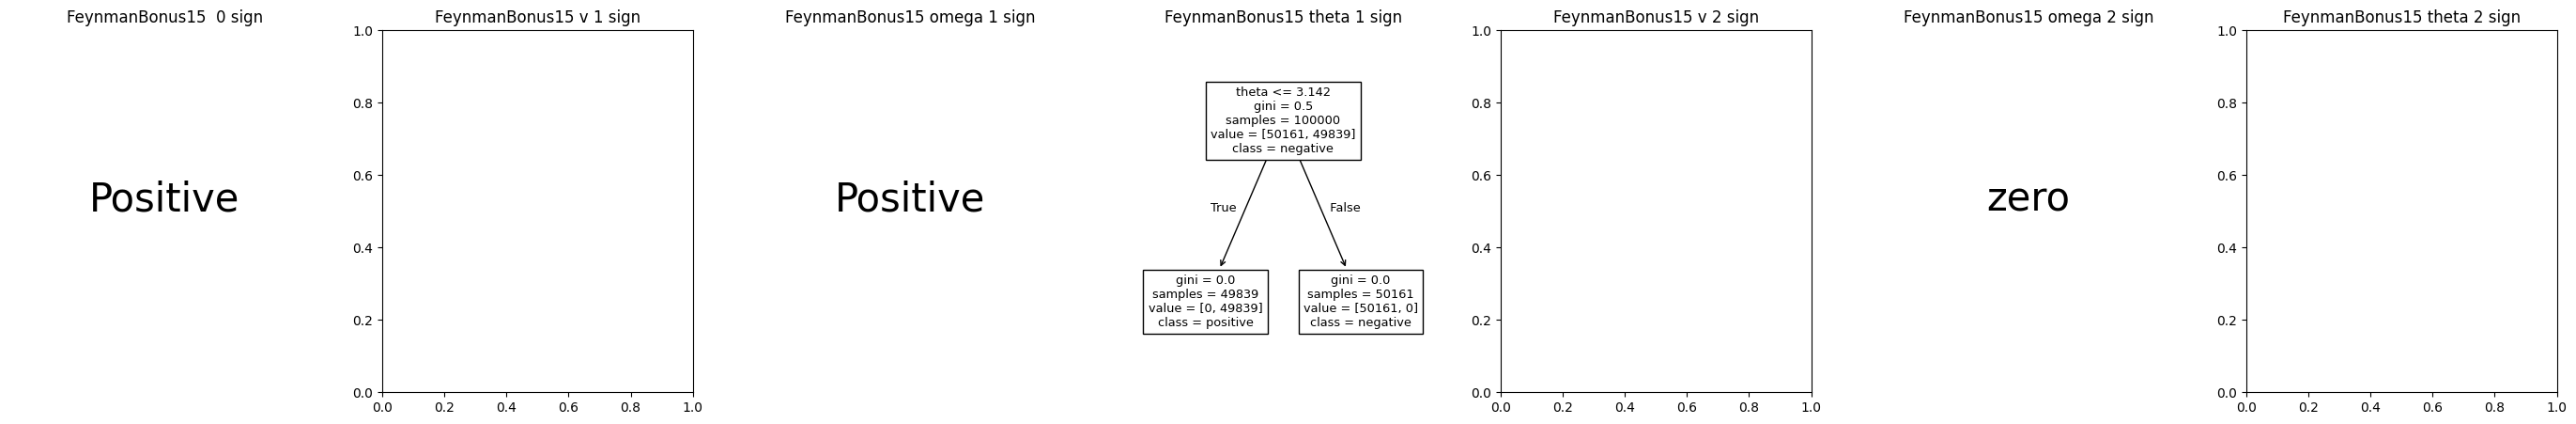

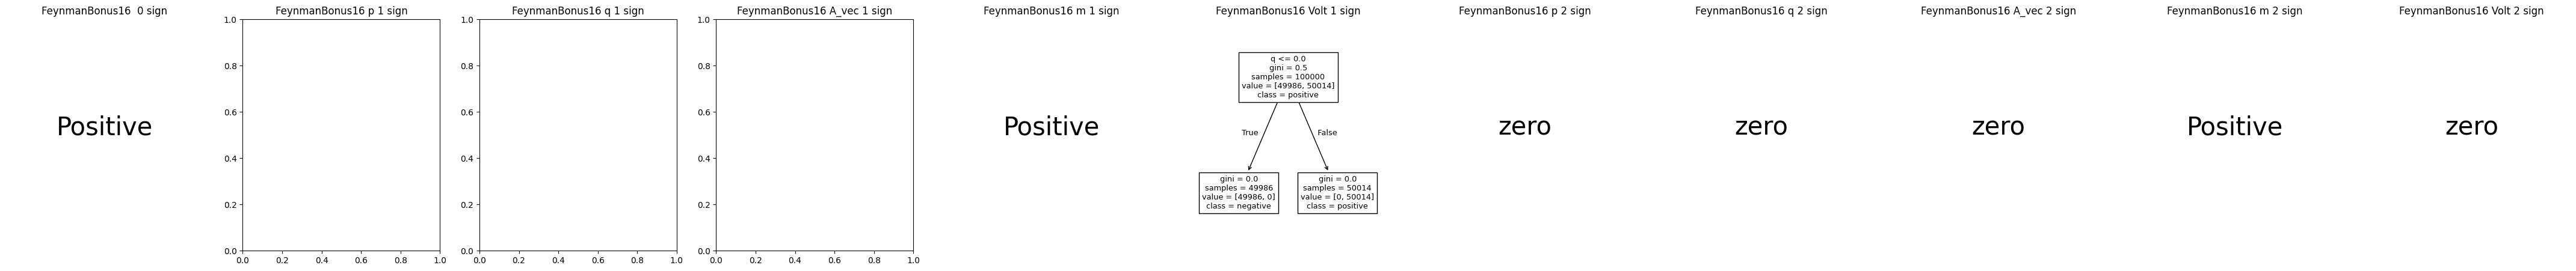

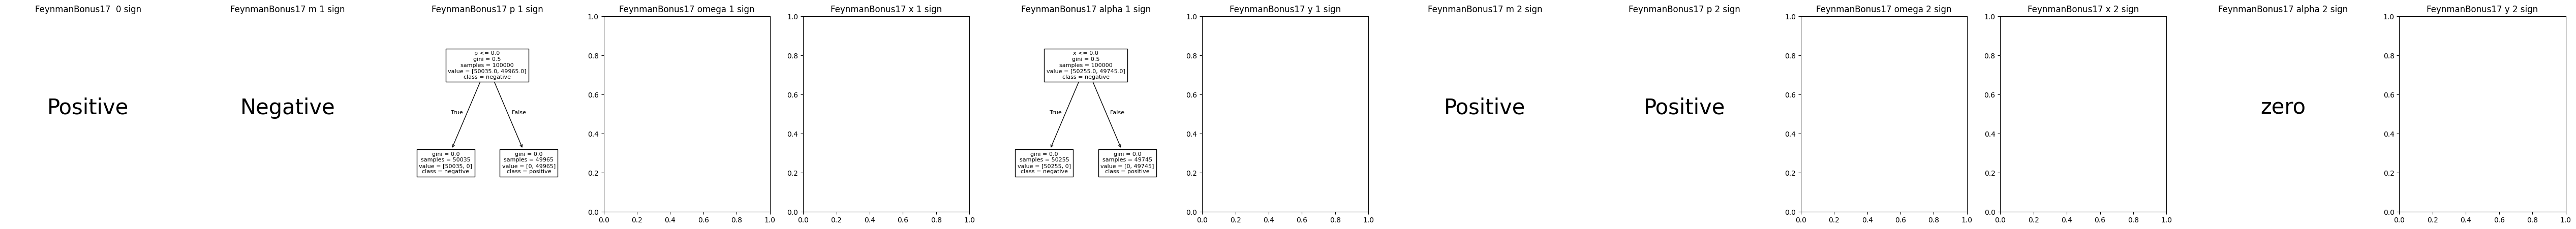

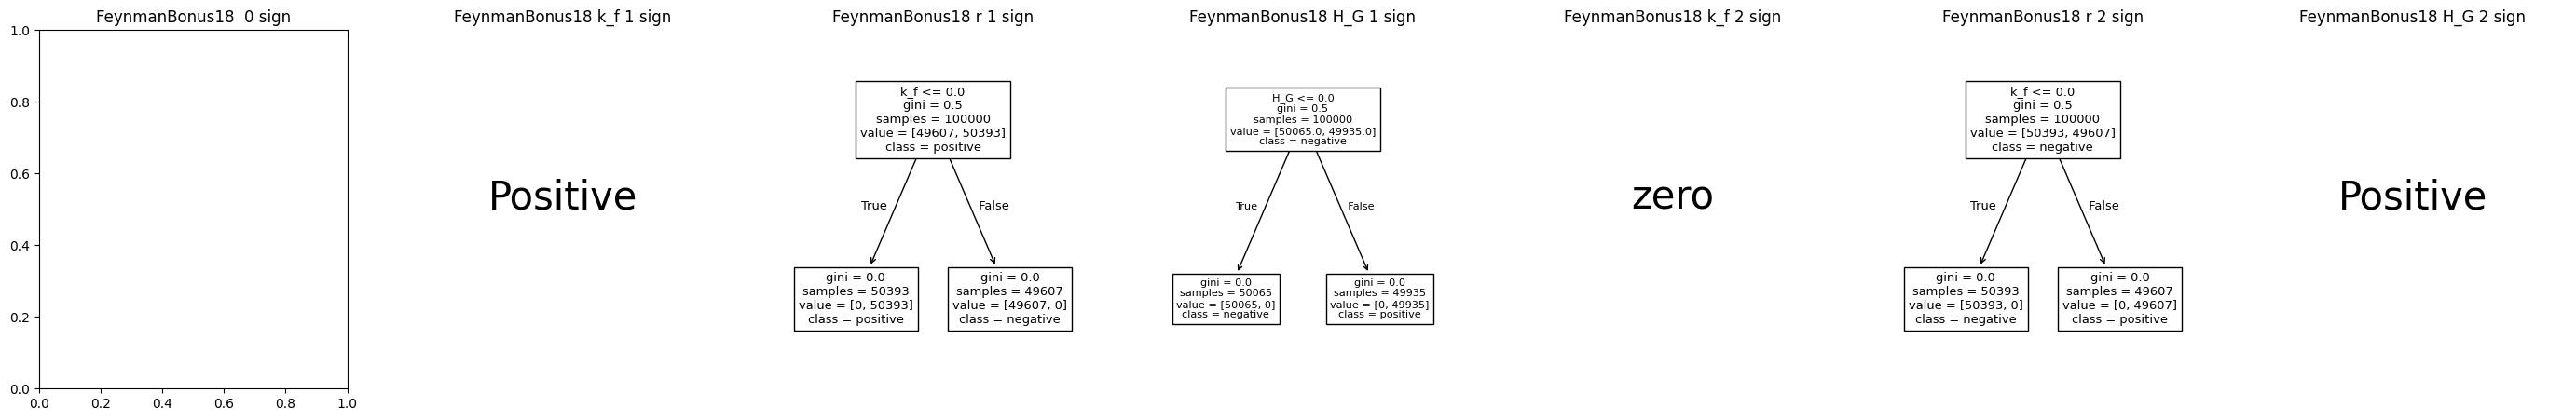

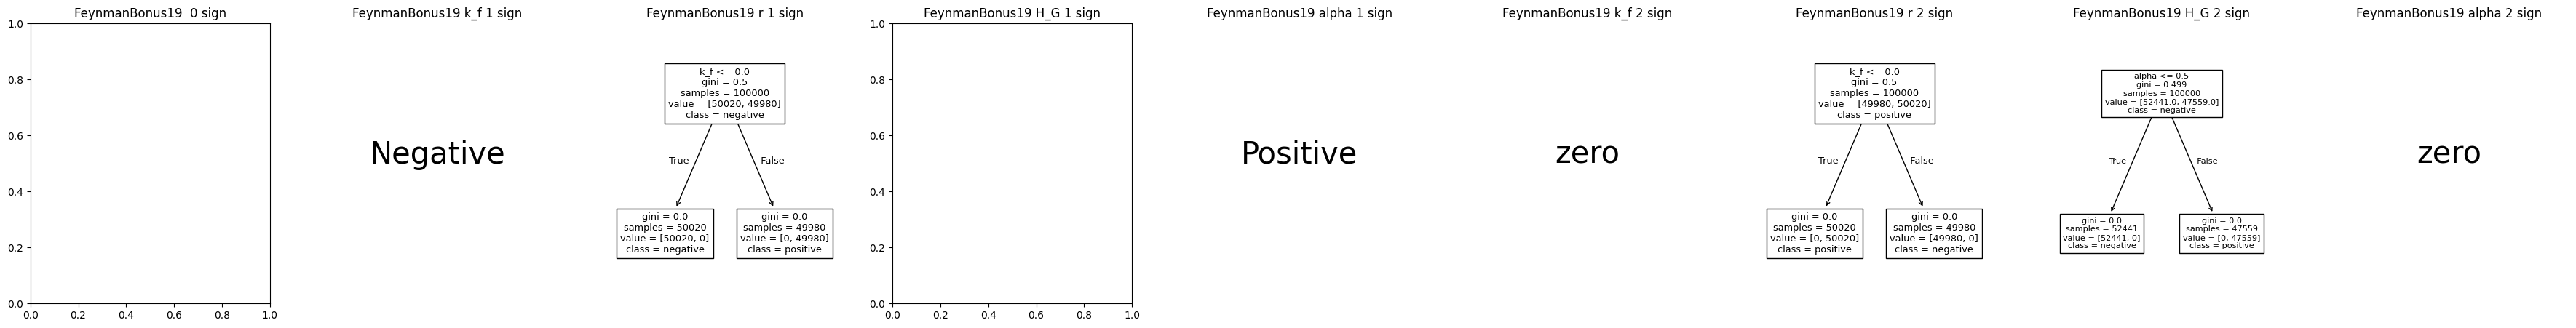

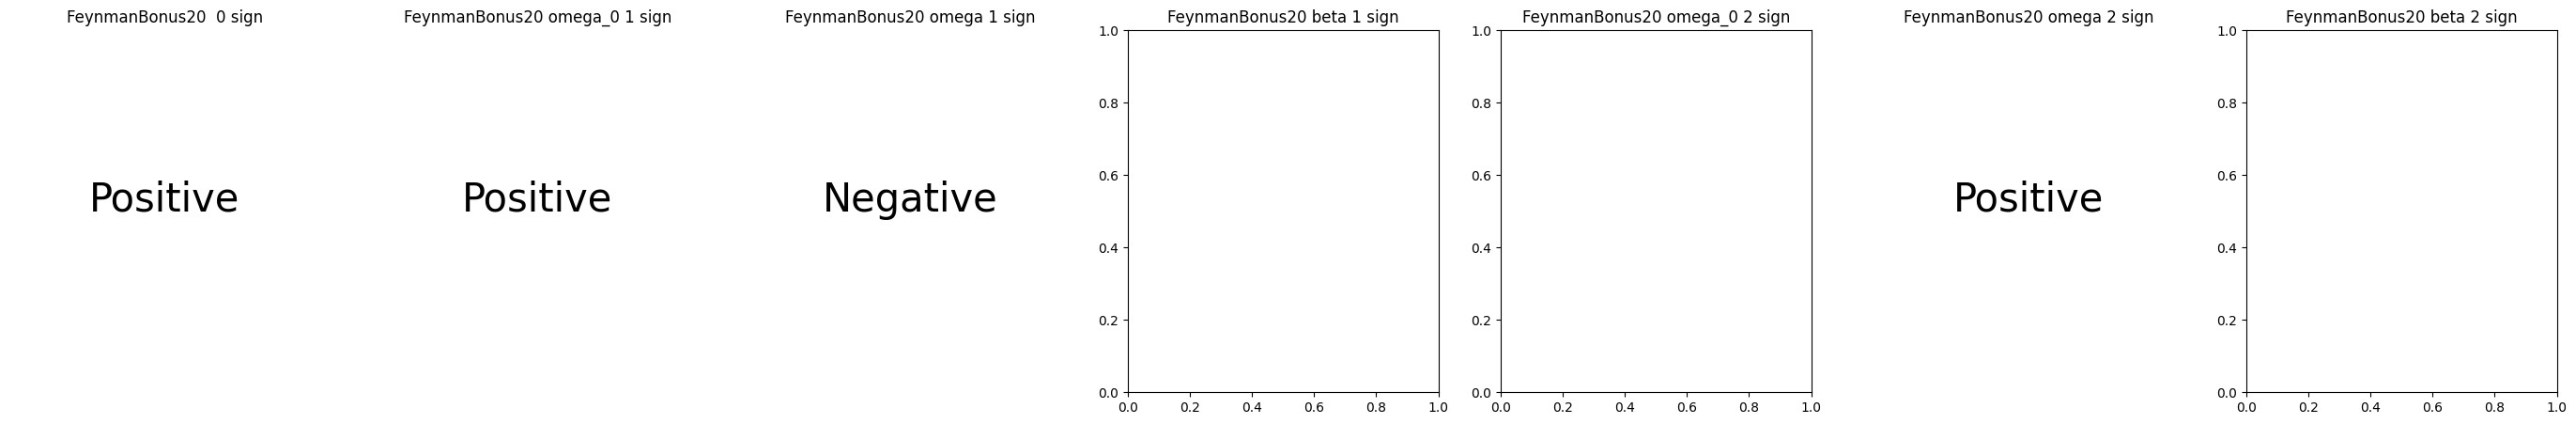

In [2]:
rows = len(res)
cols = max([len(res[x]) for x in res])
print(rows, cols)
i = 0
for n in list(res):
    j = 0
    cols = len(res[n])
    fig, axs = plt.subplots(1, cols, figsize = (5*cols, 5))
    for t in res[n]:
        ax = axs[j] if cols>1 else axs
        clt = res[n][t]
        match clt:
            case None:
                pass
            case sk.EQUATION_CONSTRAINTS_DESCRIPTOR_ZERO:
                ax.text(0.5, 0.5, "zero",  fontsize=30, horizontalalignment = "center")
                ax.set_axis_off()
            case sk.EQUATION_CONSTRAINTS_DESCRIPTOR_POSITIVE:
                ax.text(0.5, 0.5, "Positive",  fontsize=30, horizontalalignment = "center")
                ax.set_axis_off()
            case sk.EQUATION_CONSTRAINTS_DESCRIPTOR_NEGATIVE:
                ax.text(0.5, 0.5, "Negative", fontsize=30, horizontalalignment = "center")
                ax.set_axis_off()
            case _:
                tree.plot_tree(clt[0], class_names=["negative", "positive"],feature_names=clt[1] ,ax = ax)
        ax.set_title(f'{n} {t}')
        
        j +=1
    i+=1
    #fig.savefig(f'{n}.pdf')